# Predictiong biochemical activity against 2c9 with a small dataset

In this notebook we will try to use the more representative features of the MACCS fingerprint and the physicochemical descriptors given by Mordred library to fit a model with small dataset.


## Overview

- Load data
- Get fingerprint (in this case we simply load it from files)
- Get descriptors
    - Remove outliers and Normalise data
- Split the data (500 molecules Train + Validation)
- Select data with mutual information score
- DNN
    - Hyperparameters tunning

## 1) Packages

In [3]:
%matplotlib inline
%load_ext tensorboard
!rm -rf ./logs/ 

import os
import random
import numpy as np
import numpy.testing as npt 
import pandas as pd
import collections
import tensorflow as tf
from scipy import stats
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from itertools import product
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.metrics import auc, roc_curve, f1_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize #, minmax_scale it could also be tried.
from sklearn.feature_selection import SelectPercentile, SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.model_selection import StratifiedKFold
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from rdkit import Chem
from mordred import Calculator, descriptors

plt.style.use("ggplot")
matplotlib.rcParams.update({'font.size': 24})
PATH_DATA = "../datasets/CYP/"
print(tf.__version__)

2.0.0


## 2) Loading data

In [4]:
PATH_DATA = "../datasets/CYP/"

shared_data = pd.read_csv(os.path.join(PATH_DATA, "shared_set_cyp.csv"))
labels_2c9 = (shared_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
labels_3a4 = (shared_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)
testing_2c9_data = pd.read_csv(os.path.join(PATH_DATA, "only_2c9_set_cyp.csv"))
labels_testing_2c9 = (testing_2c9_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
testing_3a4_data = pd.read_csv(os.path.join(PATH_DATA, "only_3a4_set_cyp.csv"))
labels_testing_3a4 = (testing_3a4_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)

In [5]:
def col_to_array(df, col_name='p450-cyp2c9 Activity Outcome'):
    col = df[col_name]
    arr = col.to_numpy() # class wants to make reference to active or inactive
    arr = np.reshape(arr, [arr.shape[0],1])
    return np.squeeze(arr)

In [6]:
smi_col_shared = col_to_array(shared_data, 'CanonicalSMILES')
smi_col_only2c9 = col_to_array(testing_2c9_data, 'CanonicalSMILES')

## 3) Get features (Morgan fingerprint)

We need to generate the features for the data sets, we will use Morgan fingerprints as implemented in RDKit.

In [7]:
def get_features(input_sdf):
    structures_shared = Chem.SDMolSupplier(input_sdf)
    features = []
    for mol in structures_shared:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024)
        arr = np.zeros((0,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp,arr)
        features.append(arr)
    return np.array(features)

In [8]:
if os.path.exists(os.path.join("features", "shared_set_features.npy")):
    features_shared = np.load(os.path.join("features", "shared_set_features.npy"))
else:
    features_shared = get_features(os.path.join(PATH_DATA, "shared_set_cyp.sdf"))
    np.save(os.path.join("features", "shared_set_features.npy"), features_shared)
    
if os.path.exists(os.path.join("features", "only_2c9_set_features.npy")):
    features_only_2c9 = np.load(os.path.join("features", "only_2c9_set_features.npy"))
else:
    features_only_2c9 = get_features(os.path.join(PATH_DATA, "only_2c9_set.sdf"))
    np.save(os.path.join("features", "only_2c9_set_features.npy"), features_shared)
    
if os.path.exists(os.path.join("features", "only_3a4_set_features.npy")):
    features_only_3a4 = np.load(os.path.join("features", "only_3a4_set_features.npy"))
else:
    features_only_3a4 = get_features(os.path.join(PATH_DATA, "only_3a4_set.sdf.sdf"))
    np.save(os.path.join("features", "only_3a4_set_features.npy"), features_shared)

## 4) Getting Mordred descriptors

We generate the descriptors using Mordred if ther are not in the features folder, otherwise the data is loaded from there.

There are two types of data we can load:

- Data without processing: this contains all the physicochemical descriptors that are generated with Mordred.
- Clean data: this data doesn't contains all the descriptors computed by Mordred. All the columns wich contain NaN, are remove to easily apply the feature selection.
    - This data has been processed as follows:
        - Convert all the str in the data frame to NaN.
        - Remove columns that contain NaN values.
            - Note that if we remove rows, we obtain an empty df (-> everything is removed)
        - Remove all the columns with different headers between the shared and only 2c9 datasets.
- Detection and remove of Outliers
- Normalisation

In [7]:
load_clean_data =  True # Otherwise it will load data with NaN
remove_outliers = True
normalize_descriptors = True

In [8]:
def get_descriptors(smi_arr, activity_labels, clean_dataset=True, save_to_npy=True, filename='shared_set_features_mordred'):
    calc = Calculator(descriptors, ignore_3D=True)
    mols = [Chem.MolFromSmiles(smi) for smi in smi_arr]
    df_descriptors = calc.pandas(mols)
    df_descriptors = df_descriptors.insert(0, "p450-cyp2c9 Activity Outcome", activity_labels, True)
    if clean_dataset:
        df_descriptors = descriptors_shared.apply(pd.to_numeric, errors='coerce')
        df_descriptors = df_descriptors.dropna(axis=1)
    if save_to_npy:
        df_descriptors.to_csv(os.path.join("features", filename + ".npy"))
    return df_descriptors

In [9]:
if load_clean_data:
    if os.path.exists(os.path.join("features", "shared_set_features_mordred_clean.npy")):
        descriptors_shared = pd.read_csv(os.path.join("features", "shared_set_features_mordred_clean.npy")).drop(['Unnamed: 0'], axis=1)
    else:
        descriptors_shared = get_descriptors(smi_col_shared, labels_2c9, clean_dataset=True, filename='shared_set_features_mordred_clean')

    if os.path.exists(os.path.join("features", "only2c9_features_mordred_clean.npy")):
        descriptors_only2c9 = pd.read_csv(os.path.join("features", "only2c9_features_mordred_clean.npy")).drop(['Unnamed: 0'], axis=1)
    else:
        descriptors_only2c9 = get_descriptors(smi_col_only2c9, labels_testing_2c9, clean_dataset=True, filename='only2c9_features_mordred_clean')

else:
    if os.path.exists(os.path.join("features", "shared_set_features_mordred.npy")):
        descriptors_shared = pd.read_csv(os.path.join("features", "shared_set_features_mordred.npy")).drop(['Unnamed: 0'], axis=1)
    else:
        descriptors_shared = get_descriptors(smi_col_shared, labels_2c9, clean_dataset=False, filename='shared_set_features_mordred')

    if os.path.exists(os.path.join("features", "only2c9_features_mordred.npy")):
        descriptors_only2c9 = pd.read_csv(os.path.join("features", "only2c9_features_mordred.npy")).drop(['Unnamed: 0'], axis=1)
    else:
        descriptors_only2c9 = get_descriptors(smi_col_only2c9, labels_testing_2c9, clean_dataset=False, filename='only2c9_features_mordred')

In [10]:
if load_clean_data: # To get data with the same descriptors
    lst_shared_clean=list(descriptors_shared.columns.values)
    lst_only2c9_clean=list(descriptors_only2c9.columns.values)
    common_elements=list(set(lst_shared_clean) & set(lst_only2c9_clean))

    lst_shared_clean = list(set(lst_shared_clean)-set(common_elements))
    lst_only2c9_clean = list(set(lst_only2c9_clean)-set(common_elements))
    
    descriptors_shared = descriptors_shared.drop(lst_shared_clean, axis=1)
    descriptors_only2c9 = descriptors_only2c9.drop(lst_only2c9_clean, axis=1)
    
assert descriptors_shared.shape[1] == descriptors_only2c9.shape[1]

In [11]:
print(descriptors_shared.shape, descriptors_only2c9.shape)

(9420, 752) (2813, 752)


### 4.1) Detection and remove of Outliers

Before selecting features, we will remove the examples that contain outliers using the Z score criteria.

$Z = \frac{X-\mu}{\sigma}$

Z-scores can quantify the unusualness of an observation when your data follow the normal distribution. Z-scores are the number of standard deviations above and below the mean that each value falls. For example, a Z-score of 2 indicates that an observation is two standard deviations above the average while a Z-score of -2 signifies it is two standard deviations below the mean. A Z-score of zero represents a value that equals the mean. [Source](https://statisticsbyjim.com/basics/outliers/)

In [12]:
def compute_z_score(df_original):
    df=df_original.copy()
    headers = []
    for col in df.columns:
        df[f'{col}_zscore'] = (df[col] - df[col].mean())/df[col].std(ddof=0)
        headers.append(col)
    return df, headers

def outliers_detection(df, threshold=3):
    df_scored, headers=compute_z_score(df)
    zscore_col = list(set(df_scored.columns) - set(headers)) # to only evaluate zscore columns
    for col in zscore_col:
        df_scored[f'{col}_outlier'] = (abs(df_scored[f'{col}'])> threshold).astype(int)
    return df_scored, zscore_col

def drop_outliers(df, threshold=3):
    df_outlier, zscore_col = outliers_detection(df, threshold=threshold)
    for col in zscore_col:
        index = df_outlier[ df_outlier[f'{col}_outlier'] == 1 ].index
        df_outlier.drop(index , inplace=True)
        df_outlier.drop(col , inplace=True,axis = 1)
        df_outlier.drop(f'{col}_outlier' , inplace=True, axis = 1)
    return df_outlier

Note that in this cell we remove the molecules which contain descriptors' outliers in the fingerprint dataset.

In [13]:
if remove_outliers:
    threshold = 3
    if not os.path.exists(os.path.join("features", "shared_set_features_mordred_clean_no_outliers.npy")):
        descriptors_shared = drop_outliers(descriptors_shared, threshold=threshold)
        descriptors_shared.to_csv(os.path.join("features", 'shared_set_features_mordred_clean_no_outliers.npy'))   
    descriptors_shared = pd.read_csv(os.path.join("features", "shared_set_features_mordred_clean_no_outliers.npy"))
    loc = list(descriptors_shared['Unnamed: 0'])
    features_shared = features_shared[loc,:]
    descriptors_shared = descriptors_shared.drop(['Unnamed: 0'], axis=1)
  
    if not os.path.exists(os.path.join("features", "only2c9_features_mordred_clean_no_outliers.npy")):
        descriptors_only2c9 = drop_outliers(descriptors_only2c9, threshold=threshold)
        descriptors_only2c9.to_csv(os.path.join("features", 'only2c9_features_mordred_clean_no_outliers.npy'))
    descriptors_only2c9 = pd.read_csv(os.path.join("features", "only2c9_features_mordred_clean_no_outliers.npy"))
    loc = list(descriptors_only2c9['Unnamed: 0'])
    features_only_2c9 = features_only_2c9[loc,:]
    descriptors_only2c9 = descriptors_only2c9.drop(['Unnamed: 0'], axis=1)
    
assert descriptors_shared.shape[1] == descriptors_only2c9.shape[1]

In [14]:
descriptors_shared.shape, descriptors_only2c9.shape

((2372, 752), (846, 752))

In [15]:
if remove_outliers and not descriptors_only2c9.shape[1] == descriptors_shared.shape[1]:
    lst_shared_clean=list(descriptors_shared.columns.values)
    lst_only2c9_clean=list(descriptors_only2c9.columns.values)
    common_elements=list(set(lst_shared_clean) & set(lst_only2c9_clean))

    lst_shared_clean = list(set(lst_shared_clean)-set(common_elements))
    lst_only2c9_clean = list(set(lst_only2c9_clean)-set(common_elements))
    
    descriptors_shared = descriptors_shared.drop(lst_shared_clean, axis=1)
    descriptors_only2c9 = descriptors_only2c9.drop(lst_only2c9_clean, axis=1)
    
    descriptors_shared.to_csv(os.path.join("features", 'shared_set_features_mordred_clean_no_outliers.npy'))
    descriptors_only2c9.to_csv(os.path.join("features", 'only2c9_features_mordred_clean_no_outliers.npy'))
    
    labels_2c9 = np.array(descriptors_shared['p450-cyp2c9 Activity Outcome'])
    labels_testing_2c9 = np.array(descriptors_only2c9['p450-cyp2c9 Activity Outcome'])

    
labels_2c9 = np.array(descriptors_shared['p450-cyp2c9 Activity Outcome'])
labels_testing_2c9 = np.array(descriptors_only2c9['p450-cyp2c9 Activity Outcome'])

assert descriptors_shared.shape[0] == labels_2c9.shape[0]
assert descriptors_only2c9.shape[0] == labels_testing_2c9.shape[0]
assert descriptors_shared.shape[1] == descriptors_only2c9.shape[1]

In [16]:
descriptors_shared.shape, descriptors_only2c9.shape

((2372, 752), (846, 752))

### 4.2) Normalisation

Now we are going to normalise each feature of the dataset to values between [0,1]

In [17]:
norm_descriptors_shared = pd.DataFrame(normalize(descriptors_shared, norm='max', axis=0))
norm_descriptors_only2c9 = pd.DataFrame(normalize(descriptors_only2c9, norm='max', axis=0))

## 5) Feature selection and cross validation

In this part we want to select the descriptors and the fingerprint features that are very representative of the molecule activity.
However, as we want to simulate what happens in a small dataset, the best features will be selected with the training set after splitting the data.
The training set will consist in a small dataset.

Here we propose two ways in how it can be done the feature selection and the cross validation.
But first, let's select the percentage of values that are kept of the features.


In [63]:
# Percentage to be kept
percetile_descriptors = 60
percetile_fingerprint = 60

use_fingerprints = True # if true -> fingerpornts are used.
use_descriptors = True # if true -> descriptors are used.

if use_fingerprints and not use_descriptors:
    print("Only fingerprints are going to be used.")
elif use_descriptors and not use_fingerprints:     
    print("Only descriptors are going to be used.")
elif use_fingerprints and use_descriptors:
    print("Fingerprints and descriptors are going to be used (concatenated).")

Fingerprints and descriptors are going to be used (concatenated).


In [ ]:
dataset_size = 500                  # training + validation sets
train_size = int(0.75 * dataset_size)
val_size = int(0.25 * dataset_size)
plot_distribution = True
seed = 1
num_train_val_splits = 10
folds = 5 # Number of folds in cross-validation

layers_dim = [train_data.shape[1], 70,70,70, 1] #excluding the input layer
lr = 0.01#0.001
dropout = 0.5
optimizer = 'Adam'#'adam'
L2 = 0.01#0.001


np.random.seed(seed) # set a numpy seed
rand_num = np.random.randint(10000, size=num_train_val_splits)

In [19]:
# Drop the first column which contain the chemical activity against 2c9
norm_descriptors_shared = norm_descriptors_shared.drop([0], axis=1)
norm_descriptors_only2c9 = norm_descriptors_only2c9.drop([0], axis=1)
                                                       
assert features_shared.shape[0] == norm_descriptors_shared.shape[0]
assert features_only_2c9.shape[0] == norm_descriptors_only2c9.shape[0]

In [20]:
norm_descriptors_shared = np.asarray(norm_descriptors_shared).astype(np.float32) # to avoid problems with the KFoldCrossValidation
norm_descriptors_only2c9 = np.asarray(norm_descriptors_only2c9).astype(np.float32) # to avoid problems with the KFoldCrossValidation

### Useful functions


In [21]:
def split_features(features, labels, train_size=450, val_size=50, seed=1, plot_distribution=False):
    train_data, val_data, train_labels, val_labels = train_test_split(features, labels, train_size=train_size, test_size=val_size, stratify=labels, random_state=seed)

    if plot_distribution:
        fig, ax = plt.subplots(1, 2, figsize=(14,10))
        ax[0].hist(train_labels)
        ax[0].set_xlabel("Training set 2c9")
        ax[1].hist(val_labels)
        ax[1].set_xlabel("Validation set 2c9")
        plt.subplots_adjust(wspace=0.5)
        plt.show()
    
    return {'train_data':train_data, 'val_data':val_data, 'train_labels':train_labels, 'val_labels':val_labels}


def select_features(X_train, Y_train, X_test, score_func=chi2, k_best=None, percentile = None):
    """score_func=chi2 (default), mutual_info_classif"""
    if not k_best == None:
        fs = SelectKBest(score_func=score_func, k=k_best)
    elif not percentile == None:
        fs = SelectPercentile(score_func=score_func, percentile=percentile)
    else:
        print("Introduce the number of best features to be kept (`k_best`) or the percentile.")
        return
    fs.fit(X_train, Y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    
    return X_train_fs, X_test_fs, fs


def plot_score(fs, print_scores=False):
    """plot the score for all the features"""
    if print_scores:
        for i in range(len(fs.scores_)):
            print('Feature %d: %f' % (i, fs.scores_[i]))
    plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
    plt.show()
    

def get_best_features_index(fs):
    """Returns a numpy array with the indexs of the best features."""
    mask = fs.get_support()
    best_features_tup = np.where(mask == True)
    
    return best_features_tup[0] 

    
def find_best_features(best_feat_split, num_feat):
    """Given a list containing the index of `best_feat_split`, we will count the most repeated `num_feat`"""
    x= collections.Counter(best_feat_split)
    return [feat for feat, count in x.most_common(num_feat)]
    

In [32]:
def generate_model(layers_dim, lr, dropout, optimizer, L2):
    """layers_dim -- [n_input, n_hid_1, ..., n_output=1]"""
    hidden_layers = []
    for i in range(1,len(layers_dim)-1): hidden_layers.extend([tf.keras.layers.Dropout(dropout)] + [tf.keras.layers.Dense(layers_dim[i], activation="relu", kernel_regularizer=tf.keras.regularizers.l2(L2))])
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(layers_dim[0], activation='relu', input_shape=(layers_dim[0],))] +
        hidden_layers + 
        [tf.keras.layers.Dense(layers_dim[-1], activation="sigmoid")])
    loss_function = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]) 
    return model

def plot_confusion(predicted_values, target_values):
    cm = confusion_matrix(target_values, predicted_values >= 0.5)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt="g", cmap="Greens")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Inactive', 'Active']); ax.yaxis.set_ticklabels(['Inactive', 'Active'])
    plt.show()

def print_metrics(predicted_values, target_values, verbose=True):
    tn, fp, fn, tp = confusion_matrix(target_values, predicted_values >= 0.5).ravel()
    Sn = tp/(tp+fn)
    Sp = tn/(tn+fp)
    precision = tp/(tp+fp)
    ner = (Sn+Sp)/2
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    f1 = f1_score(target_values, predicted_values >= 0.5, average='binary')
    balanced_accuracy = balanced_accuracy_score(target_values, predicted_values >= 0.5, sample_weight=None, adjusted=True)
    
    if verbose:
        print(f"NER: {ner:.3f}, Sensitivity or recall: {Sn:.3f}, Specificity: {Sp:.3f}, Precision: {precision:.3f}, Correctly calssified: {accuracy:.3f}, MCC: {mcc:.3f}, F1 score: {f1:.3f}, Balanced accuracy: {balanced_accuracy:.3f}")
    return {'accuracy': accuracy, 'precision': precision, 'recall': Sn, 'specificity':Sp, 'mcc':mcc, 'ner':ner, 'f1':f1, 'balanced_accuracy':balanced_accuracy}


def plot_results_CV(MCCs_train, MCCs_val, accs_train, accs_val, recall_train, recall_val, precision_train, precision_val, F1_train, F1_val, balanced_acc_train, balanced_acc_val, test_acc, test_mcc, test_recall, test_precision, test_f1, test_balanced_acc):
    fig, ax = plt.subplots(2,3, figsize=(16,16))
    y_min = -0.1+np.nanmin([np.nanmin(balanced_acc_train), np.nanmin(balanced_acc_val), np.nanmin(test_balanced_acc), np.nanmin(F1_train), np.nanmin(F1_val), np.nanmin(test_f1), np.nanmin(accs_train), np.nanmin(accs_val),np.nanmin(test_acc), np.nanmin(MCCs_train), np.nanmin(MCCs_val), np.nanmin(test_mcc), np.nanmin(recall_train), np.nanmin(recall_val), np.nanmin(test_recall), np.nanmin(precision_train), np.nanmin(precision_val), np.nanmin(test_precision)])
    y_max = 0.1+np.nanmax([np.nanmax(balanced_acc_train), np.nanmax(balanced_acc_val), np.nanmax(test_balanced_acc),np.nanmax(F1_train), np.nanmax(F1_val), np.nanmax(test_f1), np.nanmax(accs_train), np.nanmax(accs_val), np.nanmax(test_acc), np.nanmax(MCCs_train), np.nanmax(MCCs_val), np.nanmax(test_mcc), np.nanmax(recall_train), np.nanmax(recall_val), np.nanmax(test_recall), np.nanmax(precision_train), np.nanmax(precision_val), np.nanmax(test_precision)])
    ax[0, 0].boxplot([np.array(accs_train)[~np.isnan(accs_train)], np.array(accs_val)[~np.isnan(accs_val)]], labels=["Train", "Val"])
    ax[0, 1].boxplot([np.array(recall_train)[~np.isnan(recall_train)], np.array(recall_val)[~np.isnan(recall_val)]], labels=["Train", "Val"])
    ax[0, 2].boxplot([np.array(precision_train)[~np.isnan(precision_train)], np.array(precision_val)[~np.isnan(precision_val)]], labels=["Train", "Val"]) 
    ax[1, 0].boxplot([np.array(balanced_acc_train)[~np.isnan(balanced_acc_train)], np.array(balanced_acc_val)[~np.isnan(balanced_acc_val)]], labels=["Train", "Val"])
    ax[1, 1].boxplot([np.array(F1_train)[~np.isnan(F1_train)], np.array(F1_val)[~np.isnan(F1_val)]], labels=["Train", "Val"])
    ax[1, 2].boxplot([np.array(MCCs_train)[~np.isnan(MCCs_train)], np.array(MCCs_val)[~np.isnan(MCCs_val)]], labels=["Train", "Val"])
    
    ax[0, 0].hlines(y=test_acc,linewidth=2,xmin=0, xmax=6, color='r')
    ax[0, 1].hlines(y=test_recall,linewidth=2,xmin=0, xmax=6, color='r')
    ax[0, 2].hlines(y=test_precision,linewidth=2,xmin=0, xmax=6, color='r')
    ax[1, 0].hlines(y=test_balanced_acc,linewidth=2,xmin=0, xmax=6, color='r')
    ax[1, 1].hlines(y=test_f1,linewidth=2,xmin=0, xmax=6, color='r')
    ax[1, 2].hlines(y=test_mcc,linewidth=2,xmin=0, xmax=6, color='r')
    
    ax[0, 0].set_ylim(top=y_max, bottom=y_min)
    ax[0, 1].set_ylim(top=y_max, bottom=y_min)
    ax[0, 2].set_ylim(top=y_max, bottom=y_min)
    ax[1, 0].set_ylim(top=y_max, bottom=y_min)
    ax[1, 1].set_ylim(top=y_max, bottom=y_min)
    ax[1, 2].set_ylim(top=y_max, bottom=y_min)
    ax[0, 0].set_xlim(left=0.5, right=2.5)
    ax[0, 1].set_xlim(left=0.5, right=2.5)
    ax[0, 2].set_xlim(left=0.5, right=2.5)
    ax[1, 0].set_xlim(left=0.5, right=2.5)
    ax[1, 1].set_xlim(left=0.5, right=2.5)
    ax[1, 2].set_xlim(left=0.5, right=2.5)
    ax[0, 0].set_ylabel("Accuracy")
    ax[0, 1].set_ylabel("Recall")
    ax[0, 2].set_ylabel("Precision")
    ax[1, 0].set_ylabel("Balanced Accuracy")
    ax[1, 1].set_ylabel("F1")
    ax[1, 2].set_ylabel("MCC")
    
    plt.tight_layout()
    plt.show()
    
    
def plot_results_split(MCCs_train, MCCs_val, accs_train, accs_val, recall_train, recall_val, precision_train, precision_val, F1_train, F1_val, balanced_acc_train, balanced_acc_val, test_acc, test_mcc, test_recall, test_precision, test_f1, test_balanced_acc):
    fig, ax = plt.subplots(2,3, figsize=(16,16))
    y_min = -0.1+np.nanmin([np.nanmin(balanced_acc_train), np.nanmin(balanced_acc_val), np.nanmin(test_balanced_acc), np.nanmin(F1_train), np.nanmin(F1_val), np.nanmin(test_f1), np.nanmin(accs_train), np.nanmin(accs_val),np.nanmin(test_acc), np.nanmin(MCCs_train), np.nanmin(MCCs_val), np.nanmin(test_mcc), np.nanmin(recall_train), np.nanmin(recall_val), np.nanmin(test_recall), np.nanmin(precision_train), np.nanmin(precision_val), np.nanmin(test_precision)])
    y_max = 0.1+np.nanmax([np.nanmax(balanced_acc_train), np.nanmax(balanced_acc_val), np.nanmax(test_balanced_acc),np.nanmax(F1_train), np.nanmax(F1_val), np.nanmax(test_f1), np.nanmax(accs_train), np.nanmax(accs_val), np.nanmax(test_acc), np.nanmax(MCCs_train), np.nanmax(MCCs_val), np.nanmax(test_mcc), np.nanmax(recall_train), np.nanmax(recall_val), np.nanmax(test_recall), np.nanmax(precision_train), np.nanmax(precision_val), np.nanmax(test_precision)])
    ax[0, 0].boxplot([np.array(accs_train)[~np.isnan(accs_train)], np.array(accs_val)[~np.isnan(accs_val)], np.array(test_acc)[~np.isnan(test_acc)]], labels=["Train", "Val", "Test"])
    ax[0, 1].boxplot([np.array(recall_train)[~np.isnan(recall_train)], np.array(recall_val)[~np.isnan(recall_val)], np.array(test_recall)[~np.isnan(test_recall)]], labels=["Train", "Val", "Test"])
    ax[0, 2].boxplot([np.array(precision_train)[~np.isnan(precision_train)], np.array(precision_val)[~np.isnan(precision_val)], np.array(test_precision)[~np.isnan(test_precision)]], labels=["Train", "Val", "Test"]) 
    ax[1, 0].boxplot([np.array(balanced_acc_train)[~np.isnan(balanced_acc_train)], np.array(balanced_acc_val)[~np.isnan(balanced_acc_val)], np.array(test_balanced_acc)[~np.isnan(test_balanced_acc)]], labels=["Train", "Val", "Test"])
    ax[1, 1].boxplot([np.array(F1_train)[~np.isnan(F1_train)], np.array(F1_val)[~np.isnan(F1_val)], np.array(test_f1)[~np.isnan(test_f1)]], labels=["Train", "Val", "Test"])
    ax[1, 2].boxplot([np.array(MCCs_train)[~np.isnan(MCCs_train)], np.array(MCCs_val)[~np.isnan(MCCs_val)], np.array(test_mcc)[~np.isnan(test_mcc)]], labels=["Train", "Val", "Test"])
    
    ax[0, 0].set_ylim(top=y_max, bottom=y_min)
    ax[0, 1].set_ylim(top=y_max, bottom=y_min)
    ax[0, 2].set_ylim(top=y_max, bottom=y_min)
    ax[1, 0].set_ylim(top=y_max, bottom=y_min)
    ax[1, 1].set_ylim(top=y_max, bottom=y_min)
    ax[1, 2].set_ylim(top=y_max, bottom=y_min)
    ax[0, 0].set_ylabel("Accuracy")
    ax[0, 1].set_ylabel("Recall")
    ax[0, 2].set_ylabel("Precision")
    ax[1, 0].set_ylabel("Balanced Accuracy")
    ax[1, 1].set_ylabel("F1")
    ax[1, 2].set_ylabel("MCC")
    
    plt.tight_layout()
    plt.show()

### 5.A)

In this case, for each train/val split, we're going to find the best parameters and, subsequently, carry out the validation of the model.

- Generate 15 random numbers that are going to be used as seeds for the splitting of the train/val datasets.
    - It is important to save this random numbers, because they are going to be used for the cross validation.
- Split the train and validation set many times (15 times) to reduce the possibiity of having a wierd split.
    - Selection of the best features for each split, and save them.
    - Fit and predict on the validation (CV).
- Select the most important features (i.e. the more repeated) using the best features we collect when splitting.
- With the most important features, fit the model (with all the train + validation set) and predict on the test set.



#### Load specific functions

In [24]:
def select_features(X_train, Y_train, X_test, score_func=chi2, k_best=None, percentile = None):
    """score_func=chi2 (default), mutual_info_classif"""
    if not k_best == None:
        fs = SelectKBest(score_func=score_func, k=k_best)
    elif not percentile == None:
        fs = SelectPercentile(score_func=score_func, percentile=percentile)
    else:
        print("Introduce the number of best features to be kept (`k_best`) or the percentile.")
        return
    fs.fit(X_train, Y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    
    return X_train_fs, X_test_fs, fs


def plot_score(fs, print_scores=False):
    """plot the score for all the features"""
    if print_scores:
        for i in range(len(fs.scores_)):
            print('Feature %d: %f' % (i, fs.scores_[i]))
    plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
    plt.show()


def get_best_features_index(fs):
    """Returns a numpy array with the indexs of the best features."""
    mask = fs.get_support()
    best_features_tup = np.where(mask == True)
    
    return best_features_tup[0] 


def get_best_features(train_data, train_labels, val_data, percentile):
    """calculates score fuction of the features and returns the best features"""
    train_data, val_data, fs = select_features(train_data, train_labels, val_data, score_func=mutual_info_classif, percentile = percentile)
    best_features = get_best_features_index(fs)
    
    assert train_data.shape[1] == val_data.shape[1]
    assert train_data.shape[1] == best_features.shape[0]
    
    return {'train_data_fs':train_data, 'val_data_fs':val_data}, best_features


Selection of the parameters for the CV and the splits.

--------------> STARTING SPLIT 1 <--------------
-----------> Calculating with fold 1 <----------
<class 'list'>


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1 1 1
 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1 0 0 1 0 1 0 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0
 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0 0 1 0
 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 0 1 0 0 0 0
 1 1 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0
 0 1 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 1
 1 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 0
 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0
 0 0 1 0 1 1 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 5s - loss: 0.8483 - accuracy: 0.5125 - precision: 0.2928 - recall: 0.4417
Epoch 2/10
400/400 - 1s - loss: 0.8444 - accuracy: 0.4700 - precision: 0.2982 - recall: 0.5667
Epoch 3/10
400/400 - 0s - loss: 0.8383 - accuracy: 0.4600 - precision: 0.3140 - recall: 0.6750
Epoch 4/10
400/400 - 0s - loss: 0.8259 - accuracy: 0.4675 - precision: 0.3245 - recall: 0.7167
Epoch 5/10
400/400 - 0s - loss: 0.8262 - accuracy: 0.4850 - precision: 0.3359 - recall: 0.7333
Epoch 6/10
400/400 - 0s - loss: 0.8228 - accuracy: 0.4725 - precision: 0.3369 - recall: 0.7833
Epoch 7/10
400/400 - 0s - loss: 0.8187 - accuracy: 0.4700 - precision: 0.3369 - recall: 0.7917
Epoch 8/10
400/400 - 0s - loss: 0.8256 - accuracy: 0.4775 - precision: 0.3321 - recall: 0.7333
Epoch 9/10
400/400 - 1s - loss: 0.8174 - accuracy: 0.4850 - precision: 0.3431 - recall: 0.7833
Epoch 10/10
400/400 - 0s - loss: 0.8083 - accuracy: 0.5925 - precision: 0.4009 - recall: 0.7250
NER: 0.696, Sensitivity or r

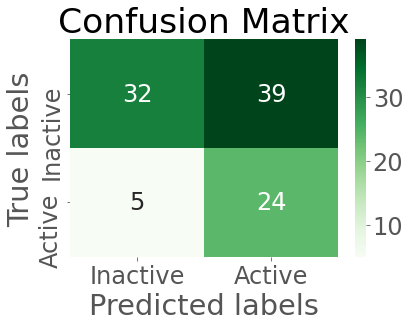

-----------> Calculating with fold 2 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 1 0 0 0 1 1 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0
 0 0 1 0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 1 0 1 1 0 0 0 0 0 0 1 0
 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0 0 1 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 0 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1
 0 0 0 1 0 0 0 1 1 1 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0
 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 1
 0 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0
 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 1 0 0 0 0 0
 1 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 5s - loss: 0.8452 - accuracy: 0.4750 - precision_1: 0.3047 - recall_1: 0.5966
Epoch 2/10
400/400 - 1s - loss: 0.8395 - accuracy: 0.5175 - precision_1: 0.3303 - recall_1: 0.6050
Epoch 3/10
400/400 - 0s - loss: 0.8487 - accuracy: 0.4700 - precision_1: 0.3021 - recall_1: 0.5966
Epoch 4/10
400/400 - 1s - loss: 0.8453 - accuracy: 0.4800 - precision_1: 0.2986 - recall_1: 0.5546
Epoch 5/10
400/400 - 0s - loss: 0.8467 - accuracy: 0.5100 - precision_1: 0.3122 - recall_1: 0.5378
Epoch 6/10
400/400 - 1s - loss: 0.8371 - accuracy: 0.5750 - precision_1: 0.3679 - recall_1: 0.5966
Epoch 7/10
400/400 - 0s - loss: 0.8404 - accuracy: 0.5000 - precision_1: 0.3184 - recall_1: 0.5966
Epoch 8/10
400/400 - 0s - loss: 0.8310 - accuracy: 0.4800 - precision_1: 0.3295 - recall_1: 0.7227
Epoch 9/10
400/400 - 0s - loss: 0.8320 - accuracy: 0.5625 - precision_1: 0.3716 - recall_1: 0.6807
Epoch 10/10
400/400 - 0s - loss: 0.8326 - accuracy: 0.4975 - precision_1: 0.3360 - recal

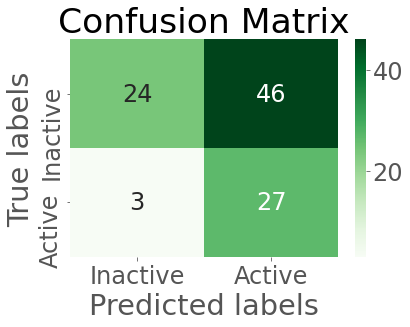

-----------> Calculating with fold 3 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 0 0
 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0
 1 0 1 0 0 0 1 0 0 0 0 1 1 0 0 1 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 1 1 0 1 1 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 1 0 1 0
 0 1 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 1 0 1 0 0 1 1 0 0
 1 0 0 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 1 0 1 0 1 0 1 0 0 0 1 0 0 1 1 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 0
 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 1 1 0 1 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 1 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 3s - loss: 0.8480 - accuracy: 0.6050 - precision_2: 0.3107 - recall_2: 0.2689
Epoch 2/10
400/400 - 0s - loss: 0.8440 - accuracy: 0.6025 - precision_2: 0.3592 - recall_2: 0.4286
Epoch 3/10
400/400 - 0s - loss: 0.8480 - accuracy: 0.5700 - precision_2: 0.3312 - recall_2: 0.4370
Epoch 4/10
400/400 - 0s - loss: 0.8420 - accuracy: 0.5525 - precision_2: 0.3235 - recall_2: 0.4622
Epoch 5/10
400/400 - 0s - loss: 0.8354 - accuracy: 0.5925 - precision_2: 0.3659 - recall_2: 0.5042
Epoch 6/10
400/400 - 0s - loss: 0.8385 - accuracy: 0.5475 - precision_2: 0.3297 - recall_2: 0.5042
Epoch 7/10
400/400 - 0s - loss: 0.8474 - accuracy: 0.5525 - precision_2: 0.3171 - recall_2: 0.4370
Epoch 8/10
400/400 - 0s - loss: 0.8369 - accuracy: 0.5425 - precision_2: 0.3000 - recall_2: 0.4034
Epoch 9/10
400/400 - 0s - loss: 0.8348 - accuracy: 0.5400 - precision_2: 0.3298 - recall_2: 0.5294
Epoch 10/10
400/400 - 0s - loss: 0.8277 - accuracy: 0.5475 - precision_2: 0.3434 - recal

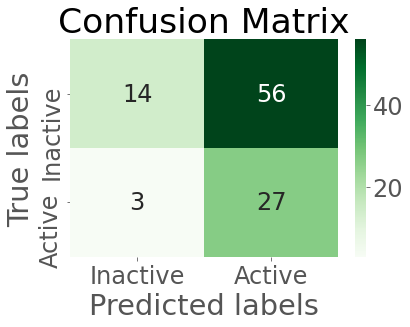

-----------> Calculating with fold 4 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0
 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 1 0 0
 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0 1 1 0 0 1 0 1 0 0 0
 1 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0
 1 0 0 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 0 1 0 0
 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1
 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 5s - loss: 0.8459 - accuracy: 0.4600 - precision_3: 0.2785 - recall_3: 0.5126
Epoch 2/10
400/400 - 0s - loss: 0.8418 - accuracy: 0.4325 - precision_3: 0.2970 - recall_3: 0.6639
Epoch 3/10
400/400 - 0s - loss: 0.8344 - accuracy: 0.4325 - precision_3: 0.3071 - recall_3: 0.7227
Epoch 4/10
400/400 - 0s - loss: 0.8331 - accuracy: 0.4525 - precision_3: 0.3148 - recall_3: 0.7143
Epoch 5/10
400/400 - 0s - loss: 0.8294 - accuracy: 0.4975 - precision_3: 0.3386 - recall_3: 0.7227
Epoch 6/10
400/400 - 0s - loss: 0.8194 - accuracy: 0.5400 - precision_3: 0.3605 - recall_3: 0.7059
Epoch 7/10
400/400 - 0s - loss: 0.8261 - accuracy: 0.5150 - precision_3: 0.3418 - recall_3: 0.6807
Epoch 8/10
400/400 - 0s - loss: 0.8225 - accuracy: 0.4950 - precision_3: 0.3360 - recall_3: 0.7143
Epoch 9/10
400/400 - 0s - loss: 0.8140 - accuracy: 0.5725 - precision_3: 0.3796 - recall_3: 0.6891
Epoch 10/10
400/400 - 0s - loss: 0.8218 - accuracy: 0.5150 - precision_3: 0.3469 - recal

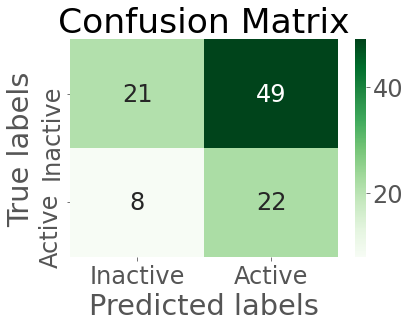

-----------> Calculating with fold 5 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1
 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0
 1 0 0 1 1 0 0 1 1 0 0 1 0 0 0 0 1 1 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 1 0 0
 1 0 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0
 0 1 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 1 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0
 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 1 1 0 0 0 0 0 0
 1 0 0 1 0 1 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 4s - loss: 0.8406 - accuracy: 0.5850 - precision_4: 0.3401 - recall_4: 0.4202
Epoch 2/10
400/400 - 0s - loss: 0.8380 - accuracy: 0.5400 - precision_4: 0.3367 - recall_4: 0.5630
Epoch 3/10
400/400 - 1s - loss: 0.8431 - accuracy: 0.4875 - precision_4: 0.2991 - recall_4: 0.5378
Epoch 4/10
400/400 - 1s - loss: 0.8356 - accuracy: 0.5300 - precision_4: 0.3249 - recall_4: 0.5378
Epoch 5/10
400/400 - 0s - loss: 0.8438 - accuracy: 0.5350 - precision_4: 0.3299 - recall_4: 0.5462
Epoch 6/10
400/400 - 1s - loss: 0.8297 - accuracy: 0.4825 - precision_4: 0.3321 - recall_4: 0.7311
Epoch 7/10
400/400 - 0s - loss: 0.8285 - accuracy: 0.5500 - precision_4: 0.3483 - recall_4: 0.5882
Epoch 8/10
400/400 - 0s - loss: 0.8417 - accuracy: 0.4700 - precision_4: 0.3038 - recall_4: 0.6050
Epoch 9/10
400/400 - 0s - loss: 0.8213 - accuracy: 0.5300 - precision_4: 0.3425 - recall_4: 0.6303
Epoch 10/10
400/400 - 0s - loss: 0.8259 - accuracy: 0.5175 - precision_4: 0.3484 - recal

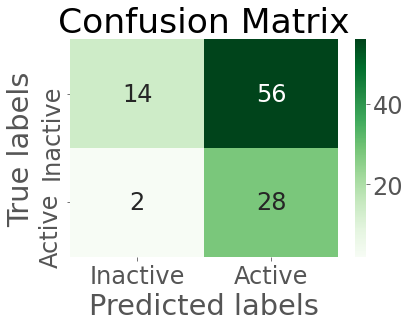

/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1
 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0
 1 0 0 1 1 0 0 1 1 0 0 1 0 0 0 0 1 1 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 1 0 0
 1 0 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0
 0 1 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 1 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0
 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 1 1 0 0 0 0 0 0
 1 0 0 1 0 1 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 1 1 0 1 0 1 0
 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 1 

Train on 500 samples
Epoch 1/10
500/500 - 4s - loss: 0.8476 - accuracy: 0.4040 - precision_5: 0.2959 - recall_5: 0.7248
Epoch 2/10
500/500 - 1s - loss: 0.8409 - accuracy: 0.4020 - precision_5: 0.3067 - recall_5: 0.7987
Epoch 3/10
500/500 - 1s - loss: 0.8380 - accuracy: 0.4160 - precision_5: 0.3133 - recall_5: 0.8054
Epoch 4/10
500/500 - 1s - loss: 0.8410 - accuracy: 0.4000 - precision_5: 0.2997 - recall_5: 0.7584
Epoch 5/10
500/500 - 1s - loss: 0.8374 - accuracy: 0.4300 - precision_5: 0.3057 - recall_5: 0.7181
Epoch 6/10
500/500 - 1s - loss: 0.8375 - accuracy: 0.4320 - precision_5: 0.3109 - recall_5: 0.7450
Epoch 7/10
500/500 - 1s - loss: 0.8357 - accuracy: 0.4460 - precision_5: 0.3171 - recall_5: 0.7450
Epoch 8/10
500/500 - 1s - loss: 0.8343 - accuracy: 0.4580 - precision_5: 0.3106 - recall_5: 0.6711
Epoch 9/10
500/500 - 1s - loss: 0.8275 - accuracy: 0.5300 - precision_5: 0.3557 - recall_5: 0.7114
Epoch 10/10
500/500 - 0s - loss: 0.8138 - accuracy: 0.4780 - precision_5: 0.3453 - recal

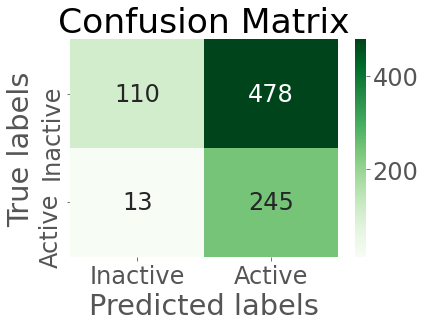

CV fold 4 of split 0 out of 10


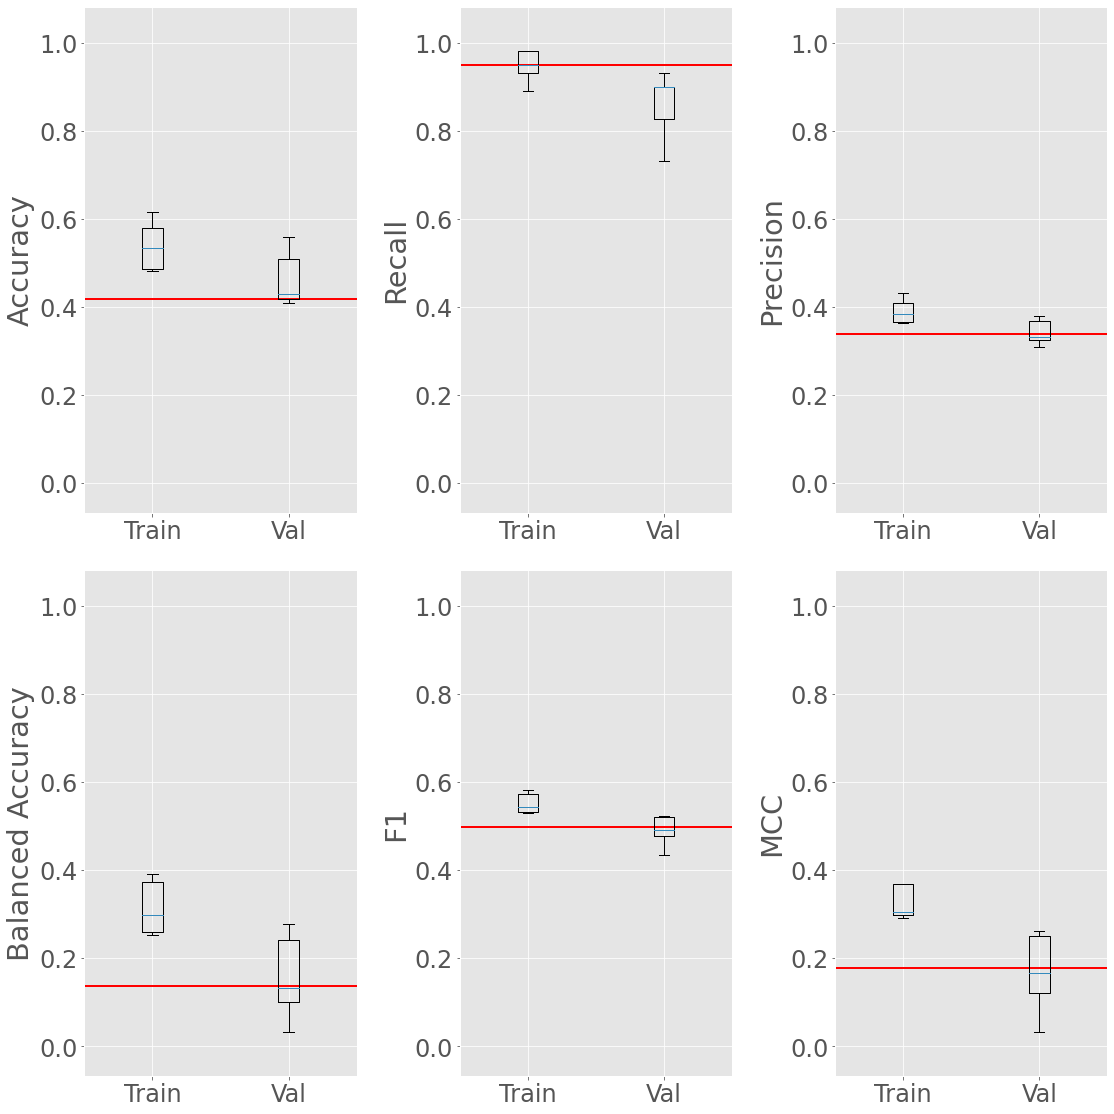

--------------> STARTING SPLIT 2 <--------------
-----------> Calculating with fold 1 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0
 1 0 0 0 0 0 1 1 0 0 1 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1
 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1
 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 1 1 1 0 1 1 0 0 0
 0 1 0 0 1 1 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1
 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0 1 1
 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0
 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1
 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0 1
 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0 1 1 0] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 4s - loss: 0.8478 - accuracy: 0.4375 - precision_6: 0.2696 - recall_6: 0.5210
Epoch 2/10
400/400 - 0s - loss: 0.8488 - accuracy: 0.4100 - precision_6: 0.2873 - recall_6: 0.6639
Epoch 3/10
400/400 - 0s - loss: 0.8330 - accuracy: 0.3900 - precision_6: 0.2964 - recall_6: 0.7647
Epoch 4/10
400/400 - 0s - loss: 0.8241 - accuracy: 0.4800 - precision_6: 0.3428 - recall_6: 0.8151
Epoch 5/10
400/400 - 0s - loss: 0.8301 - accuracy: 0.4175 - precision_6: 0.3048 - recall_6: 0.7479
Epoch 6/10
400/400 - 0s - loss: 0.8291 - accuracy: 0.4525 - precision_6: 0.3201 - recall_6: 0.7479
Epoch 7/10
400/400 - 1s - loss: 0.8103 - accuracy: 0.4775 - precision_6: 0.3346 - recall_6: 0.7647
Epoch 8/10
400/400 - 0s - loss: 0.8039 - accuracy: 0.4925 - precision_6: 0.3421 - recall_6: 0.7647
Epoch 9/10
400/400 - 0s - loss: 0.8180 - accuracy: 0.4875 - precision_6: 0.3346 - recall_6: 0.7311
Epoch 10/10
400/400 - 0s - loss: 0.8068 - accuracy: 0.5650 - precision_6: 0.3922 - recal

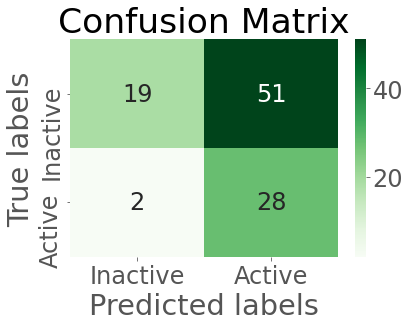

-----------> Calculating with fold 2 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0
 0 1 0 0 0 0 1 1 0 0 1 0 1 1 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1
 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 1 0 0 1
 1 0 0 1 0 1 0 0 1 0 1 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 1 1 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1
 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 1 1 0 0
 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 0 0 0
 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 1 0
 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 1
 1 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1 1 1 1] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 4s - loss: 0.8386 - accuracy: 0.3550 - precision_7: 0.3031 - recall_7: 0.8992
Epoch 2/10
400/400 - 1s - loss: 0.8250 - accuracy: 0.3750 - precision_7: 0.3101 - recall_7: 0.8992
Epoch 3/10
400/400 - 0s - loss: 0.8320 - accuracy: 0.3800 - precision_7: 0.3003 - recall_7: 0.8151
Epoch 4/10
400/400 - 0s - loss: 0.8211 - accuracy: 0.3800 - precision_7: 0.3130 - recall_7: 0.9076
Epoch 5/10
400/400 - 0s - loss: 0.8216 - accuracy: 0.3900 - precision_7: 0.3188 - recall_7: 0.9244
Epoch 6/10
400/400 - 0s - loss: 0.8108 - accuracy: 0.4300 - precision_7: 0.3225 - recall_7: 0.8319
Epoch 7/10
400/400 - 0s - loss: 0.7986 - accuracy: 0.4650 - precision_7: 0.3473 - recall_7: 0.9076
Epoch 8/10
400/400 - 0s - loss: 0.8081 - accuracy: 0.4800 - precision_7: 0.3471 - recall_7: 0.8487
Epoch 9/10
400/400 - 0s - loss: 0.7979 - accuracy: 0.5625 - precision_7: 0.3889 - recall_7: 0.8235
Epoch 10/10
400/400 - 0s - loss: 0.7833 - accuracy: 0.5275 - precision_7: 0.3768 - recal

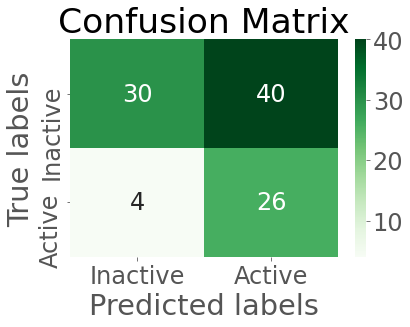

-----------> Calculating with fold 3 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 0 1 1 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 0 1 1 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1
 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1
 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 1 1 0 1 0 0
 1 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0
 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 1
 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 1
 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0
 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0
 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 1 0] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 4s - loss: 0.8498 - accuracy: 0.2975 - precision_8: 0.2975 - recall_8: 1.0000
Epoch 2/10
400/400 - 0s - loss: 0.8446 - accuracy: 0.2975 - precision_8: 0.2975 - recall_8: 1.0000
Epoch 3/10
400/400 - 0s - loss: 0.8328 - accuracy: 0.2975 - precision_8: 0.2975 - recall_8: 1.0000
Epoch 4/10
400/400 - 0s - loss: 0.8341 - accuracy: 0.2975 - precision_8: 0.2965 - recall_8: 0.9916
Epoch 5/10
400/400 - 0s - loss: 0.8299 - accuracy: 0.3175 - precision_8: 0.3015 - recall_8: 0.9832
Epoch 6/10
400/400 - 0s - loss: 0.8222 - accuracy: 0.3300 - precision_8: 0.3075 - recall_8: 1.0000
Epoch 7/10
400/400 - 0s - loss: 0.8187 - accuracy: 0.3600 - precision_8: 0.3173 - recall_8: 1.0000
Epoch 8/10
400/400 - 0s - loss: 0.8176 - accuracy: 0.3575 - precision_8: 0.3145 - recall_8: 0.9832
Epoch 9/10
400/400 - 0s - loss: 0.8153 - accuracy: 0.3825 - precision_8: 0.3212 - recall_8: 0.9664
Epoch 10/10
400/400 - 0s - loss: 0.8036 - accuracy: 0.4200 - precision_8: 0.3333 - recal

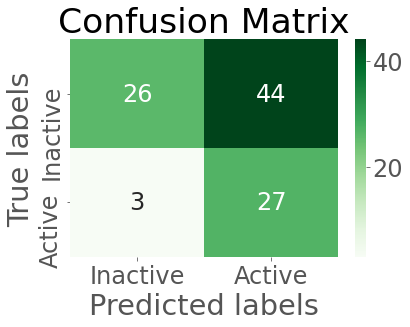

-----------> Calculating with fold 4 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0
 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1
 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0
 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 0 0 1 1 0 0
 0 0 1 1 0 0 1 0 0 1 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0
 0 1 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 1 0 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1
 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 1 1 1 0 0 0 0 0 0 1
 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 1
 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 1
 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 4s - loss: 0.8473 - accuracy: 0.3300 - precision_9: 0.2865 - recall_9: 0.8403
Epoch 2/10
400/400 - 0s - loss: 0.8350 - accuracy: 0.3575 - precision_9: 0.3073 - recall_9: 0.9244
Epoch 3/10
400/400 - 0s - loss: 0.8375 - accuracy: 0.3450 - precision_9: 0.2975 - recall_9: 0.8824
Epoch 4/10
400/400 - 0s - loss: 0.8262 - accuracy: 0.4075 - precision_9: 0.3212 - recall_9: 0.8908
Epoch 5/10
400/400 - 0s - loss: 0.8232 - accuracy: 0.4025 - precision_9: 0.3204 - recall_9: 0.8992
Epoch 6/10
400/400 - 0s - loss: 0.8176 - accuracy: 0.4325 - precision_9: 0.3333 - recall_9: 0.9076
Epoch 7/10
400/400 - 0s - loss: 0.8222 - accuracy: 0.4525 - precision_9: 0.3299 - recall_9: 0.8151
Epoch 8/10
400/400 - 0s - loss: 0.8179 - accuracy: 0.4900 - precision_9: 0.3455 - recall_9: 0.7983
Epoch 9/10
400/400 - 0s - loss: 0.8104 - accuracy: 0.5100 - precision_9: 0.3610 - recall_9: 0.8403
Epoch 10/10
400/400 - 0s - loss: 0.7984 - accuracy: 0.5325 - precision_9: 0.3702 - recal

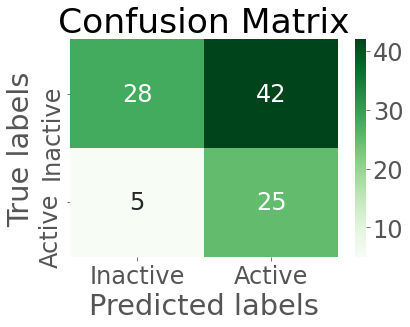

-----------> Calculating with fold 5 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 0 0 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 1 0 0 1 0 1 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0
 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 1 1 0 1 0 0 0 0 0 0
 1 0 1 1 0 1 0 0 1 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0
 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0
 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0
 0 0 1 1 1 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 1 1
 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0
 1 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 1 1 1
 1 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 1 1 0] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 6s - loss: 0.8498 - accuracy: 0.6100 - precision_10: 0.3302 - recall_10: 0.2917
Epoch 2/10
400/400 - 0s - loss: 0.8272 - accuracy: 0.5950 - precision_10: 0.3688 - recall_10: 0.4917
Epoch 3/10
400/400 - 0s - loss: 0.8380 - accuracy: 0.5900 - precision_10: 0.3608 - recall_10: 0.4750
Epoch 4/10
400/400 - 0s - loss: 0.8270 - accuracy: 0.5475 - precision_10: 0.3568 - recall_10: 0.6333
Epoch 5/10
400/400 - 0s - loss: 0.8254 - accuracy: 0.5550 - precision_10: 0.3535 - recall_10: 0.5833
Epoch 6/10
400/400 - 0s - loss: 0.8072 - accuracy: 0.6225 - precision_10: 0.4180 - recall_10: 0.6583
Epoch 7/10
400/400 - 0s - loss: 0.8094 - accuracy: 0.6225 - precision_10: 0.4049 - recall_10: 0.5500
Epoch 8/10
400/400 - 0s - loss: 0.8105 - accuracy: 0.6250 - precision_10: 0.4219 - recall_10: 0.6750
Epoch 9/10
400/400 - 0s - loss: 0.7859 - accuracy: 0.6500 - precision_10: 0.4451 - recall_10: 0.6750
Epoch 10/10
400/400 - 0s - loss: 0.7690 - accuracy: 0.6775 - precision

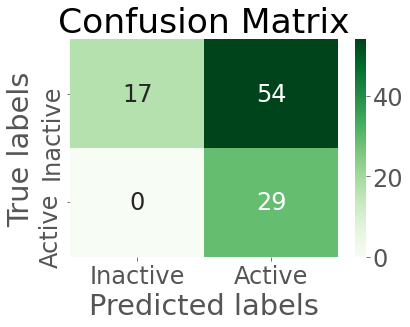

/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 0 0 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 1 0 0 1 0 1 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0
 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 1 1 0 1 0 0 0 0 0 0
 1 0 1 1 0 1 0 0 1 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0
 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0
 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0
 0 0 1 1 1 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 1 1
 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0
 1 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 1 1 1
 1 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 1 0 1
 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 0 1 0 

Train on 500 samples
Epoch 1/10
500/500 - 4s - loss: 0.8427 - accuracy: 0.5600 - precision_11: 0.3216 - recall_11: 0.4295
Epoch 2/10
500/500 - 1s - loss: 0.8381 - accuracy: 0.5460 - precision_11: 0.3465 - recall_11: 0.5906
Epoch 3/10
500/500 - 1s - loss: 0.8305 - accuracy: 0.5020 - precision_11: 0.3264 - recall_11: 0.6309
Epoch 4/10
500/500 - 1s - loss: 0.8223 - accuracy: 0.5440 - precision_11: 0.3594 - recall_11: 0.6779
Epoch 5/10
500/500 - 0s - loss: 0.8235 - accuracy: 0.5280 - precision_11: 0.3452 - recall_11: 0.6510
Epoch 6/10
500/500 - 0s - loss: 0.8099 - accuracy: 0.6000 - precision_11: 0.3992 - recall_11: 0.6779
Epoch 7/10
500/500 - 0s - loss: 0.8024 - accuracy: 0.6000 - precision_11: 0.4118 - recall_11: 0.7987
Epoch 8/10
500/500 - 1s - loss: 0.7895 - accuracy: 0.6620 - precision_11: 0.4587 - recall_11: 0.7450
Epoch 9/10
500/500 - 1s - loss: 0.7706 - accuracy: 0.6800 - precision_11: 0.4781 - recall_11: 0.8054
Epoch 10/10
500/500 - 1s - loss: 0.7599 - accuracy: 0.6680 - precision

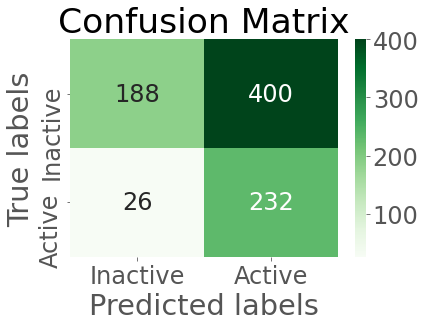

CV fold 4 of split 1 out of 10


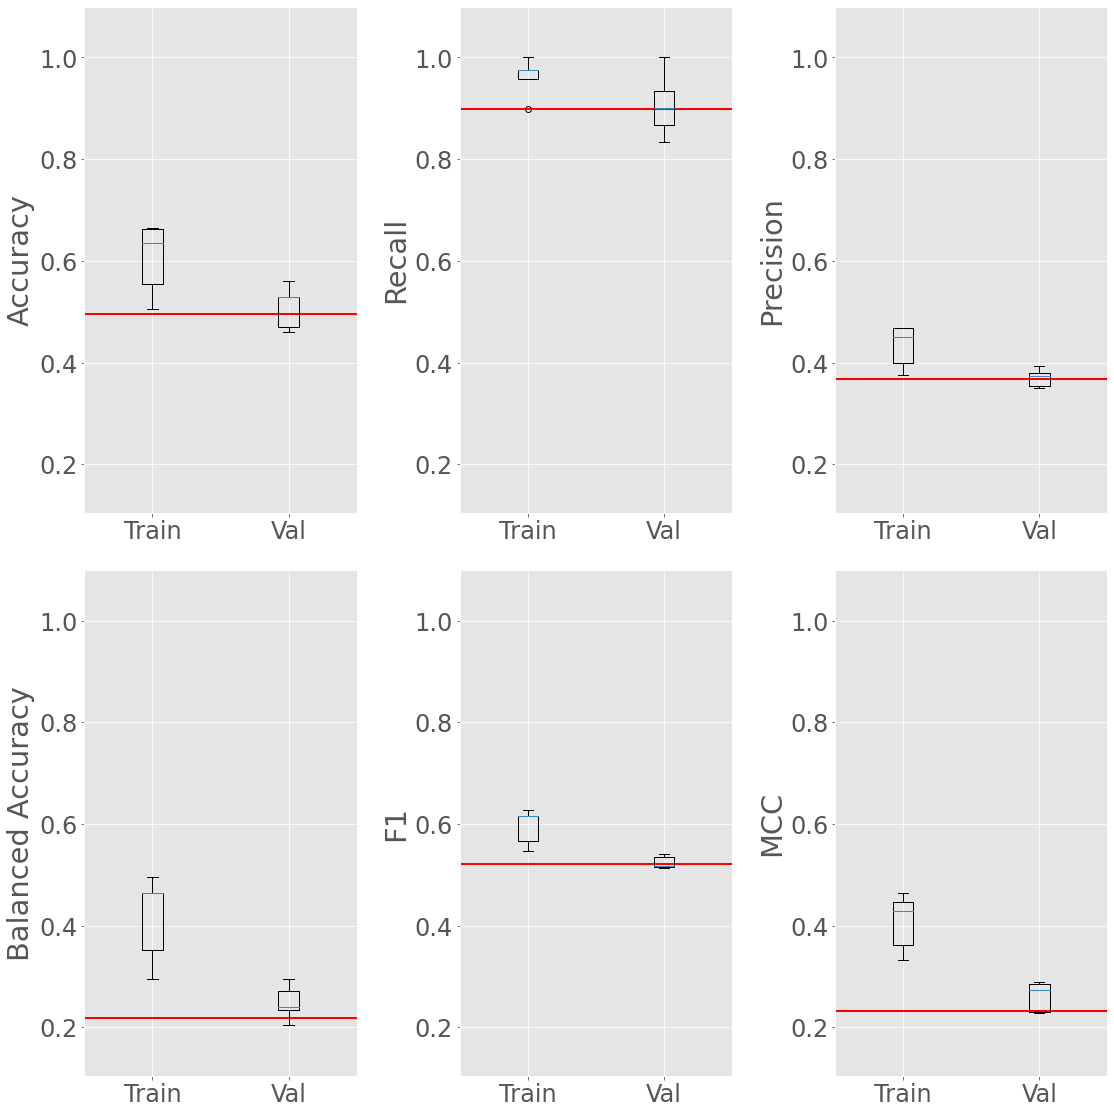

--------------> STARTING SPLIT 3 <--------------
-----------> Calculating with fold 1 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 1 1
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 1 1 0 0 1 0 0 1 1 1 1
 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 1 1 1 0 0 0 0 0 1 0 1 1 1 0 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0
 0 1 1 0 0 1 0 1 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 1 1 0 1 0 1 1 0 1 1 0 1 0 0
 0 0 1 0 1 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 0 1
 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 4s - loss: 0.8630 - accuracy: 0.6300 - precision_12: 0.2041 - recall_12: 0.0840
Epoch 2/10
400/400 - 0s - loss: 0.8499 - accuracy: 0.6225 - precision_12: 0.3140 - recall_12: 0.2269
Epoch 3/10
400/400 - 0s - loss: 0.8368 - accuracy: 0.6050 - precision_12: 0.3388 - recall_12: 0.3445
Epoch 4/10
400/400 - 0s - loss: 0.8373 - accuracy: 0.6075 - precision_12: 0.3623 - recall_12: 0.4202
Epoch 5/10
400/400 - 0s - loss: 0.8472 - accuracy: 0.5400 - precision_12: 0.2519 - recall_12: 0.2773
Epoch 6/10
400/400 - 0s - loss: 0.8365 - accuracy: 0.5700 - precision_12: 0.3413 - recall_12: 0.4790
Epoch 7/10
400/400 - 0s - loss: 0.8354 - accuracy: 0.5750 - precision_12: 0.3559 - recall_12: 0.5294
Epoch 8/10
400/400 - 0s - loss: 0.8231 - accuracy: 0.6250 - precision_12: 0.4037 - recall_12: 0.5462
Epoch 9/10
400/400 - 0s - loss: 0.8263 - accuracy: 0.5525 - precision_12: 0.3295 - recall_12: 0.4874
Epoch 10/10
400/400 - 0s - loss: 0.8271 - accuracy: 0.6000 - precision

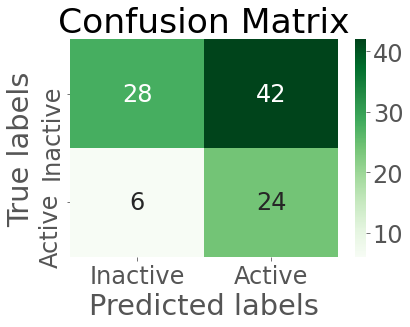

-----------> Calculating with fold 2 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 0 1 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 0 1 1 1
 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 1 1 1 0 0 1 0
 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1
 0 1 1 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1
 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 1 1 1 0
 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 1 1 0 1 0 0 0 1 0 0
 0 1 0 1 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0
 1 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 4s - loss: 0.8439 - accuracy: 0.6200 - precision_13: 0.3103 - recall_13: 0.2269
Epoch 2/10
400/400 - 0s - loss: 0.8374 - accuracy: 0.5850 - precision_13: 0.3484 - recall_13: 0.4538
Epoch 3/10
400/400 - 0s - loss: 0.8400 - accuracy: 0.5525 - precision_13: 0.3333 - recall_13: 0.5042
Epoch 4/10
400/400 - 0s - loss: 0.8254 - accuracy: 0.5825 - precision_13: 0.3737 - recall_13: 0.5966
Epoch 5/10
400/400 - 0s - loss: 0.8403 - accuracy: 0.4900 - precision_13: 0.2864 - recall_13: 0.4790
Epoch 6/10
400/400 - 0s - loss: 0.8278 - accuracy: 0.5275 - precision_13: 0.3438 - recall_13: 0.6471
Epoch 7/10
400/400 - 0s - loss: 0.8236 - accuracy: 0.5750 - precision_13: 0.3731 - recall_13: 0.6303
Epoch 8/10
400/400 - 0s - loss: 0.8197 - accuracy: 0.6075 - precision_13: 0.3869 - recall_13: 0.5462
Epoch 9/10
400/400 - 0s - loss: 0.8112 - accuracy: 0.6375 - precision_13: 0.4198 - recall_13: 0.5714
Epoch 10/10
400/400 - 1s - loss: 0.8099 - accuracy: 0.6550 - precision

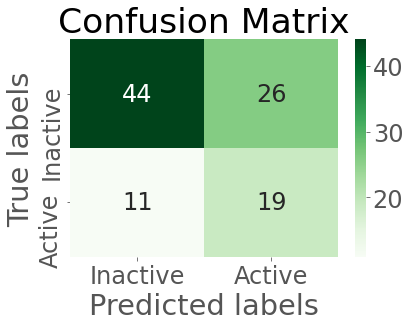

-----------> Calculating with fold 3 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 1 0 1 1 0 1 0 0 1 0 0 1
 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0
 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0
 0 1 0 1 1 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1
 0 0 1 0 1 1 0 1 1 0 1 0 0 1 0 0 0 0 1 1 0 1 0 1 1 1 0 1 0 0 0 0 1 0 0 0 1
 0 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1
 1 1 1 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 5s - loss: 0.8473 - accuracy: 0.6625 - precision_14: 0.3710 - recall_14: 0.1933
Epoch 2/10
400/400 - 1s - loss: 0.8413 - accuracy: 0.6200 - precision_14: 0.3187 - recall_14: 0.2437
Epoch 3/10
400/400 - 0s - loss: 0.8308 - accuracy: 0.6050 - precision_14: 0.3673 - recall_14: 0.4538
Epoch 4/10
400/400 - 0s - loss: 0.8300 - accuracy: 0.6500 - precision_14: 0.4160 - recall_14: 0.4370
Epoch 5/10
400/400 - 1s - loss: 0.8346 - accuracy: 0.6625 - precision_14: 0.4333 - recall_14: 0.4370
Epoch 6/10
400/400 - 1s - loss: 0.8274 - accuracy: 0.6450 - precision_14: 0.4184 - recall_14: 0.4958
Epoch 7/10
400/400 - 1s - loss: 0.8314 - accuracy: 0.5800 - precision_14: 0.3567 - recall_14: 0.5126
Epoch 8/10
400/400 - 0s - loss: 0.8219 - accuracy: 0.6250 - precision_14: 0.3987 - recall_14: 0.5126
Epoch 9/10
400/400 - 0s - loss: 0.8247 - accuracy: 0.6000 - precision_14: 0.3829 - recall_14: 0.5630
Epoch 10/10
400/400 - 1s - loss: 0.8159 - accuracy: 0.6300 - precision

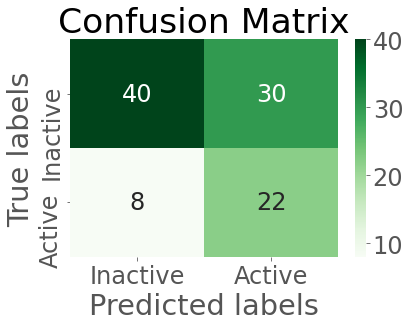

-----------> Calculating with fold 4 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 0 1 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0
 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 0 0 1 1 0 0 1 0
 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 1 1 1 0 1
 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 1 0 1
 1 0 1 1 0 0 1 0 0 1 0 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 1 1 0 0 0 0 0 0
 1 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1
 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 4s - loss: 0.8402 - accuracy: 0.5375 - precision_15: 0.3382 - recall_15: 0.5798
Epoch 2/10
400/400 - 1s - loss: 0.8351 - accuracy: 0.4900 - precision_15: 0.3160 - recall_15: 0.6134
Epoch 3/10
400/400 - 0s - loss: 0.8304 - accuracy: 0.5300 - precision_15: 0.3395 - recall_15: 0.6134
Epoch 4/10
400/400 - 0s - loss: 0.8202 - accuracy: 0.4850 - precision_15: 0.3333 - recall_15: 0.7311
Epoch 5/10
400/400 - 0s - loss: 0.8238 - accuracy: 0.5600 - precision_15: 0.3755 - recall_15: 0.7227
Epoch 6/10
400/400 - 0s - loss: 0.8130 - accuracy: 0.5675 - precision_15: 0.3784 - recall_15: 0.7059
Epoch 7/10
400/400 - 1s - loss: 0.8147 - accuracy: 0.5675 - precision_15: 0.3676 - recall_15: 0.6303
Epoch 8/10
400/400 - 0s - loss: 0.7904 - accuracy: 0.5725 - precision_15: 0.3952 - recall_15: 0.8235
Epoch 9/10
400/400 - 0s - loss: 0.7838 - accuracy: 0.6050 - precision_15: 0.4093 - recall_15: 0.7395
Epoch 10/10
400/400 - 0s - loss: 0.7827 - accuracy: 0.6100 - precision

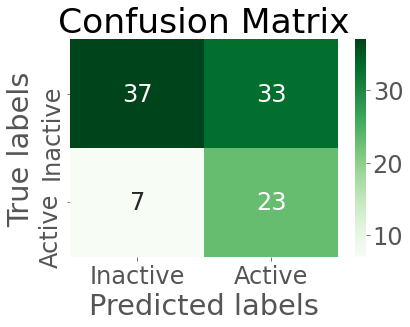

-----------> Calculating with fold 5 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 0 0 0 1 0 1 0 0 1
 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 0 1 1 0 0 0 1
 1 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0
 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 1 0 1 1 0 0 1 0 0 0
 0 0 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 1
 1 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0
 0 0 1 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1
 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 4s - loss: 0.8548 - accuracy: 0.6975 - precision_16: 0.4286 - recall_16: 0.0250
Epoch 2/10
400/400 - 0s - loss: 0.8468 - accuracy: 0.6675 - precision_16: 0.3243 - recall_16: 0.1000
Epoch 3/10
400/400 - 1s - loss: 0.8396 - accuracy: 0.6525 - precision_16: 0.3137 - recall_16: 0.1333
Epoch 4/10
400/400 - 0s - loss: 0.8394 - accuracy: 0.6475 - precision_16: 0.3562 - recall_16: 0.2167
Epoch 5/10
400/400 - 0s - loss: 0.8365 - accuracy: 0.6475 - precision_16: 0.3735 - recall_16: 0.2583
Epoch 6/10
400/400 - 0s - loss: 0.8267 - accuracy: 0.6775 - precision_16: 0.4400 - recall_16: 0.2750
Epoch 7/10
400/400 - 0s - loss: 0.8244 - accuracy: 0.6850 - precision_16: 0.4625 - recall_16: 0.3083
Epoch 8/10
400/400 - 0s - loss: 0.8285 - accuracy: 0.6500 - precision_16: 0.3913 - recall_16: 0.3000
Epoch 9/10
400/400 - 0s - loss: 0.8153 - accuracy: 0.7200 - precision_16: 0.5526 - recall_16: 0.3500
Epoch 10/10
400/400 - 0s - loss: 0.8022 - accuracy: 0.7000 - precision

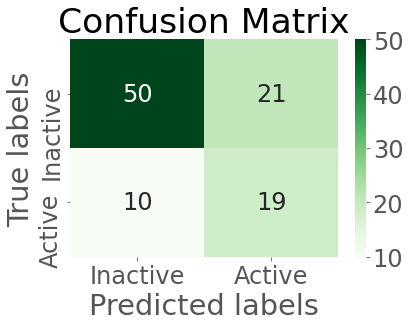

/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 0 0 0 1 0 1 0 0 1
 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 0 1 1 0 0 0 1
 1 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0
 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 1 0 1 1 0 0 1 0 0 0
 0 0 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 1
 1 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0
 0 0 1 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1
 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0
 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 

Train on 500 samples
Epoch 1/10
500/500 - 4s - loss: 0.8804 - accuracy: 0.6960 - precision_17: 0.0000e+00 - recall_17: 0.0000e+00
Epoch 2/10
500/500 - 1s - loss: 0.8494 - accuracy: 0.6940 - precision_17: 0.3889 - recall_17: 0.0470
Epoch 3/10
500/500 - 0s - loss: 0.8431 - accuracy: 0.6720 - precision_17: 0.2581 - recall_17: 0.0537
Epoch 4/10
500/500 - 0s - loss: 0.8427 - accuracy: 0.6840 - precision_17: 0.3784 - recall_17: 0.0940
Epoch 5/10
500/500 - 0s - loss: 0.8354 - accuracy: 0.6920 - precision_17: 0.4510 - recall_17: 0.1544
Epoch 6/10
500/500 - 1s - loss: 0.8336 - accuracy: 0.6880 - precision_17: 0.4364 - recall_17: 0.1611
Epoch 7/10
500/500 - 1s - loss: 0.8318 - accuracy: 0.6900 - precision_17: 0.4375 - recall_17: 0.1409
Epoch 8/10
500/500 - 1s - loss: 0.8371 - accuracy: 0.6640 - precision_17: 0.3662 - recall_17: 0.1745
Epoch 9/10
500/500 - 1s - loss: 0.8233 - accuracy: 0.6840 - precision_17: 0.4444 - recall_17: 0.2416
Epoch 10/10
500/500 - 0s - loss: 0.8241 - accuracy: 0.6780 - p

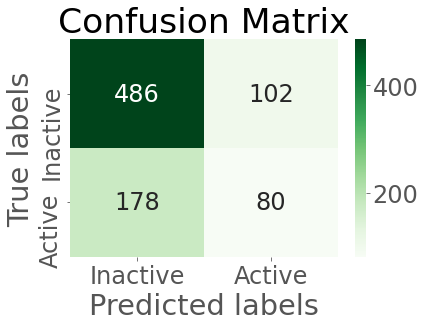

CV fold 4 of split 2 out of 10


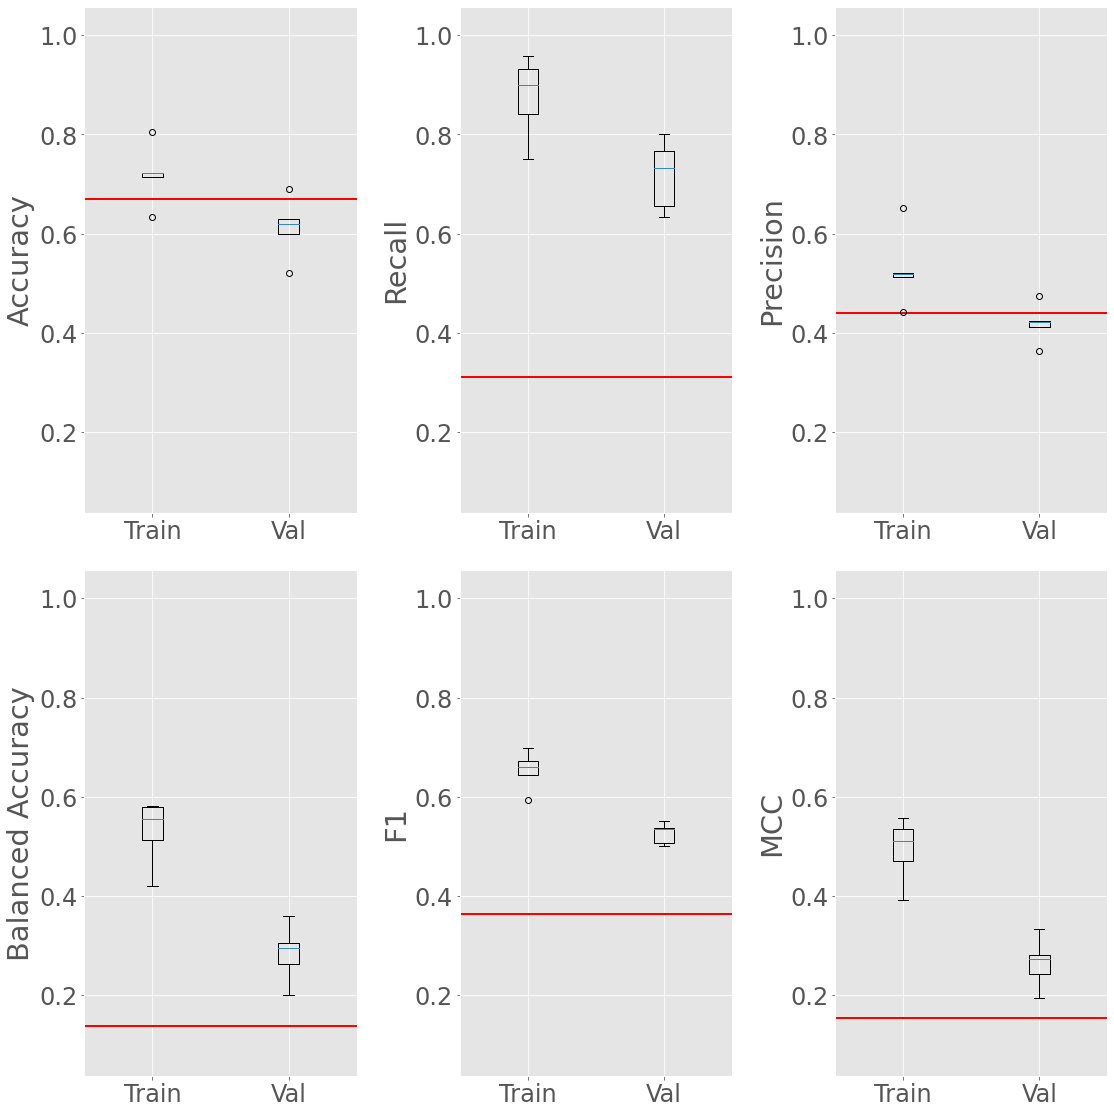

--------------> STARTING SPLIT 4 <--------------
-----------> Calculating with fold 1 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0 1 0
 0 1 1 1 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0
 0 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 1 1 0 0 0 0 0
 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0
 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1
 0 1 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 1 0 0
 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 1 0
 1 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 0 1 0 0 1 0] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 5s - loss: 0.8378 - accuracy: 0.6300 - precision_18: 0.3986 - recall_18: 0.4583
Epoch 2/10
400/400 - 0s - loss: 0.8381 - accuracy: 0.5475 - precision_18: 0.3498 - recall_18: 0.5917
Epoch 3/10
400/400 - 0s - loss: 0.8369 - accuracy: 0.5875 - precision_18: 0.3770 - recall_18: 0.5750
Epoch 4/10
400/400 - 0s - loss: 0.8358 - accuracy: 0.4925 - precision_18: 0.3264 - recall_18: 0.6500
Epoch 5/10
400/400 - 0s - loss: 0.8278 - accuracy: 0.5850 - precision_18: 0.3883 - recall_18: 0.6667
Epoch 6/10
400/400 - 0s - loss: 0.8362 - accuracy: 0.5100 - precision_18: 0.3390 - recall_18: 0.6667
Epoch 7/10
400/400 - 0s - loss: 0.8284 - accuracy: 0.5200 - precision_18: 0.3475 - recall_18: 0.6833
Epoch 8/10
400/400 - 0s - loss: 0.8200 - accuracy: 0.6000 - precision_18: 0.4029 - recall_18: 0.6917
Epoch 9/10
400/400 - 0s - loss: 0.8149 - accuracy: 0.5825 - precision_18: 0.4008 - recall_18: 0.7917
Epoch 10/10
400/400 - 0s - loss: 0.8135 - accuracy: 0.6100 - precision

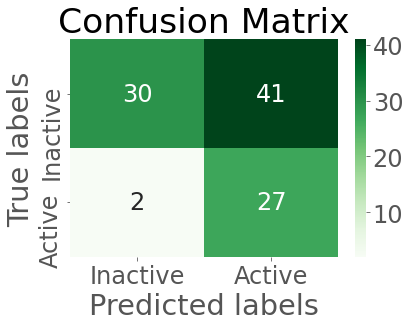

-----------> Calculating with fold 2 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 1 0 0 0 1 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1 1
 0 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0
 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 1 0 1 0 1 0
 0 1 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0
 1 0 1 1 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0
 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 0 1 0 1
 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1
 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 0 0 1 0 0 1 1 0 0 1 0] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 4s - loss: 0.8639 - accuracy: 0.5775 - precision_19: 0.3016 - recall_19: 0.3193
Epoch 2/10
400/400 - 0s - loss: 0.8515 - accuracy: 0.5250 - precision_19: 0.3017 - recall_19: 0.4538
Epoch 3/10
400/400 - 0s - loss: 0.8420 - accuracy: 0.5225 - precision_19: 0.2978 - recall_19: 0.4454
Epoch 4/10
400/400 - 0s - loss: 0.8346 - accuracy: 0.5475 - precision_19: 0.3450 - recall_19: 0.5798
Epoch 5/10
400/400 - 0s - loss: 0.8345 - accuracy: 0.5325 - precision_19: 0.3426 - recall_19: 0.6218
Epoch 6/10
400/400 - 0s - loss: 0.8432 - accuracy: 0.5025 - precision_19: 0.2917 - recall_19: 0.4706
Epoch 7/10
400/400 - 0s - loss: 0.8151 - accuracy: 0.6025 - precision_19: 0.4038 - recall_19: 0.7059
Epoch 8/10
400/400 - 0s - loss: 0.8296 - accuracy: 0.5425 - precision_19: 0.3519 - recall_19: 0.6387
Epoch 9/10
400/400 - 0s - loss: 0.8186 - accuracy: 0.6000 - precision_19: 0.3959 - recall_19: 0.6555
Epoch 10/10
400/400 - 0s - loss: 0.8161 - accuracy: 0.5725 - precision

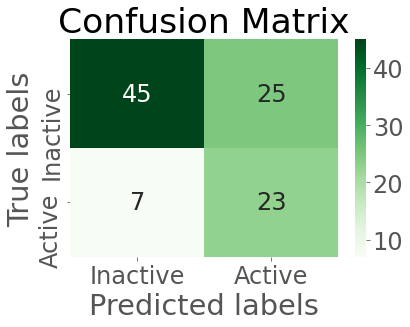

-----------> Calculating with fold 3 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0
 1 0 0 1 1 0 0 1 0 0 0 1 1 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1
 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0 0
 0 0 1 0 0 1 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 1
 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0
 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1 0 1
 1 0 0 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 1 0 0 0 1 0 1 0 0 0 1 1 0 1 0 1
 1 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 5s - loss: 0.8522 - accuracy: 0.4300 - precision_20: 0.3032 - recall_20: 0.7059
Epoch 2/10
400/400 - 0s - loss: 0.8461 - accuracy: 0.4350 - precision_20: 0.3069 - recall_20: 0.7143
Epoch 3/10
400/400 - 0s - loss: 0.8476 - accuracy: 0.3850 - precision_20: 0.2639 - recall_20: 0.5966
Epoch 4/10
400/400 - 0s - loss: 0.8461 - accuracy: 0.4150 - precision_20: 0.2909 - recall_20: 0.6723
Epoch 5/10
400/400 - 1s - loss: 0.8353 - accuracy: 0.4925 - precision_20: 0.3264 - recall_20: 0.6639
Epoch 6/10
400/400 - 0s - loss: 0.8399 - accuracy: 0.4500 - precision_20: 0.2972 - recall_20: 0.6218
Epoch 7/10
400/400 - 0s - loss: 0.8309 - accuracy: 0.4575 - precision_20: 0.3086 - recall_20: 0.6639
Epoch 8/10
400/400 - 0s - loss: 0.8246 - accuracy: 0.5125 - precision_20: 0.3527 - recall_20: 0.7647
Epoch 9/10
400/400 - 0s - loss: 0.8313 - accuracy: 0.4475 - precision_20: 0.3217 - recall_20: 0.7731
Epoch 10/10
400/400 - 0s - loss: 0.8224 - accuracy: 0.4650 - precision

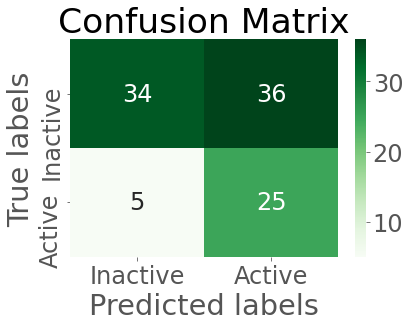

-----------> Calculating with fold 4 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0
 0 1 0 1 1 0 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0
 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 1 1 0 1 0 1 0 0 0 0 0
 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 1 0 0 0
 0 1 0 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0
 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1
 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0 0
 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0
 1 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 0 1
 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 0 1 0 0 0] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 5s - loss: 0.8420 - accuracy: 0.3050 - precision_21: 0.2935 - recall_21: 0.9496
Epoch 2/10
400/400 - 1s - loss: 0.8428 - accuracy: 0.3275 - precision_21: 0.2962 - recall_21: 0.9160
Epoch 3/10
400/400 - 1s - loss: 0.8413 - accuracy: 0.3050 - precision_21: 0.2846 - recall_21: 0.8824
Epoch 4/10
400/400 - 1s - loss: 0.8398 - accuracy: 0.3350 - precision_21: 0.2918 - recall_21: 0.8655
Epoch 5/10
400/400 - 0s - loss: 0.8302 - accuracy: 0.3825 - precision_21: 0.3150 - recall_21: 0.9160
Epoch 6/10
400/400 - 0s - loss: 0.8357 - accuracy: 0.4025 - precision_21: 0.3225 - recall_21: 0.9160
Epoch 7/10
400/400 - 0s - loss: 0.8347 - accuracy: 0.3975 - precision_21: 0.3140 - recall_21: 0.8655
Epoch 8/10
400/400 - 0s - loss: 0.8325 - accuracy: 0.3525 - precision_21: 0.2977 - recall_21: 0.8655
Epoch 9/10
400/400 - 0s - loss: 0.8357 - accuracy: 0.3975 - precision_21: 0.3032 - recall_21: 0.7899
Epoch 10/10
400/400 - 0s - loss: 0.8303 - accuracy: 0.4375 - precision

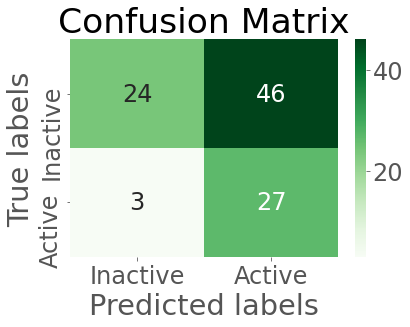

-----------> Calculating with fold 5 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0
 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 1 0 1 0 1 1 0 1 0 1 0 0 1
 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 1 0
 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 1
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1
 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 1 1 1 0 1 0 0 1 0 0 0 1 1 0 0 0 1 1
 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 1 0 1 0 1 0] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 6s - loss: 0.8605 - accuracy: 0.6225 - precision_22: 0.2241 - recall_22: 0.1092
Epoch 2/10
400/400 - 1s - loss: 0.8504 - accuracy: 0.6075 - precision_22: 0.2791 - recall_22: 0.2017
Epoch 3/10
400/400 - 1s - loss: 0.8400 - accuracy: 0.5850 - precision_22: 0.3401 - recall_22: 0.4202
Epoch 4/10
400/400 - 1s - loss: 0.8378 - accuracy: 0.5500 - precision_22: 0.3129 - recall_22: 0.4286
Epoch 5/10
400/400 - 1s - loss: 0.8331 - accuracy: 0.5750 - precision_22: 0.3543 - recall_22: 0.5210
Epoch 6/10
400/400 - 1s - loss: 0.8355 - accuracy: 0.5200 - precision_22: 0.3363 - recall_22: 0.6303
Epoch 7/10
400/400 - 1s - loss: 0.8316 - accuracy: 0.5450 - precision_22: 0.3535 - recall_22: 0.6387
Epoch 8/10
400/400 - 1s - loss: 0.8288 - accuracy: 0.5450 - precision_22: 0.3507 - recall_22: 0.6218
Epoch 9/10
400/400 - 1s - loss: 0.8221 - accuracy: 0.5375 - precision_22: 0.3540 - recall_22: 0.6723
Epoch 10/10
400/400 - 0s - loss: 0.8193 - accuracy: 0.5425 - precision

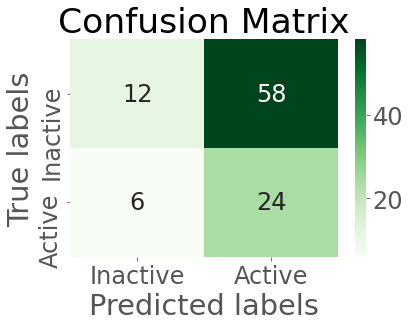

/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0
 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 1 0 1 0 1 1 0 1 0 1 0 0 1
 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 1 0
 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 1
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1
 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 1 1 1 0 1 0 0 1 0 0 0 1 1 0 0 0 1 1
 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1
 1 1 0 0 0 1 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 

Train on 500 samples
Epoch 1/10
500/500 - 4s - loss: 0.8479 - accuracy: 0.4320 - precision_23: 0.2961 - recall_23: 0.6577
Epoch 2/10
500/500 - 1s - loss: 0.8428 - accuracy: 0.4060 - precision_23: 0.2921 - recall_23: 0.6980
Epoch 3/10
500/500 - 1s - loss: 0.8383 - accuracy: 0.4160 - precision_23: 0.3073 - recall_23: 0.7651
Epoch 4/10
500/500 - 0s - loss: 0.8332 - accuracy: 0.4400 - precision_23: 0.3215 - recall_23: 0.7919
Epoch 5/10
500/500 - 1s - loss: 0.8370 - accuracy: 0.4220 - precision_23: 0.2965 - recall_23: 0.6846
Epoch 6/10
500/500 - 1s - loss: 0.8289 - accuracy: 0.4520 - precision_23: 0.3297 - recall_23: 0.8121
Epoch 7/10
500/500 - 1s - loss: 0.8229 - accuracy: 0.4800 - precision_23: 0.3419 - recall_23: 0.8054
Epoch 8/10
500/500 - 0s - loss: 0.8216 - accuracy: 0.4840 - precision_23: 0.3429 - recall_23: 0.7987
Epoch 9/10
500/500 - 0s - loss: 0.8139 - accuracy: 0.5360 - precision_23: 0.3666 - recall_23: 0.7651
Epoch 10/10
500/500 - 1s - loss: 0.8158 - accuracy: 0.5440 - precision

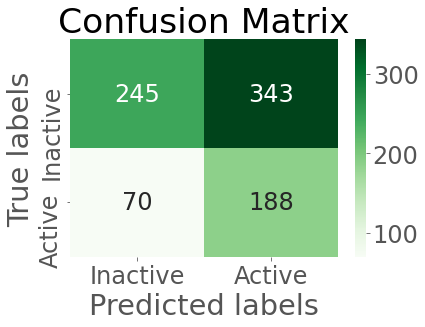

CV fold 4 of split 3 out of 10


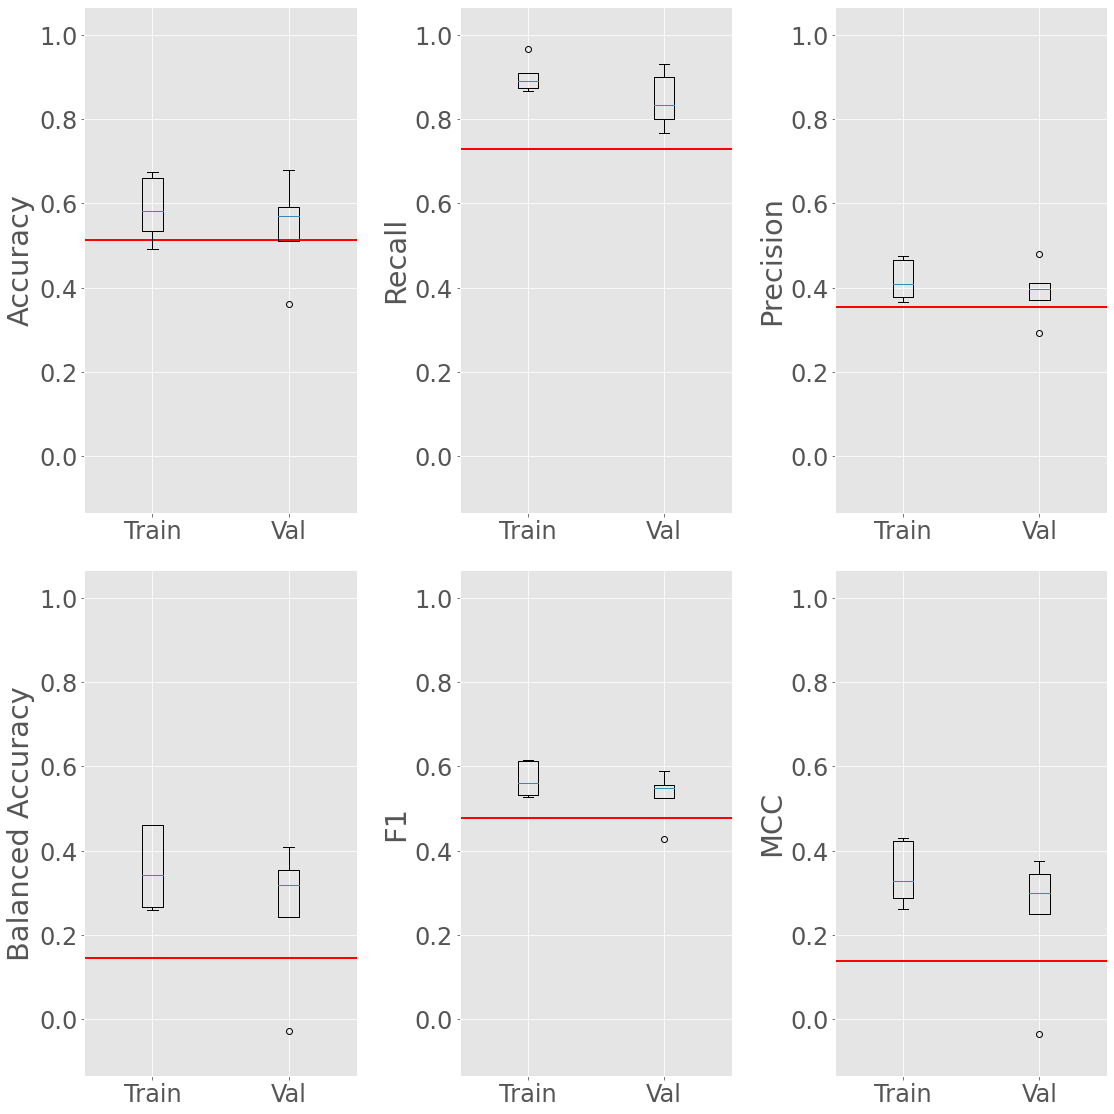

--------------> STARTING SPLIT 5 <--------------
-----------> Calculating with fold 1 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0
 0 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 0 1 0 1 1 1 0 0 0 1 0 1 1 0 1 1 0 1 1 0 0
 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 1 0
 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1
 1 1 0 1 1 0 0 1 1 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0
 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0
 0 0 1 1 1 0 0 0 0 1 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0
 1 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 0 1 1
 1 0 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 6s - loss: 0.8470 - accuracy: 0.3100 - precision_24: 0.2937 - recall_24: 0.9250
Epoch 2/10
400/400 - 1s - loss: 0.8431 - accuracy: 0.3525 - precision_24: 0.3106 - recall_24: 0.9500
Epoch 3/10
400/400 - 1s - loss: 0.8443 - accuracy: 0.3275 - precision_24: 0.2970 - recall_24: 0.9083
Epoch 4/10
400/400 - 0s - loss: 0.8303 - accuracy: 0.3725 - precision_24: 0.3186 - recall_24: 0.9583
Epoch 5/10
400/400 - 1s - loss: 0.8349 - accuracy: 0.3725 - precision_24: 0.3112 - recall_24: 0.9000
Epoch 6/10
400/400 - 1s - loss: 0.8267 - accuracy: 0.3600 - precision_24: 0.3101 - recall_24: 0.9250
Epoch 7/10
400/400 - 0s - loss: 0.8253 - accuracy: 0.3775 - precision_24: 0.3173 - recall_24: 0.9333
Epoch 8/10
400/400 - 1s - loss: 0.8253 - accuracy: 0.3975 - precision_24: 0.3236 - recall_24: 0.9250
Epoch 9/10
400/400 - 1s - loss: 0.8114 - accuracy: 0.4175 - precision_24: 0.3293 - recall_24: 0.9083
Epoch 10/10
400/400 - 1s - loss: 0.8071 - accuracy: 0.4300 - precision

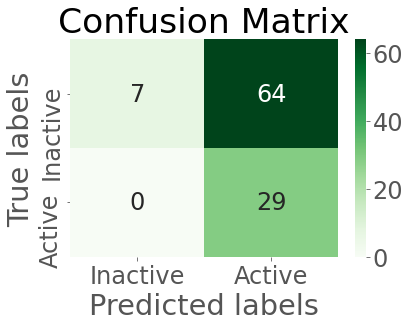

-----------> Calculating with fold 2 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 1 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0
 1 0 1 0 1 1 0 0 0 0 1 1 1 1 0 0 1 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0
 0 0 0 1 0 0 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 1 0
 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0
 0 0 0 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0
 1 1 0 0 0 1 1 1 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 1
 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1
 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 4s - loss: 0.8584 - accuracy: 0.2975 - precision_25: 0.2975 - recall_25: 1.0000
Epoch 2/10
400/400 - 0s - loss: 0.8401 - accuracy: 0.3075 - precision_25: 0.2995 - recall_25: 0.9916
Epoch 3/10
400/400 - 0s - loss: 0.8365 - accuracy: 0.2950 - precision_25: 0.2937 - recall_25: 0.9748
Epoch 4/10
400/400 - 0s - loss: 0.8306 - accuracy: 0.3150 - precision_25: 0.3008 - recall_25: 0.9832
Epoch 5/10
400/400 - 0s - loss: 0.8278 - accuracy: 0.3250 - precision_25: 0.2997 - recall_25: 0.9496
Epoch 6/10
400/400 - 0s - loss: 0.8268 - accuracy: 0.3550 - precision_25: 0.3127 - recall_25: 0.9748
Epoch 7/10
400/400 - 0s - loss: 0.8246 - accuracy: 0.3650 - precision_25: 0.3161 - recall_25: 0.9748
Epoch 8/10
400/400 - 0s - loss: 0.8154 - accuracy: 0.4100 - precision_25: 0.3294 - recall_25: 0.9496
Epoch 9/10
400/400 - 0s - loss: 0.8136 - accuracy: 0.4325 - precision_25: 0.3344 - recall_25: 0.9160
Epoch 10/10
400/400 - 0s - loss: 0.8034 - accuracy: 0.4300 - precision

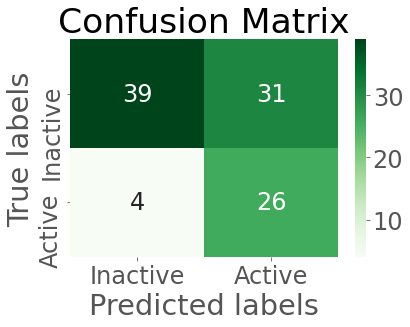

-----------> Calculating with fold 3 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0
 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 1 0 1 0 1 1 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0
 1 1 1 0 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 1
 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0
 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0
 0 0 1 0 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1
 1 0 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0
 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 1 1 0 1 0 0 0 1
 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 0 0] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 6s - loss: 0.8359 - accuracy: 0.4000 - precision_26: 0.3042 - recall_26: 0.7899
Epoch 2/10
400/400 - 0s - loss: 0.8281 - accuracy: 0.4200 - precision_26: 0.3229 - recall_26: 0.8655
Epoch 3/10
400/400 - 0s - loss: 0.8213 - accuracy: 0.3800 - precision_26: 0.2991 - recall_26: 0.8067
Epoch 4/10
400/400 - 0s - loss: 0.8286 - accuracy: 0.4400 - precision_26: 0.3196 - recall_26: 0.7815
Epoch 5/10
400/400 - 0s - loss: 0.8239 - accuracy: 0.4575 - precision_26: 0.3345 - recall_26: 0.8319
Epoch 6/10
400/400 - 0s - loss: 0.8161 - accuracy: 0.4675 - precision_26: 0.3368 - recall_26: 0.8151
Epoch 7/10
400/400 - 0s - loss: 0.8216 - accuracy: 0.4975 - precision_26: 0.3447 - recall_26: 0.7647
Epoch 8/10
400/400 - 0s - loss: 0.8044 - accuracy: 0.4925 - precision_26: 0.3456 - recall_26: 0.7899
Epoch 9/10
400/400 - 1s - loss: 0.7943 - accuracy: 0.5175 - precision_26: 0.3566 - recall_26: 0.7731
Epoch 10/10
400/400 - 0s - loss: 0.7951 - accuracy: 0.5925 - precision

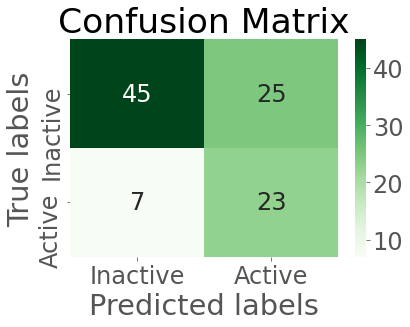

-----------> Calculating with fold 4 <----------
<class 'list'>


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0
 0 1 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 0 0 1 0
 1 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0
 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1
 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 1 1 0 0 1 1 0 0
 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0
 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 1 0 1 0
 0 1 0 1 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 0
 0 1 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 1] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 5s - loss: 2.5264 - accuracy: 0.6175 - precision_27: 0.3023 - recall_27: 0.2185
Epoch 2/10
400/400 - 1s - loss: 2.5206 - accuracy: 0.5650 - precision_27: 0.2800 - recall_27: 0.2941
Epoch 3/10
400/400 - 1s - loss: 2.5180 - accuracy: 0.5825 - precision_27: 0.3378 - recall_27: 0.4202
Epoch 4/10
400/400 - 1s - loss: 2.5157 - accuracy: 0.5975 - precision_27: 0.3654 - recall_27: 0.4790
Epoch 5/10
400/400 - 1s - loss: 2.5192 - accuracy: 0.5350 - precision_27: 0.3018 - recall_27: 0.4286
Epoch 6/10
400/400 - 1s - loss: 2.5083 - accuracy: 0.5900 - precision_27: 0.3636 - recall_27: 0.5042
Epoch 7/10
400/400 - 1s - loss: 2.5142 - accuracy: 0.5325 - precision_27: 0.3211 - recall_27: 0.5126
Epoch 8/10
400/400 - 2s - loss: 2.4976 - accuracy: 0.5750 - precision_27: 0.3719 - recall_27: 0.6218
Epoch 9/10
400/400 - 1s - loss: 2.4986 - accuracy: 0.5750 - precision_27: 0.3814 - recall_27: 0.6891
Epoch 10/10
400/400 - 1s - loss: 2.4940 - accuracy: 0.5975 - precision

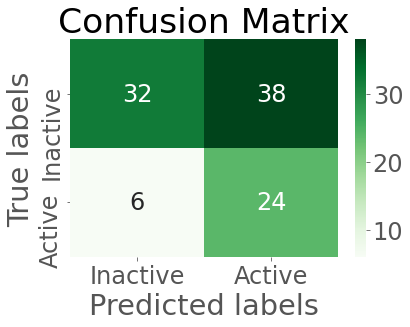

-----------> Calculating with fold 5 <----------
<class 'list'>


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 1 1 0 0 0 1 1 0 1 1 0 0 0 0 1 1 0
 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0
 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0
 1 1 1 0 1 1 0 0 1 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0
 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0
 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0
 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 1 0 1 0 0 0
 1 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1 1 1 0 0 1] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 7s - loss: 4.1951 - accuracy: 0.4425 - precision_28: 0.3060 - recall_28: 0.6891
Epoch 2/10
400/400 - 2s - loss: 4.1953 - accuracy: 0.4500 - precision_28: 0.2988 - recall_28: 0.6303
Epoch 3/10
400/400 - 2s - loss: 4.1927 - accuracy: 0.4700 - precision_28: 0.3086 - recall_28: 0.6303
Epoch 4/10
400/400 - 2s - loss: 4.1885 - accuracy: 0.4100 - precision_28: 0.3107 - recall_28: 0.8067
Epoch 5/10
400/400 - 2s - loss: 4.1926 - accuracy: 0.3900 - precision_28: 0.2910 - recall_28: 0.7311
Epoch 6/10
400/400 - 2s - loss: 4.1812 - accuracy: 0.4475 - precision_28: 0.3179 - recall_28: 0.7479
Epoch 7/10
400/400 - 2s - loss: 4.1828 - accuracy: 0.4525 - precision_28: 0.3227 - recall_28: 0.7647
Epoch 8/10
400/400 - 2s - loss: 4.1809 - accuracy: 0.4025 - precision_28: 0.2987 - recall_28: 0.7479
Epoch 9/10
400/400 - 2s - loss: 4.1795 - accuracy: 0.4275 - precision_28: 0.2948 - recall_28: 0.6639
Epoch 10/10
400/400 - 2s - loss: 4.1786 - accuracy: 0.4400 - precision

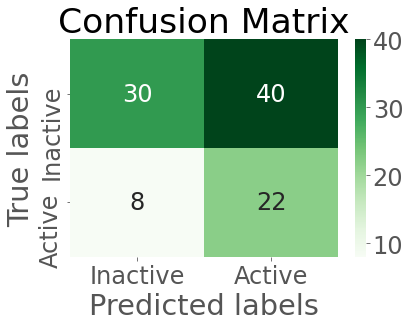

/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 1 1 0 0 0 1 1 0 1 1 0 0 0 0 1 1 0
 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0
 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0
 1 1 1 0 1 1 0 0 1 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0
 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0
 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0
 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 1 0 1 0 0 0
 1 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1 1 1 0 0 1 0 1 1 0 0 0 0
 1 1 0 1 1 1 0 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 

Train on 500 samples
Epoch 1/10
500/500 - 6s - loss: 4.2092 - accuracy: 0.5760 - precision_29: 0.2667 - recall_29: 0.2416
Epoch 2/10
500/500 - 2s - loss: 4.1970 - accuracy: 0.5240 - precision_29: 0.2891 - recall_29: 0.4094
Epoch 3/10
500/500 - 2s - loss: 4.1881 - accuracy: 0.5180 - precision_29: 0.3425 - recall_29: 0.6711
Epoch 4/10
500/500 - 3s - loss: 4.1904 - accuracy: 0.4860 - precision_29: 0.3112 - recall_29: 0.5973
Epoch 5/10
500/500 - 2s - loss: 4.1815 - accuracy: 0.5220 - precision_29: 0.3370 - recall_29: 0.6242
Epoch 6/10
500/500 - 2s - loss: 4.1758 - accuracy: 0.4760 - precision_29: 0.3283 - recall_29: 0.7248
Epoch 7/10
500/500 - 2s - loss: 4.1802 - accuracy: 0.4220 - precision_29: 0.3011 - recall_29: 0.7114
Epoch 8/10
500/500 - 2s - loss: 4.1804 - accuracy: 0.4600 - precision_29: 0.3127 - recall_29: 0.6779
Epoch 9/10
500/500 - 2s - loss: 4.1718 - accuracy: 0.5420 - precision_29: 0.3438 - recall_29: 0.5906
Epoch 10/10
500/500 - 2s - loss: 4.1655 - accuracy: 0.4600 - precision

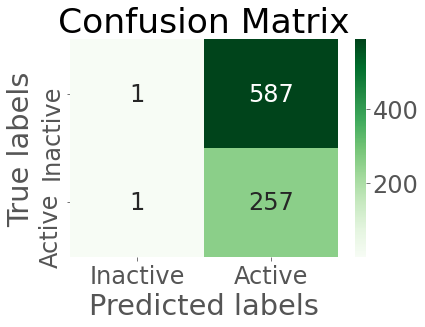

CV fold 4 of split 4 out of 10


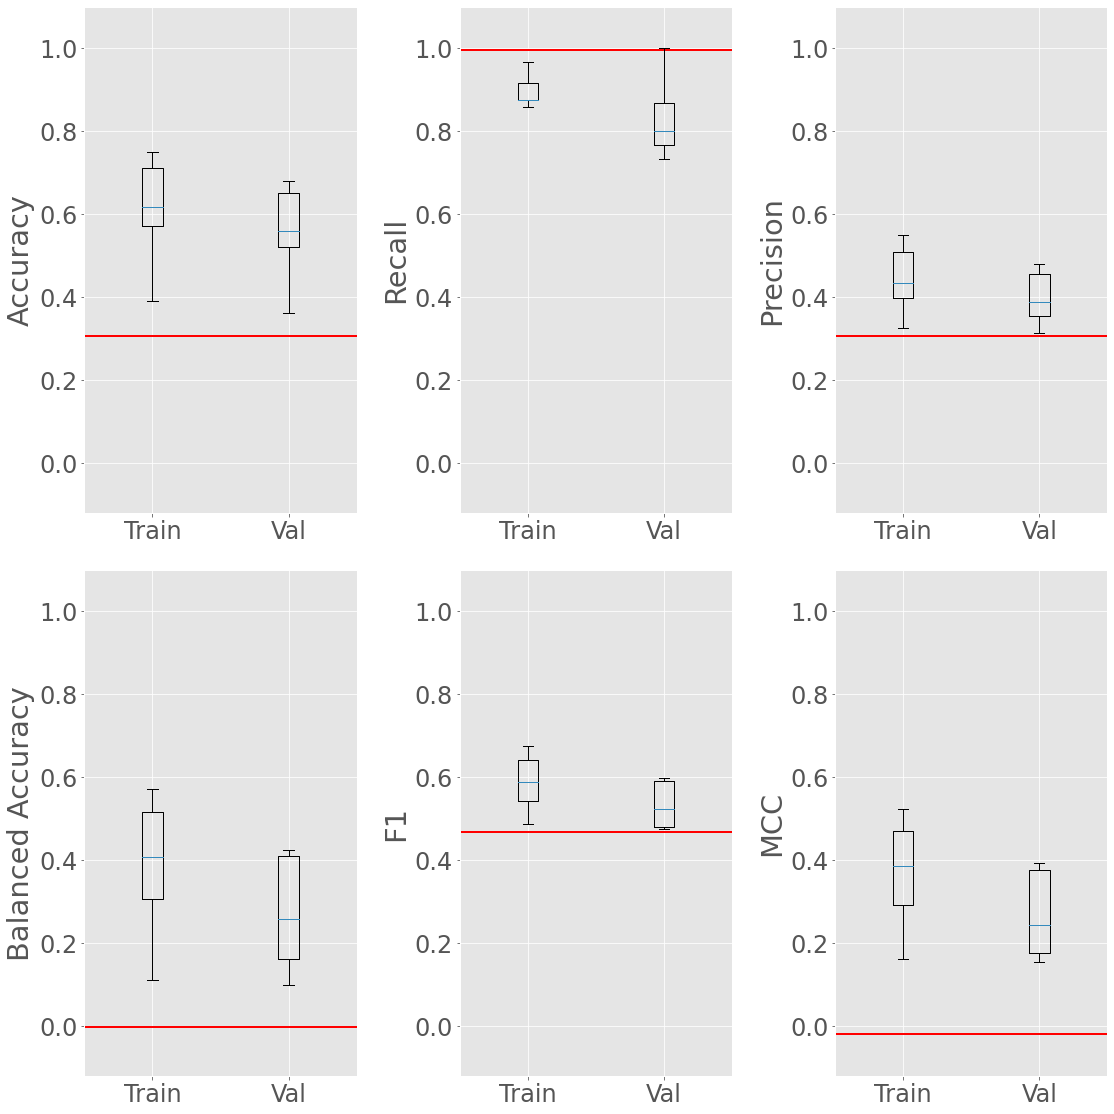

--------------> STARTING SPLIT 6 <--------------
-----------> Calculating with fold 1 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0
 0 1 1 1 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 1 0 0 1 0
 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0
 0 0 0 1 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1
 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 1 1 0 0 1 0 0 1 1 0
 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 1 1 1
 1 0 0 1 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 1 1 0 1 0 0 0 1 1 1 1 1 1 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 1 0 1 0 1 0 1 0 0
 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 6s - loss: 4.1966 - accuracy: 0.5225 - precision_30: 0.3060 - recall_30: 0.4667
Epoch 2/10
400/400 - 2s - loss: 4.1974 - accuracy: 0.5075 - precision_30: 0.3085 - recall_30: 0.5167
Epoch 3/10
400/400 - 2s - loss: 4.1983 - accuracy: 0.4900 - precision_30: 0.2742 - recall_30: 0.4250
Epoch 4/10
400/400 - 2s - loss: 4.1942 - accuracy: 0.4775 - precision_30: 0.2986 - recall_30: 0.5500
Epoch 5/10
400/400 - 2s - loss: 4.1908 - accuracy: 0.4700 - precision_30: 0.3000 - recall_30: 0.5750
Epoch 6/10
400/400 - 2s - loss: 4.1819 - accuracy: 0.5125 - precision_30: 0.3444 - recall_30: 0.6917
Epoch 7/10
400/400 - 2s - loss: 4.1804 - accuracy: 0.5175 - precision_30: 0.3378 - recall_30: 0.6333
Epoch 8/10
400/400 - 2s - loss: 4.1797 - accuracy: 0.4750 - precision_30: 0.3321 - recall_30: 0.7417
Epoch 9/10
400/400 - 2s - loss: 4.1723 - accuracy: 0.4925 - precision_30: 0.3422 - recall_30: 0.7500
Epoch 10/10
400/400 - 2s - loss: 4.1758 - accuracy: 0.4575 - precision

/Users/Anna/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


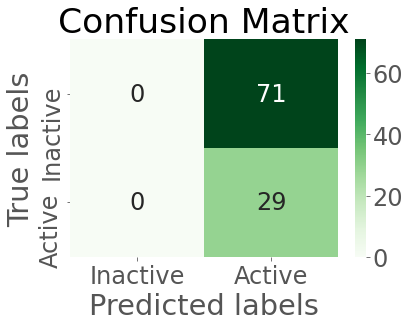

-----------> Calculating with fold 2 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0
 0 1 1 0 0 0 0 1 0 1 1 1 1 0 0 1 0 0 0 1 1 0 0 0 0 1 1 0 1 1 0 0 0 1 0 1 0
 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0
 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1 1 0 0
 0 0 0 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 1 1 1 1 0 0
 1 1 1 1 0 1 1 0 0 0 1 0 1 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1
 1 1 0 1 1 1 0 1 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 1 0 1 0
 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 0] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 8s - loss: 4.1891 - accuracy: 0.3425 - precision_31: 0.3075 - recall_31: 0.9664
Epoch 2/10
400/400 - 2s - loss: 4.1923 - accuracy: 0.3325 - precision_31: 0.2944 - recall_31: 0.8908
Epoch 3/10
400/400 - 2s - loss: 4.1863 - accuracy: 0.3175 - precision_31: 0.2837 - recall_31: 0.8487
Epoch 4/10
400/400 - 2s - loss: 4.1781 - accuracy: 0.3550 - precision_31: 0.2997 - recall_31: 0.8739
Epoch 5/10
400/400 - 2s - loss: 4.1788 - accuracy: 0.3850 - precision_31: 0.3116 - recall_31: 0.8824
Epoch 6/10
400/400 - 2s - loss: 4.1761 - accuracy: 0.3675 - precision_31: 0.3118 - recall_31: 0.9328
Epoch 7/10
400/400 - 2s - loss: 4.1734 - accuracy: 0.3975 - precision_31: 0.3195 - recall_31: 0.9076
Epoch 8/10
400/400 - 2s - loss: 4.1716 - accuracy: 0.4000 - precision_31: 0.3172 - recall_31: 0.8824
Epoch 9/10
400/400 - 2s - loss: 4.1620 - accuracy: 0.4250 - precision_31: 0.3260 - recall_31: 0.8739
Epoch 10/10
400/400 - 2s - loss: 4.1592 - accuracy: 0.4050 - precision

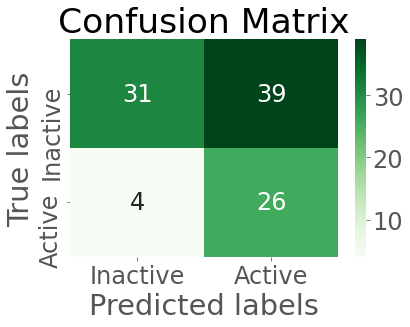

-----------> Calculating with fold 3 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 1 0 0
 0 1 1 1 0 0 0 1 0 0 1 1 1 1 0 0 1 0 0 0 1 1 1 0 0 1 1 0 1 0 1 0 0 1 0 1 0
 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1
 0 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0
 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 1 0 1 0 1 1 0
 0 0 1 0 1 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 1
 0 1 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1
 1 1 0 0 1 0 1 1 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0
 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0
 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 7s - loss: 4.2036 - accuracy: 0.3725 - precision_32: 0.3047 - recall_32: 0.8655
Epoch 2/10
400/400 - 2s - loss: 4.2005 - accuracy: 0.3875 - precision_32: 0.2981 - recall_32: 0.7815
Epoch 3/10
400/400 - 2s - loss: 4.1949 - accuracy: 0.4175 - precision_32: 0.3021 - recall_32: 0.7311
Epoch 4/10
400/400 - 2s - loss: 4.1962 - accuracy: 0.4200 - precision_32: 0.3206 - recall_32: 0.8487
Epoch 5/10
400/400 - 2s - loss: 4.1885 - accuracy: 0.4250 - precision_32: 0.3106 - recall_32: 0.7647
Epoch 6/10
400/400 - 2s - loss: 4.1819 - accuracy: 0.4275 - precision_32: 0.3281 - recall_32: 0.8824
Epoch 7/10
400/400 - 2s - loss: 4.1864 - accuracy: 0.3425 - precision_32: 0.2895 - recall_32: 0.8319
Epoch 8/10
400/400 - 1s - loss: 4.1818 - accuracy: 0.3950 - precision_32: 0.3072 - recall_32: 0.8235
Epoch 9/10
400/400 - 2s - loss: 4.1736 - accuracy: 0.4275 - precision_32: 0.3270 - recall_32: 0.8739
Epoch 10/10
400/400 - 2s - loss: 4.1745 - accuracy: 0.3875 - precision

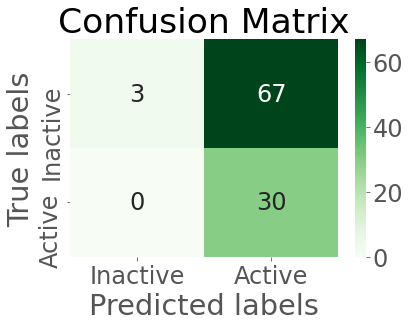

-----------> Calculating with fold 4 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 1 0
 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0 0 1 1 0 1
 0 1 0 0 1 1 0 0 0 1 0 1 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0
 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0
 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0
 0 1 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 1
 1 1 0 0 1 1 1 0 1 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 1 0 1 1 0 1 0 0 0 1 1 0 1 1 1 1 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1
 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 1 0 1 0 1 1 0
 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 12s - loss: 4.2072 - accuracy: 0.5800 - precision_33: 0.2667 - recall_33: 0.2353
Epoch 2/10
400/400 - 2s - loss: 4.2057 - accuracy: 0.5375 - precision_33: 0.2885 - recall_33: 0.3782
Epoch 3/10
400/400 - 2s - loss: 4.1955 - accuracy: 0.5350 - precision_33: 0.3246 - recall_33: 0.5210
Epoch 4/10
400/400 - 2s - loss: 4.1936 - accuracy: 0.4900 - precision_33: 0.3111 - recall_33: 0.5882
Epoch 5/10
400/400 - 2s - loss: 4.1908 - accuracy: 0.5100 - precision_33: 0.3242 - recall_33: 0.5966
Epoch 6/10
400/400 - 2s - loss: 4.1831 - accuracy: 0.5225 - precision_33: 0.3378 - recall_33: 0.6303
Epoch 7/10
400/400 - 3s - loss: 4.1910 - accuracy: 0.3750 - precision_33: 0.2749 - recall_33: 0.6723
Epoch 8/10
400/400 - 2s - loss: 4.1883 - accuracy: 0.4525 - precision_33: 0.2934 - recall_33: 0.5966
Epoch 9/10
400/400 - 2s - loss: 4.1735 - accuracy: 0.5600 - precision_33: 0.3687 - recall_33: 0.6723
Epoch 10/10
400/400 - 2s - loss: 4.1786 - accuracy: 0.4925 - precisio

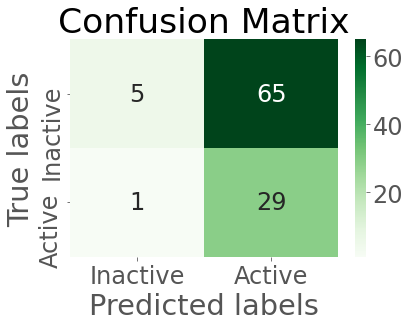

-----------> Calculating with fold 5 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0
 0 1 1 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0
 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0
 0 1 0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0
 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 1 1 1 0 0 0 1 1 1 1 1
 0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1
 0 1 1 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0
 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 1 0 1 0 1 0
 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 7s - loss: 4.2057 - accuracy: 0.5200 - precision_34: 0.2890 - recall_34: 0.4202
Epoch 2/10
400/400 - 2s - loss: 4.2000 - accuracy: 0.4650 - precision_34: 0.2944 - recall_34: 0.5714
Epoch 3/10
400/400 - 2s - loss: 4.2042 - accuracy: 0.4000 - precision_34: 0.2627 - recall_34: 0.5630
Epoch 4/10
400/400 - 2s - loss: 4.1934 - accuracy: 0.5075 - precision_34: 0.3243 - recall_34: 0.6050
Epoch 5/10
400/400 - 2s - loss: 4.1879 - accuracy: 0.4975 - precision_34: 0.3233 - recall_34: 0.6303
Epoch 6/10
400/400 - 2s - loss: 4.1812 - accuracy: 0.4475 - precision_34: 0.3217 - recall_34: 0.7731
Epoch 7/10
400/400 - 3s - loss: 4.1828 - accuracy: 0.4125 - precision_34: 0.3141 - recall_34: 0.8235
Epoch 8/10
400/400 - 2s - loss: 4.1782 - accuracy: 0.4725 - precision_34: 0.3160 - recall_34: 0.6639
Epoch 9/10
400/400 - 2s - loss: 4.1755 - accuracy: 0.4975 - precision_34: 0.3398 - recall_34: 0.7311
Epoch 10/10
400/400 - 2s - loss: 4.1693 - accuracy: 0.4975 - precision

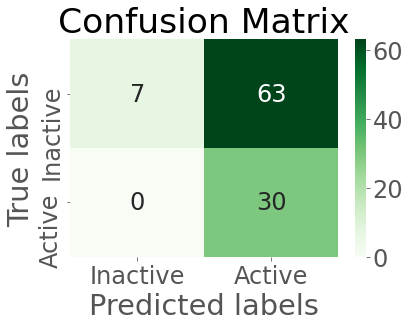

/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0
 0 1 1 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0
 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0
 0 1 0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0
 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 1 1 1 0 0 0 1 1 1 1 1
 0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1
 0 1 1 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0
 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 1 0 1 0 1 0
 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1
 0 0 0 1 0 1 0 1 0 1 1 1 1 0 1 1 0 1 0 1 0 1 0 0 0 0 0 

Train on 500 samples
Epoch 1/10
500/500 - 8s - loss: 4.2001 - accuracy: 0.4560 - precision_35: 0.2872 - recall_35: 0.5570
Epoch 2/10
500/500 - 2s - loss: 4.1942 - accuracy: 0.4160 - precision_35: 0.2986 - recall_35: 0.7114
Epoch 3/10
500/500 - 2s - loss: 4.1848 - accuracy: 0.4980 - precision_35: 0.3355 - recall_35: 0.6980
Epoch 4/10
500/500 - 2s - loss: 4.1894 - accuracy: 0.4680 - precision_35: 0.3119 - recall_35: 0.6510
Epoch 5/10
500/500 - 2s - loss: 4.1829 - accuracy: 0.4620 - precision_35: 0.3171 - recall_35: 0.6980
Epoch 6/10
500/500 - 2s - loss: 4.1786 - accuracy: 0.4300 - precision_35: 0.3172 - recall_35: 0.7919
Epoch 7/10
500/500 - 2s - loss: 4.1724 - accuracy: 0.4700 - precision_35: 0.3294 - recall_35: 0.7517
Epoch 8/10
500/500 - 2s - loss: 4.1751 - accuracy: 0.4780 - precision_35: 0.3272 - recall_35: 0.7114
Epoch 9/10
500/500 - 2s - loss: 4.1748 - accuracy: 0.4760 - precision_35: 0.3240 - recall_35: 0.6980
Epoch 10/10
500/500 - 2s - loss: 4.1582 - accuracy: 0.5040 - precision

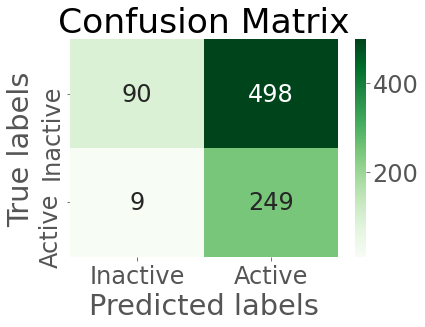

CV fold 4 of split 5 out of 10


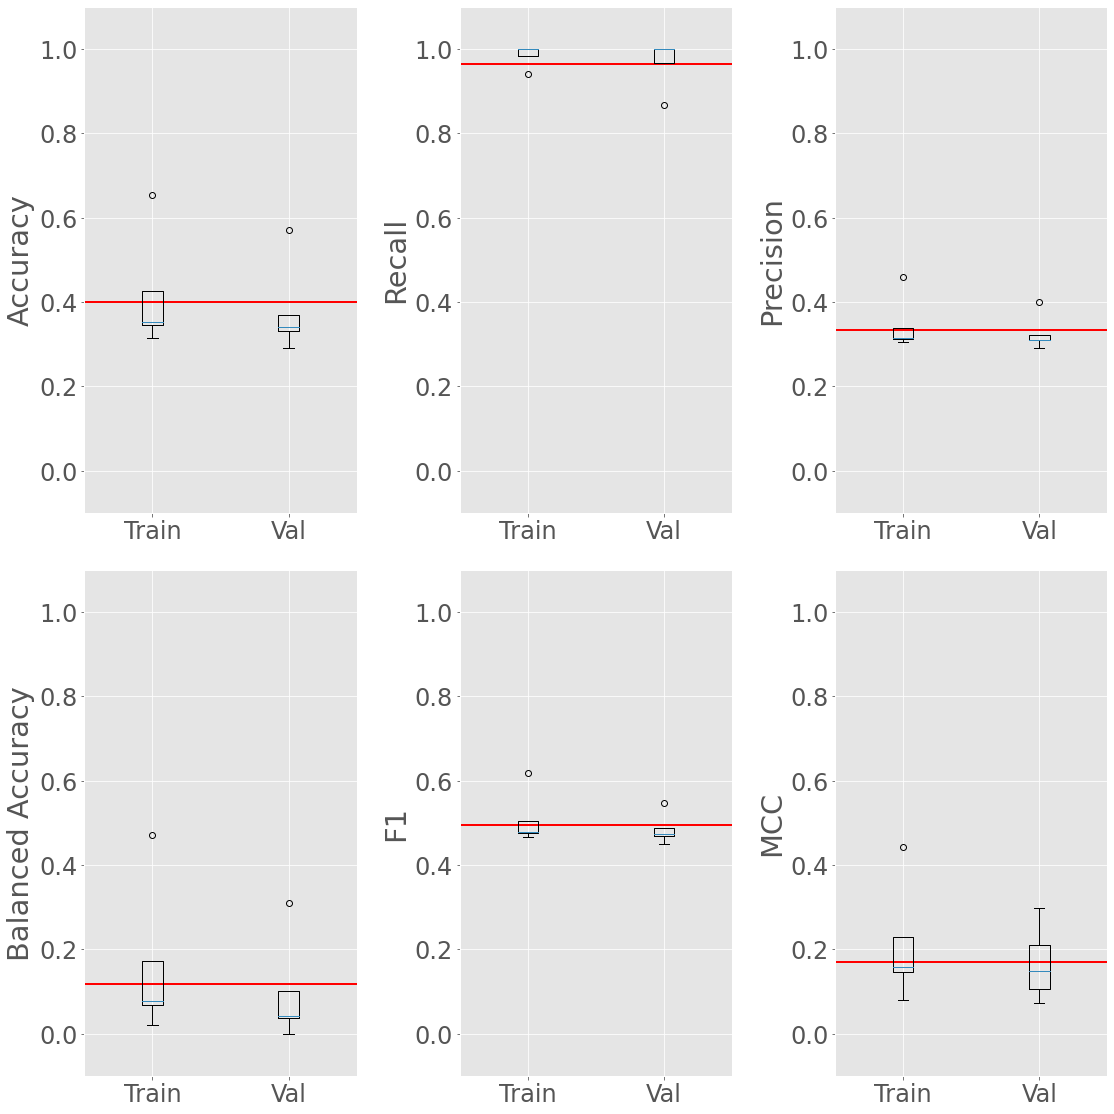

--------------> STARTING SPLIT 7 <--------------
-----------> Calculating with fold 1 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0
 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0
 0 1 0 0 0 0 1 0 1 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0
 1 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 1 1 0 1 1 0 1 1 1 1 1
 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1
 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 0 0 1 0 0 1
 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 1 0] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 7s - loss: 4.2027 - accuracy: 0.5450 - precision_36: 0.2019 - recall_36: 0.1750
Epoch 2/10
400/400 - 2s - loss: 4.1964 - accuracy: 0.5750 - precision_36: 0.3106 - recall_36: 0.3417
Epoch 3/10
400/400 - 2s - loss: 4.1939 - accuracy: 0.5650 - precision_36: 0.3291 - recall_36: 0.4333
Epoch 4/10
400/400 - 2s - loss: 4.1862 - accuracy: 0.5125 - precision_36: 0.3077 - recall_36: 0.5000
Epoch 5/10
400/400 - 2s - loss: 4.1918 - accuracy: 0.5150 - precision_36: 0.3168 - recall_36: 0.5333
Epoch 6/10
400/400 - 2s - loss: 4.1853 - accuracy: 0.5375 - precision_36: 0.3445 - recall_36: 0.6000
Epoch 7/10
400/400 - 2s - loss: 4.1850 - accuracy: 0.4750 - precision_36: 0.2991 - recall_36: 0.5583
Epoch 8/10
400/400 - 2s - loss: 4.1797 - accuracy: 0.4700 - precision_36: 0.3130 - recall_36: 0.6417
Epoch 9/10
400/400 - 2s - loss: 4.1811 - accuracy: 0.4700 - precision_36: 0.3099 - recall_36: 0.6250
Epoch 10/10
400/400 - 2s - loss: 4.1845 - accuracy: 0.4625 - precision

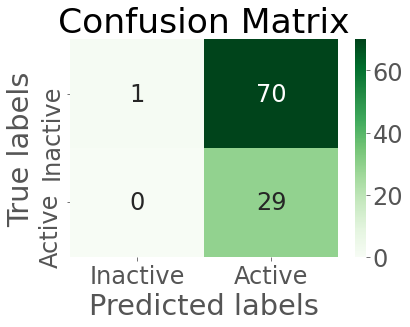

-----------> Calculating with fold 2 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 1
 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0
 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1
 1 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 1 0
 1 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 0
 0 1 1 1 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0
 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1
 1 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 1 0 0 0 1 1 0 0
 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 0] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 7s - loss: 4.2103 - accuracy: 0.6450 - precision_37: 0.2326 - recall_37: 0.0840
Epoch 2/10
400/400 - 2s - loss: 4.2013 - accuracy: 0.6075 - precision_37: 0.2683 - recall_37: 0.1849
Epoch 3/10
400/400 - 2s - loss: 4.1969 - accuracy: 0.5900 - precision_37: 0.2414 - recall_37: 0.1765
Epoch 4/10
400/400 - 2s - loss: 4.1943 - accuracy: 0.6150 - precision_37: 0.3267 - recall_37: 0.2773
Epoch 5/10
400/400 - 2s - loss: 4.1857 - accuracy: 0.6450 - precision_37: 0.3905 - recall_37: 0.3445
Epoch 6/10
400/400 - 2s - loss: 4.1876 - accuracy: 0.5600 - precision_37: 0.2791 - recall_37: 0.3025
Epoch 7/10
400/400 - 2s - loss: 4.1832 - accuracy: 0.6225 - precision_37: 0.3873 - recall_37: 0.4622
Epoch 8/10
400/400 - 2s - loss: 4.1843 - accuracy: 0.6050 - precision_37: 0.3361 - recall_37: 0.3361
Epoch 9/10
400/400 - 2s - loss: 4.1813 - accuracy: 0.5700 - precision_37: 0.3147 - recall_37: 0.3782
Epoch 10/10
400/400 - 2s - loss: 4.1755 - accuracy: 0.5825 - precision

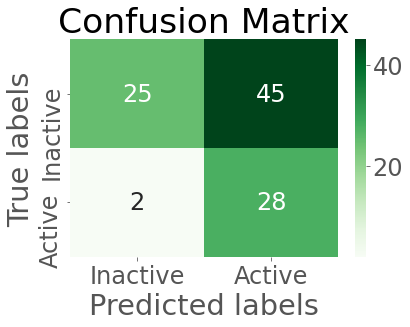

-----------> Calculating with fold 3 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1
 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0
 0 0 1 0 0 0 1 1 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 1
 0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 1 0 0 1 1 1 1 0 0 0 0 0 0
 1 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0
 0 1 0 1 0 1 1 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 1
 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0
 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 0] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 6s - loss: 4.1971 - accuracy: 0.3975 - precision_38: 0.2953 - recall_38: 0.7395
Epoch 2/10
400/400 - 1s - loss: 4.1895 - accuracy: 0.4075 - precision_38: 0.3046 - recall_38: 0.7731
Epoch 3/10
400/400 - 2s - loss: 4.1973 - accuracy: 0.3625 - precision_38: 0.2901 - recall_38: 0.7899
Epoch 4/10
400/400 - 2s - loss: 4.1914 - accuracy: 0.3775 - precision_38: 0.2981 - recall_38: 0.8067
Epoch 5/10
400/400 - 2s - loss: 4.1866 - accuracy: 0.3975 - precision_38: 0.3082 - recall_38: 0.8235
Epoch 6/10
400/400 - 2s - loss: 4.1865 - accuracy: 0.4025 - precision_38: 0.3052 - recall_38: 0.7899
Epoch 7/10
400/400 - 2s - loss: 4.1855 - accuracy: 0.4025 - precision_38: 0.2945 - recall_38: 0.7227
Epoch 8/10
400/400 - 2s - loss: 4.1823 - accuracy: 0.4625 - precision_38: 0.3182 - recall_38: 0.7059
Epoch 9/10
400/400 - 2s - loss: 4.1805 - accuracy: 0.4475 - precision_38: 0.3179 - recall_38: 0.7479
Epoch 10/10
400/400 - 2s - loss: 4.1773 - accuracy: 0.4550 - precision

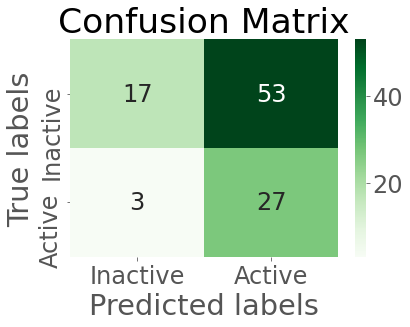

-----------> Calculating with fold 4 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0
 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0
 0 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1
 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 1 0 0 1 0 0 0
 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 1
 1 1 0 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 1 1 0 1 1 1
 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1
 1 0 1 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 1 0 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 1 0 0 0 0 0 1
 1 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 6s - loss: 4.2007 - accuracy: 0.5200 - precision_39: 0.3147 - recall_39: 0.5210
Epoch 2/10
400/400 - 2s - loss: 4.2016 - accuracy: 0.4475 - precision_39: 0.2893 - recall_39: 0.5882
Epoch 3/10
400/400 - 2s - loss: 4.2013 - accuracy: 0.4500 - precision_39: 0.2972 - recall_39: 0.6218
Epoch 4/10
400/400 - 2s - loss: 4.1943 - accuracy: 0.4325 - precision_39: 0.2955 - recall_39: 0.6555
Epoch 5/10
400/400 - 2s - loss: 4.1925 - accuracy: 0.4175 - precision_39: 0.3087 - recall_39: 0.7731
Epoch 6/10
400/400 - 2s - loss: 4.1905 - accuracy: 0.4125 - precision_39: 0.3000 - recall_39: 0.7311
Epoch 7/10
400/400 - 2s - loss: 4.1908 - accuracy: 0.5050 - precision_39: 0.3213 - recall_39: 0.5966
Epoch 8/10
400/400 - 1s - loss: 4.1833 - accuracy: 0.4775 - precision_39: 0.3140 - recall_39: 0.6387
Epoch 9/10
400/400 - 2s - loss: 4.1763 - accuracy: 0.5075 - precision_39: 0.3415 - recall_39: 0.7059
Epoch 10/10
400/400 - 2s - loss: 4.1693 - accuracy: 0.4675 - precision

/Users/Anna/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


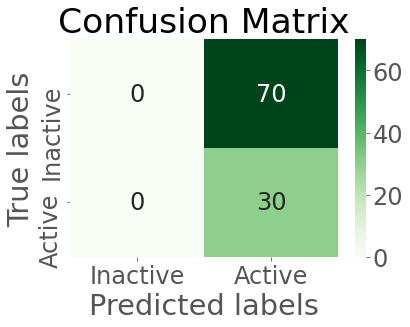

-----------> Calculating with fold 5 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0
 1 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 1
 1 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0
 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 0 1 0 1 0 1 1 0 1 1 1 1 0 0 0 0 1 1 0 0 0 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1
 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 1 1 1 0 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 0 0 1 0 1 0 0 0 1 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0
 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0
 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 1
 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 7s - loss: 4.1983 - accuracy: 0.5175 - precision_40: 0.3093 - recall_40: 0.5042
Epoch 2/10
400/400 - 2s - loss: 4.1974 - accuracy: 0.5200 - precision_40: 0.3109 - recall_40: 0.5042
Epoch 3/10
400/400 - 2s - loss: 4.1965 - accuracy: 0.4750 - precision_40: 0.3064 - recall_40: 0.6050
Epoch 4/10
400/400 - 2s - loss: 4.1900 - accuracy: 0.5200 - precision_40: 0.3270 - recall_40: 0.5798
Epoch 5/10
400/400 - 2s - loss: 4.1887 - accuracy: 0.5300 - precision_40: 0.3480 - recall_40: 0.6639
Epoch 6/10
400/400 - 2s - loss: 4.1925 - accuracy: 0.4950 - precision_40: 0.3139 - recall_40: 0.5882
Epoch 7/10
400/400 - 3s - loss: 4.1867 - accuracy: 0.4675 - precision_40: 0.3058 - recall_40: 0.6218
Epoch 8/10
400/400 - 3s - loss: 4.1803 - accuracy: 0.5275 - precision_40: 0.3317 - recall_40: 0.5798
Epoch 9/10
400/400 - 3s - loss: 4.1839 - accuracy: 0.5075 - precision_40: 0.3030 - recall_40: 0.5042
Epoch 10/10
400/400 - 3s - loss: 4.1786 - accuracy: 0.5450 - precision

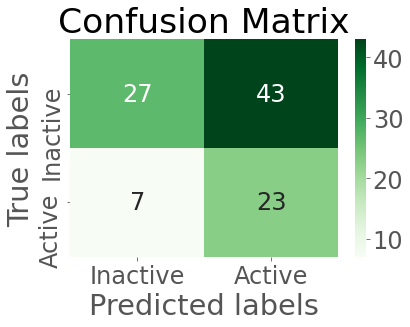

/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0
 1 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 1
 1 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0
 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 0 1 0 1 0 1 1 0 1 1 1 1 0 0 0 0 1 1 0 0 0 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1
 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 1 1 1 0 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 0 0 1 0 1 0 0 0 1 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0
 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0
 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 1
 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0
 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 

Train on 500 samples
Epoch 1/10
500/500 - 11s - loss: 4.1998 - accuracy: 0.6440 - precision_41: 0.3067 - recall_41: 0.1544
Epoch 2/10
500/500 - 3s - loss: 4.1933 - accuracy: 0.6140 - precision_41: 0.2963 - recall_41: 0.2148
Epoch 3/10
500/500 - 2s - loss: 4.1894 - accuracy: 0.5960 - precision_41: 0.3172 - recall_41: 0.3087
Epoch 4/10
500/500 - 3s - loss: 4.1851 - accuracy: 0.5640 - precision_41: 0.3115 - recall_41: 0.3826
Epoch 5/10
500/500 - 3s - loss: 4.1857 - accuracy: 0.4960 - precision_41: 0.2731 - recall_41: 0.4161
Epoch 6/10
500/500 - 2s - loss: 4.1821 - accuracy: 0.5440 - precision_41: 0.3180 - recall_41: 0.4631
Epoch 7/10
500/500 - 3s - loss: 4.1789 - accuracy: 0.5060 - precision_41: 0.3086 - recall_41: 0.5302
Epoch 8/10
500/500 - 3s - loss: 4.1814 - accuracy: 0.4780 - precision_41: 0.2812 - recall_41: 0.4832
Epoch 9/10
500/500 - 2s - loss: 4.1749 - accuracy: 0.4920 - precision_41: 0.3105 - recall_41: 0.5772
Epoch 10/10
500/500 - 3s - loss: 4.1746 - accuracy: 0.4660 - precisio

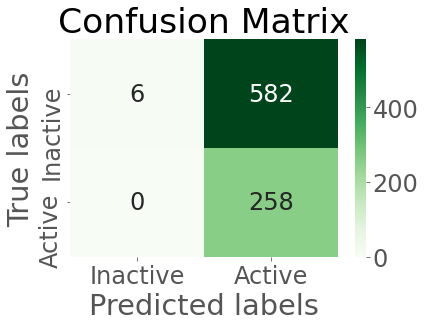

CV fold 4 of split 6 out of 10


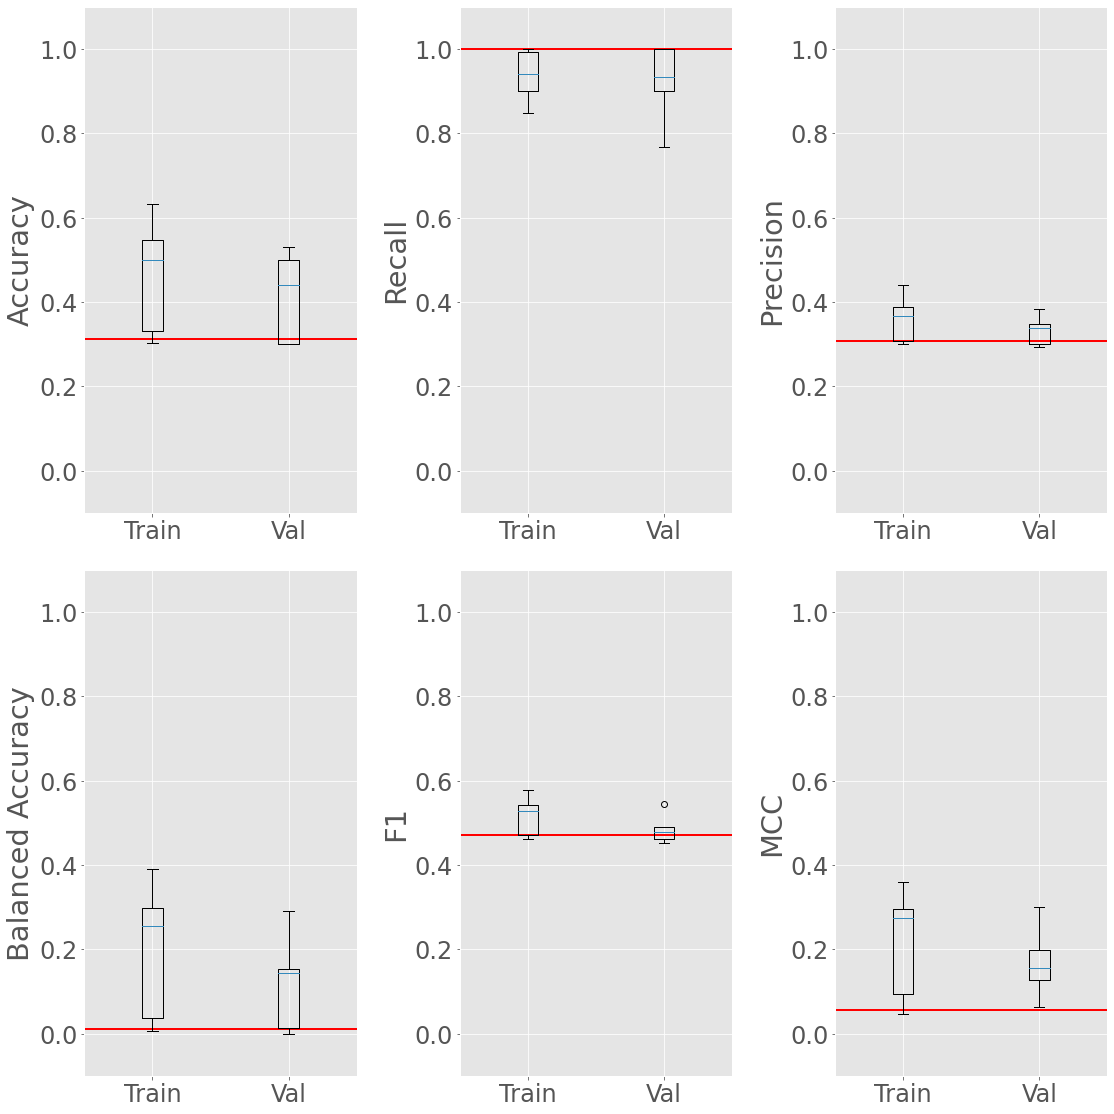

--------------> STARTING SPLIT 8 <--------------
-----------> Calculating with fold 1 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 1 1 0 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1
 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0
 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0
 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0
 0 1 0 1 1 1 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0 0 0 1 0 1
 1 0 1 0 0 0 1 0 1 0 1 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 1 0 0 0
 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1 0 1 0
 1 0 0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 6s - loss: 4.2006 - accuracy: 0.3075 - precision_42: 0.3013 - recall_42: 0.9917
Epoch 2/10
400/400 - 2s - loss: 4.1956 - accuracy: 0.3150 - precision_42: 0.2995 - recall_42: 0.9583
Epoch 3/10
400/400 - 2s - loss: 4.1929 - accuracy: 0.3300 - precision_42: 0.3011 - recall_42: 0.9333
Epoch 4/10
400/400 - 2s - loss: 4.1875 - accuracy: 0.3300 - precision_42: 0.3073 - recall_42: 0.9833
Epoch 5/10
400/400 - 2s - loss: 4.1841 - accuracy: 0.3375 - precision_42: 0.3077 - recall_42: 0.9667
Epoch 6/10
400/400 - 2s - loss: 4.1858 - accuracy: 0.3525 - precision_42: 0.3106 - recall_42: 0.9500
Epoch 7/10
400/400 - 2s - loss: 4.1800 - accuracy: 0.3475 - precision_42: 0.3025 - recall_42: 0.9000
Epoch 8/10
400/400 - 2s - loss: 4.1758 - accuracy: 0.4200 - precision_42: 0.3363 - recall_42: 0.9583
Epoch 9/10
400/400 - 2s - loss: 4.1691 - accuracy: 0.3575 - precision_42: 0.3134 - recall_42: 0.9583
Epoch 10/10
400/400 - 2s - loss: 4.1699 - accuracy: 0.4225 - precision

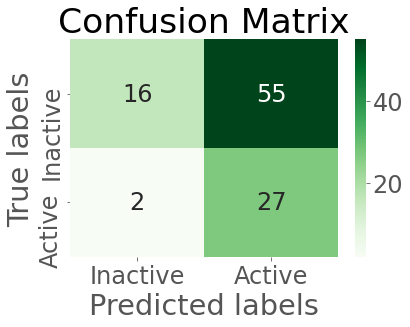

-----------> Calculating with fold 2 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 0 0 0 0 1 1 0 1 1 1 1 0 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0
 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1
 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1
 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0
 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0
 1 0 0 1 0 1 1 1 0 0 1 0 1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0
 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0 1 0 1 1 0 0 0 0 1 1 0 0 0
 1 0 1 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 6s - loss: 4.2067 - accuracy: 0.3425 - precision_43: 0.2955 - recall_43: 0.8739
Epoch 2/10
400/400 - 2s - loss: 4.2038 - accuracy: 0.3350 - precision_43: 0.2906 - recall_43: 0.8571
Epoch 3/10
400/400 - 2s - loss: 4.1905 - accuracy: 0.3700 - precision_43: 0.3015 - recall_43: 0.8487
Epoch 4/10
400/400 - 2s - loss: 4.1970 - accuracy: 0.3900 - precision_43: 0.2896 - recall_43: 0.7227
Epoch 5/10
400/400 - 2s - loss: 4.1911 - accuracy: 0.4225 - precision_43: 0.3095 - recall_43: 0.7647
Epoch 6/10
400/400 - 2s - loss: 4.1850 - accuracy: 0.4575 - precision_43: 0.3262 - recall_43: 0.7731
Epoch 7/10
400/400 - 2s - loss: 4.1853 - accuracy: 0.4150 - precision_43: 0.3064 - recall_43: 0.7647
Epoch 8/10
400/400 - 2s - loss: 4.1782 - accuracy: 0.5125 - precision_43: 0.3417 - recall_43: 0.6891
Epoch 9/10
400/400 - 2s - loss: 4.1747 - accuracy: 0.4500 - precision_43: 0.3216 - recall_43: 0.7647
Epoch 10/10
400/400 - 2s - loss: 4.1767 - accuracy: 0.4575 - precision

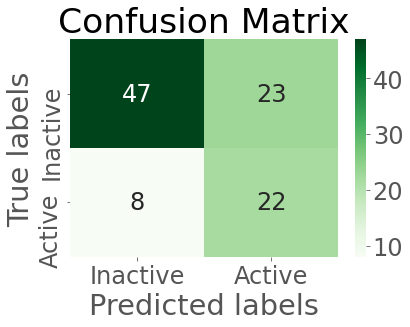

-----------> Calculating with fold 3 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 0 1 0 1 0 1 0 0 1 1 0 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1
 0 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1
 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0
 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1
 1 0 0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0
 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 0
 0 0 1 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0
 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0
 0 0 1 0 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 1 1 0 1 0 1 1 0 0 0 0 1 1 1
 0 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 9s - loss: 4.1969 - accuracy: 0.3175 - precision_44: 0.3026 - recall_44: 0.9916
Epoch 2/10
400/400 - 2s - loss: 4.1924 - accuracy: 0.3275 - precision_44: 0.2984 - recall_44: 0.9328
Epoch 3/10
400/400 - 2s - loss: 4.1923 - accuracy: 0.3275 - precision_44: 0.2984 - recall_44: 0.9328
Epoch 4/10
400/400 - 2s - loss: 4.1900 - accuracy: 0.3350 - precision_44: 0.2997 - recall_44: 0.9244
Epoch 5/10
400/400 - 2s - loss: 4.1909 - accuracy: 0.3500 - precision_44: 0.2968 - recall_44: 0.8655
Epoch 6/10
400/400 - 2s - loss: 4.1792 - accuracy: 0.3750 - precision_44: 0.3123 - recall_44: 0.9160
Epoch 7/10
400/400 - 2s - loss: 4.1863 - accuracy: 0.3700 - precision_44: 0.3072 - recall_44: 0.8908
Epoch 8/10
400/400 - 2s - loss: 4.1843 - accuracy: 0.3875 - precision_44: 0.3043 - recall_44: 0.8235
Epoch 9/10
400/400 - 2s - loss: 4.1762 - accuracy: 0.4025 - precision_44: 0.3137 - recall_44: 0.8487
Epoch 10/10
400/400 - 2s - loss: 4.1700 - accuracy: 0.4450 - precision

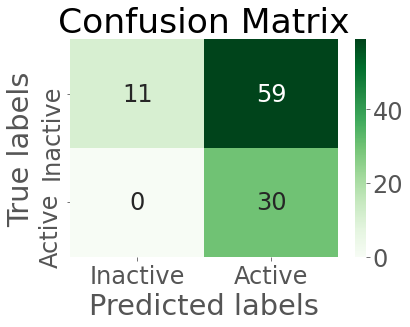

-----------> Calculating with fold 4 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 1 0 1 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0
 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0
 0 0 0 0 1 1 0 1 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0
 1 0 0 1 0 0 1 0 1 1 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 0 0
 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1
 0 1 0 1 0 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0
 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 1 0 0
 0 1 1 0 0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 6s - loss: 4.2142 - accuracy: 0.6000 - precision_45: 0.2405 - recall_45: 0.1597
Epoch 2/10
400/400 - 2s - loss: 4.2008 - accuracy: 0.5750 - precision_45: 0.2424 - recall_45: 0.2017
Epoch 3/10
400/400 - 2s - loss: 4.1993 - accuracy: 0.5700 - precision_45: 0.2880 - recall_45: 0.3025
Epoch 4/10
400/400 - 2s - loss: 4.1898 - accuracy: 0.5675 - precision_45: 0.3200 - recall_45: 0.4034
Epoch 5/10
400/400 - 2s - loss: 4.1967 - accuracy: 0.5125 - precision_45: 0.2816 - recall_45: 0.4118
Epoch 6/10
400/400 - 2s - loss: 4.1910 - accuracy: 0.5050 - precision_45: 0.3110 - recall_45: 0.5462
Epoch 7/10
400/400 - 2s - loss: 4.1897 - accuracy: 0.4750 - precision_45: 0.2823 - recall_45: 0.4958
Epoch 8/10
400/400 - 3s - loss: 4.1886 - accuracy: 0.5125 - precision_45: 0.3061 - recall_45: 0.5042
Epoch 9/10
400/400 - 2s - loss: 4.1810 - accuracy: 0.5325 - precision_45: 0.3247 - recall_45: 0.5294
Epoch 10/10
400/400 - 2s - loss: 4.1717 - accuracy: 0.5600 - precision

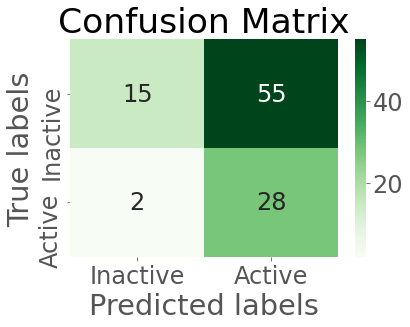

-----------> Calculating with fold 5 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1
 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0
 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0
 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0
 1 0 0 1 0 1 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 0 0 1 0
 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0
 1 1 1 0 1 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0
 0 1 0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 1 1 1
 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 1 1] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 7s - loss: 4.2015 - accuracy: 0.6575 - precision_46: 0.2000 - recall_46: 0.0504
Epoch 2/10
400/400 - 2s - loss: 4.2018 - accuracy: 0.6500 - precision_46: 0.3091 - recall_46: 0.1429
Epoch 3/10
400/400 - 2s - loss: 4.1946 - accuracy: 0.6175 - precision_46: 0.3111 - recall_46: 0.2353
Epoch 4/10
400/400 - 2s - loss: 4.1905 - accuracy: 0.5975 - precision_46: 0.2614 - recall_46: 0.1933
Epoch 5/10
400/400 - 2s - loss: 4.1880 - accuracy: 0.6250 - precision_46: 0.3604 - recall_46: 0.3361
Epoch 6/10
400/400 - 2s - loss: 4.1871 - accuracy: 0.5625 - precision_46: 0.2879 - recall_46: 0.3193
Epoch 7/10
400/400 - 2s - loss: 4.1827 - accuracy: 0.6375 - precision_46: 0.3796 - recall_46: 0.3445
Epoch 8/10
400/400 - 3s - loss: 4.1848 - accuracy: 0.5825 - precision_46: 0.3000 - recall_46: 0.3025
Epoch 9/10
400/400 - 3s - loss: 4.1874 - accuracy: 0.5500 - precision_46: 0.2707 - recall_46: 0.3025
Epoch 10/10
400/400 - 2s - loss: 4.1761 - accuracy: 0.5700 - precision

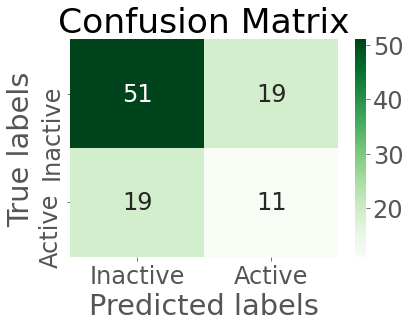

/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1
 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0
 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0
 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0
 1 0 0 1 0 1 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 0 0 1 0
 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0
 1 1 1 0 1 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0
 0 1 0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 1 1 1
 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 1
 0 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 1 0 0 0 1 1 0 0 0 1 

Train on 500 samples
Epoch 1/10
500/500 - 8s - loss: 4.1981 - accuracy: 0.4740 - precision_47: 0.2841 - recall_47: 0.5034
Epoch 2/10
500/500 - 2s - loss: 4.1914 - accuracy: 0.4640 - precision_47: 0.2983 - recall_47: 0.5906
Epoch 3/10
500/500 - 2s - loss: 4.1894 - accuracy: 0.4640 - precision_47: 0.3062 - recall_47: 0.6309
Epoch 4/10
500/500 - 3s - loss: 4.1880 - accuracy: 0.4560 - precision_47: 0.2901 - recall_47: 0.5705
Epoch 5/10
500/500 - 3s - loss: 4.1826 - accuracy: 0.4820 - precision_47: 0.3063 - recall_47: 0.5839
Epoch 6/10
500/500 - 3s - loss: 4.1772 - accuracy: 0.4820 - precision_47: 0.3129 - recall_47: 0.6174
Epoch 7/10
500/500 - 2s - loss: 4.1787 - accuracy: 0.4720 - precision_47: 0.3139 - recall_47: 0.6510
Epoch 8/10
500/500 - 3s - loss: 4.1812 - accuracy: 0.4320 - precision_47: 0.2830 - recall_47: 0.5906
Epoch 9/10
500/500 - 3s - loss: 4.1719 - accuracy: 0.5420 - precision_47: 0.3333 - recall_47: 0.5369
Epoch 10/10
500/500 - 2s - loss: 4.1687 - accuracy: 0.5520 - precision

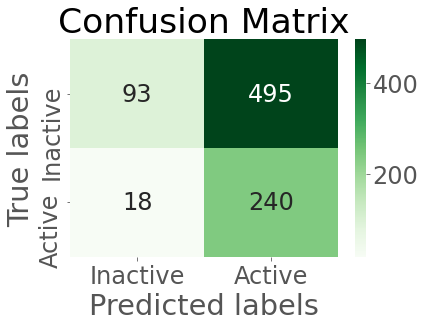

CV fold 4 of split 7 out of 10


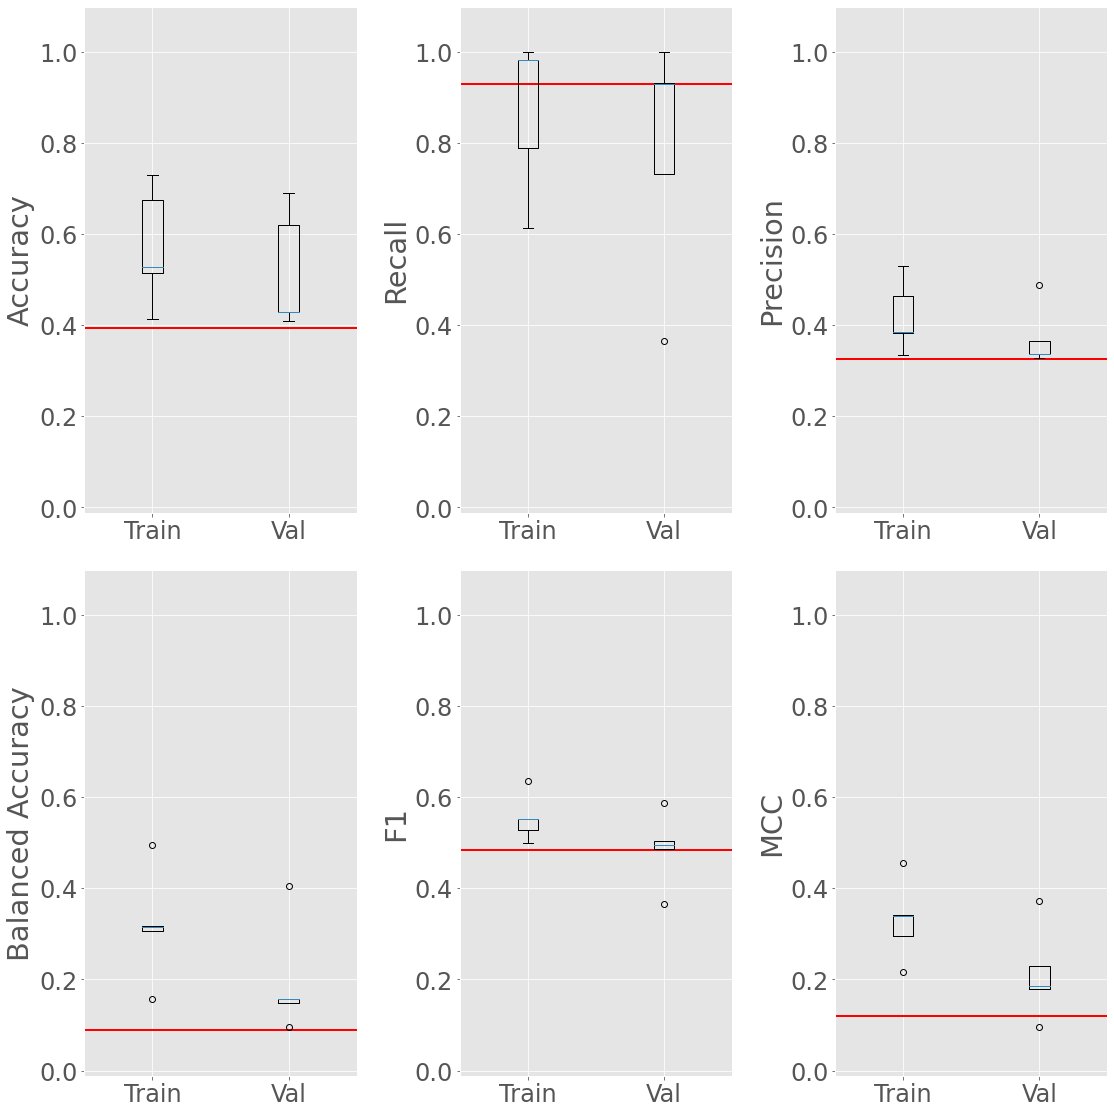

--------------> STARTING SPLIT 9 <--------------
-----------> Calculating with fold 1 <----------
<class 'list'>


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 1 1 1 0 0 0 1 0 1 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 1 0 1 1 1 0
 0 1 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0
 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0
 0 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 1 1 0 1 0
 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0
 0 1 1 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 1] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 9s - loss: 5.8774 - accuracy: 0.5425 - precision_48: 0.2867 - recall_48: 0.3613
Epoch 2/10
400/400 - 3s - loss: 5.8739 - accuracy: 0.5325 - precision_48: 0.2901 - recall_48: 0.3950
Epoch 3/10
400/400 - 2s - loss: 5.8693 - accuracy: 0.5025 - precision_48: 0.3182 - recall_48: 0.5882
Epoch 4/10
400/400 - 4s - loss: 5.8664 - accuracy: 0.5100 - precision_48: 0.3319 - recall_48: 0.6387
Epoch 5/10
400/400 - 3s - loss: 5.8633 - accuracy: 0.5400 - precision_48: 0.3430 - recall_48: 0.5966
Epoch 6/10
400/400 - 4s - loss: 5.8609 - accuracy: 0.4575 - precision_48: 0.3144 - recall_48: 0.6975
Epoch 7/10
400/400 - 3s - loss: 5.8580 - accuracy: 0.4950 - precision_48: 0.3014 - recall_48: 0.5294
Epoch 8/10
400/400 - 3s - loss: 5.8548 - accuracy: 0.4500 - precision_48: 0.3050 - recall_48: 0.6639
Epoch 9/10
400/400 - 3s - loss: 5.8512 - accuracy: 0.4375 - precision_48: 0.3051 - recall_48: 0.6975
Epoch 10/10
400/400 - 3s - loss: 5.8510 - accuracy: 0.4400 - precision

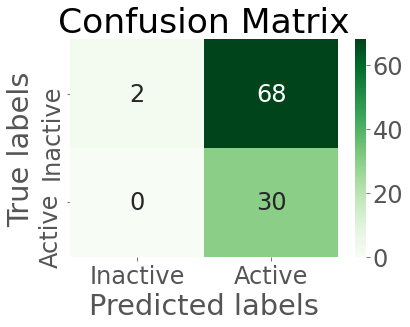

-----------> Calculating with fold 2 <----------
<class 'list'>


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 1 1 0 1 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0
 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 1 1 0 0 0 1 0 0 0 0 1 0 1 1 0
 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0
 1 0 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 0 1 1 0 1 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 1 0
 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0
 1 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 1 0 1
 0 1 0 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 8s - loss: 7.5576 - accuracy: 0.6175 - precision_49: 0.2069 - recall_49: 0.1008
Epoch 2/10
400/400 - 3s - loss: 7.5531 - accuracy: 0.6400 - precision_49: 0.2881 - recall_49: 0.1429
Epoch 3/10
400/400 - 3s - loss: 7.5502 - accuracy: 0.6025 - precision_49: 0.1875 - recall_49: 0.1008
Epoch 4/10
400/400 - 3s - loss: 7.5453 - accuracy: 0.6375 - precision_49: 0.3143 - recall_49: 0.1849
Epoch 5/10
400/400 - 4s - loss: 7.5416 - accuracy: 0.6425 - precision_49: 0.3333 - recall_49: 0.2017
Epoch 6/10
400/400 - 3s - loss: 7.5374 - accuracy: 0.5750 - precision_49: 0.3139 - recall_49: 0.3613
Epoch 7/10
400/400 - 3s - loss: 7.5334 - accuracy: 0.5750 - precision_49: 0.2992 - recall_49: 0.3193
Epoch 8/10
400/400 - 3s - loss: 7.5287 - accuracy: 0.6175 - precision_49: 0.3455 - recall_49: 0.3193
Epoch 9/10
400/400 - 3s - loss: 7.5276 - accuracy: 0.5675 - precision_49: 0.2857 - recall_49: 0.3025
Epoch 10/10
400/400 - 3s - loss: 7.5237 - accuracy: 0.5150 - precision

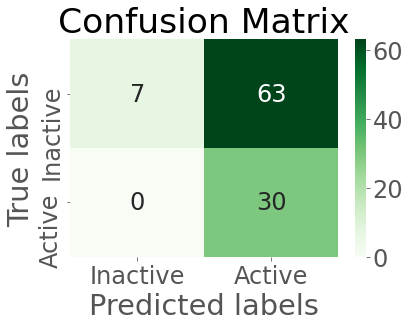

-----------> Calculating with fold 3 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 0 0 0 1 0 0 0 0 0 1 1 0 0 1 1 0 1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 0 0 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 0
 0 1 1 1 1 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1
 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 0 1 0 0 0 0 1 0 0 0 1
 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1
 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1
 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 0 0 0 1
 0 0 0 1 1 0 0 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 7s - loss: 7.5594 - accuracy: 0.6725 - precision_50: 0.3235 - recall_50: 0.0924
Epoch 2/10
400/400 - 3s - loss: 7.5564 - accuracy: 0.6400 - precision_50: 0.3134 - recall_50: 0.1765
Epoch 3/10
400/400 - 3s - loss: 7.5531 - accuracy: 0.6275 - precision_50: 0.2794 - recall_50: 0.1597
Epoch 4/10
400/400 - 3s - loss: 7.5471 - accuracy: 0.5950 - precision_50: 0.2952 - recall_50: 0.2605
Epoch 5/10
400/400 - 4s - loss: 7.5454 - accuracy: 0.5900 - precision_50: 0.2857 - recall_50: 0.2521
Epoch 6/10
400/400 - 3s - loss: 7.5405 - accuracy: 0.5750 - precision_50: 0.2743 - recall_50: 0.2605
Epoch 7/10
400/400 - 3s - loss: 7.5342 - accuracy: 0.5725 - precision_50: 0.3143 - recall_50: 0.3697
Epoch 8/10
400/400 - 3s - loss: 7.5318 - accuracy: 0.5625 - precision_50: 0.2910 - recall_50: 0.3277
Epoch 9/10
400/400 - 3s - loss: 7.5308 - accuracy: 0.5300 - precision_50: 0.2653 - recall_50: 0.3277
Epoch 10/10
400/400 - 3s - loss: 7.5261 - accuracy: 0.5325 - precision

/Users/Anna/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.297, Correctly calssified: 0.297, MCC: nan, F1 score: 0.459, Balanced accuracy: 0.000
---> Validation set fold 3
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.300, Correctly calssified: 0.300, MCC: nan, F1 score: 0.462, Balanced accuracy: 0.000


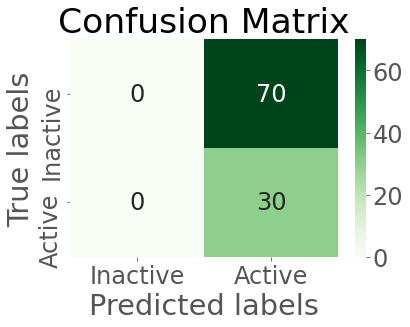

-----------> Calculating with fold 4 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 1 1 0 1 1 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 1 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 1
 0 1 0 0 0 1 1 1 1 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 0 1 1 0 0 1 0 0 1
 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 1 0
 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1
 0 0 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 1
 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0
 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0
 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 1
 0 0 0 0 1 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 7s - loss: 7.5499 - accuracy: 0.5275 - precision_51: 0.2941 - recall_51: 0.4202
Epoch 2/10
400/400 - 3s - loss: 7.5463 - accuracy: 0.4775 - precision_51: 0.2750 - recall_51: 0.4622
Epoch 3/10
400/400 - 3s - loss: 7.5367 - accuracy: 0.5050 - precision_51: 0.3146 - recall_51: 0.5630
Epoch 4/10
400/400 - 3s - loss: 7.5311 - accuracy: 0.5000 - precision_51: 0.3116 - recall_51: 0.5630
Epoch 5/10
400/400 - 4s - loss: 7.5331 - accuracy: 0.4400 - precision_51: 0.2989 - recall_51: 0.6555
Epoch 6/10
400/400 - 3s - loss: 7.5284 - accuracy: 0.4450 - precision_51: 0.3057 - recall_51: 0.6807
Epoch 7/10
400/400 - 3s - loss: 7.5256 - accuracy: 0.4575 - precision_51: 0.3086 - recall_51: 0.6639
Epoch 8/10
400/400 - 3s - loss: 7.5218 - accuracy: 0.4075 - precision_51: 0.2847 - recall_51: 0.6555
Epoch 9/10
400/400 - 3s - loss: 7.5112 - accuracy: 0.4900 - precision_51: 0.3396 - recall_51: 0.7563
Epoch 10/10
400/400 - 3s - loss: 7.5205 - accuracy: 0.4150 - precision

/Users/Anna/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


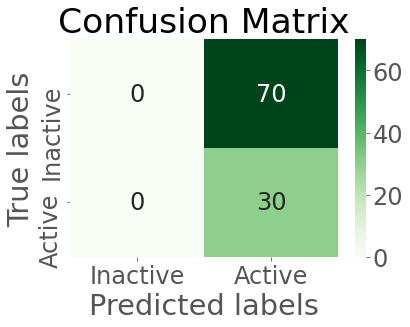

-----------> Calculating with fold 5 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 1 0 1 0 0 0 0 1 0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 1 0 0 1 0 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 1
 0 1 1 0 1 0 1 1 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0
 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 1
 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0
 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0
 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0
 0 0 1 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 7s - loss: 7.5630 - accuracy: 0.5775 - precision_52: 0.3333 - recall_52: 0.4083
Epoch 2/10
400/400 - 3s - loss: 7.5467 - accuracy: 0.5375 - precision_52: 0.3415 - recall_52: 0.5833
Epoch 3/10
400/400 - 3s - loss: 7.5475 - accuracy: 0.4725 - precision_52: 0.3030 - recall_52: 0.5833
Epoch 4/10
400/400 - 3s - loss: 7.5488 - accuracy: 0.3625 - precision_52: 0.2712 - recall_52: 0.6667
Epoch 5/10
400/400 - 3s - loss: 7.5329 - accuracy: 0.4500 - precision_52: 0.3276 - recall_52: 0.7917
Epoch 6/10
400/400 - 3s - loss: 7.5312 - accuracy: 0.4450 - precision_52: 0.3179 - recall_52: 0.7417
Epoch 7/10
400/400 - 3s - loss: 7.5274 - accuracy: 0.3925 - precision_52: 0.3153 - recall_52: 0.8750
Epoch 8/10
400/400 - 3s - loss: 7.5207 - accuracy: 0.4450 - precision_52: 0.3333 - recall_52: 0.8500
Epoch 9/10
400/400 - 5s - loss: 7.5214 - accuracy: 0.4225 - precision_52: 0.3227 - recall_52: 0.8417
Epoch 10/10
400/400 - 4s - loss: 7.5148 - accuracy: 0.4550 - precision

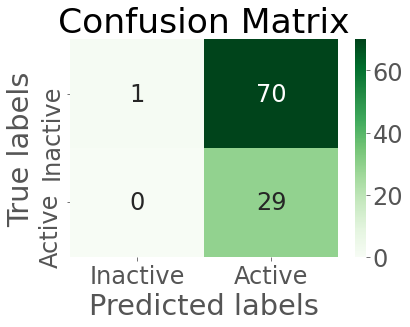

/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 1 0 1 0 0 0 0 1 0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 1 0 0 1 0 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 1
 0 1 1 0 1 0 1 1 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0
 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 1
 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0
 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0
 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0
 0 0 1 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 1 0 0 0
 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0 

Train on 500 samples
Epoch 1/10
500/500 - 9s - loss: 7.5498 - accuracy: 0.4300 - precision_53: 0.3122 - recall_53: 0.7584
Epoch 2/10
500/500 - 4s - loss: 7.5452 - accuracy: 0.3920 - precision_53: 0.2997 - recall_53: 0.7785
Epoch 3/10
500/500 - 4s - loss: 7.5385 - accuracy: 0.4080 - precision_53: 0.3040 - recall_53: 0.7651
Epoch 4/10
500/500 - 5s - loss: 7.5318 - accuracy: 0.3700 - precision_53: 0.2946 - recall_53: 0.7987
Epoch 5/10
500/500 - 5s - loss: 7.5326 - accuracy: 0.4260 - precision_53: 0.3155 - recall_53: 0.7919
Epoch 6/10
500/500 - 4s - loss: 7.5263 - accuracy: 0.4180 - precision_53: 0.2971 - recall_53: 0.6980
Epoch 7/10
500/500 - 4s - loss: 7.5206 - accuracy: 0.3940 - precision_53: 0.3015 - recall_53: 0.7852
Epoch 8/10
500/500 - 4s - loss: 7.5185 - accuracy: 0.4420 - precision_53: 0.3121 - recall_53: 0.7248
Epoch 9/10
500/500 - 4s - loss: 7.5101 - accuracy: 0.4460 - precision_53: 0.3140 - recall_53: 0.7248
Epoch 10/10
500/500 - 5s - loss: 7.4992 - accuracy: 0.4660 - precision

/Users/Anna/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.305, Correctly calssified: 0.305, MCC: nan, F1 score: 0.467, Balanced accuracy: 0.000
----> Test set split 9


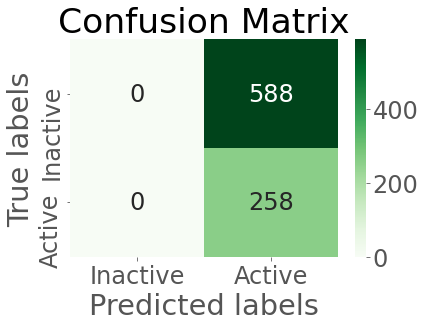

CV fold 4 of split 8 out of 10


/Users/Anna/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: All-NaN axis encountered
/Users/Anna/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: All-NaN axis encountered


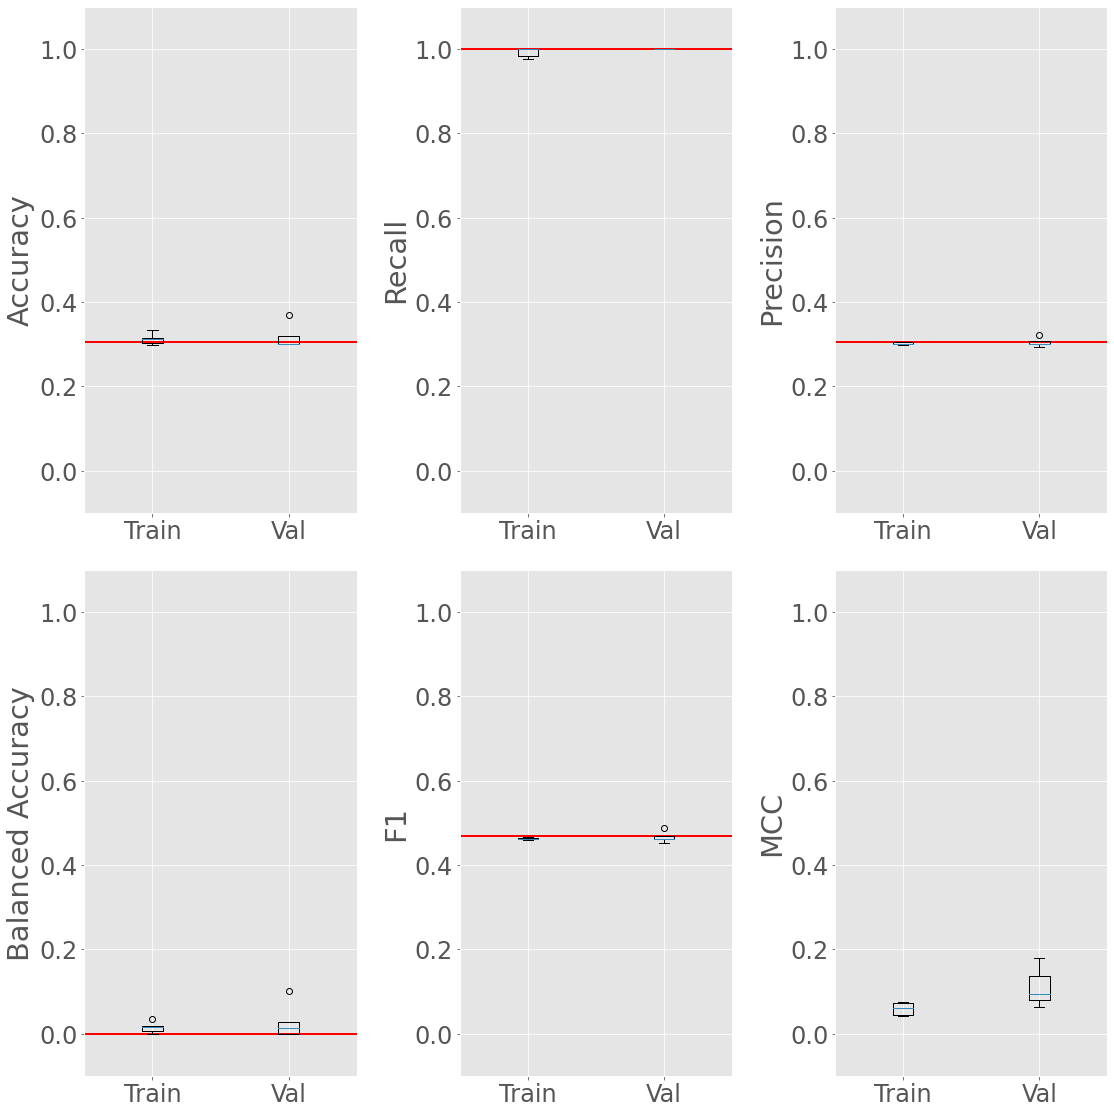

--------------> STARTING SPLIT 10 <--------------
-----------> Calculating with fold 1 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0 1 0 1 1 1
 1 1 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 1 1 1 0
 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 1 0 0 0 0 0 1 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0
 0 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 0 0 1 0 1 0 1 1 0 1 1 0 1 0 0 1 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 1 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1
 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 1 0 1 1 1 0 0 0 1 1 0
 0 0 1 0 0 1 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 11s - loss: 7.5600 - accuracy: 0.5775 - precision_54: 0.3016 - recall_54: 0.3193
Epoch 2/10
400/400 - 3s - loss: 7.5528 - accuracy: 0.5850 - precision_54: 0.3309 - recall_54: 0.3866
Epoch 3/10
400/400 - 4s - loss: 7.5501 - accuracy: 0.5275 - precision_54: 0.2840 - recall_54: 0.3866
Epoch 4/10
400/400 - 3s - loss: 7.5460 - accuracy: 0.5275 - precision_54: 0.3034 - recall_54: 0.4538
Epoch 5/10
400/400 - 4s - loss: 7.5389 - accuracy: 0.5325 - precision_54: 0.3172 - recall_54: 0.4958
Epoch 6/10
400/400 - 3s - loss: 7.5379 - accuracy: 0.5250 - precision_54: 0.2924 - recall_54: 0.4202
Epoch 7/10
400/400 - 4s - loss: 7.5358 - accuracy: 0.5175 - precision_54: 0.2716 - recall_54: 0.3697
Epoch 8/10
400/400 - 3s - loss: 7.5307 - accuracy: 0.5075 - precision_54: 0.2857 - recall_54: 0.4370
Epoch 9/10
400/400 - 4s - loss: 7.5282 - accuracy: 0.5200 - precision_54: 0.2865 - recall_54: 0.4118
Epoch 10/10
400/400 - 4s - loss: 7.5234 - accuracy: 0.5400 - precisio

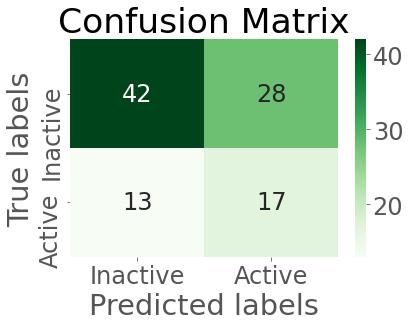

-----------> Calculating with fold 2 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 1 0 1 0 1
 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 0 0 1 1 1 0
 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0
 1 0 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0
 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0
 1 0 1 1 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 1
 0 0 0 0 0 1 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 10s - loss: 7.5643 - accuracy: 0.6450 - precision_55: 0.3231 - recall_55: 0.1765
Epoch 2/10
400/400 - 4s - loss: 7.5607 - accuracy: 0.6325 - precision_55: 0.3250 - recall_55: 0.2185
Epoch 3/10
400/400 - 4s - loss: 7.5577 - accuracy: 0.6025 - precision_55: 0.2872 - recall_55: 0.2269
Epoch 4/10
400/400 - 4s - loss: 7.5496 - accuracy: 0.5900 - precision_55: 0.3404 - recall_55: 0.4034
Epoch 5/10
400/400 - 5s - loss: 7.5480 - accuracy: 0.5275 - precision_55: 0.2840 - recall_55: 0.3866
Epoch 6/10
400/400 - 4s - loss: 7.5436 - accuracy: 0.4750 - precision_55: 0.3080 - recall_55: 0.6134
Epoch 7/10
400/400 - 3s - loss: 7.5367 - accuracy: 0.4600 - precision_55: 0.3036 - recall_55: 0.6303
Epoch 8/10
400/400 - 4s - loss: 7.5352 - accuracy: 0.4000 - precision_55: 0.2800 - recall_55: 0.6471
Epoch 9/10
400/400 - 4s - loss: 7.5319 - accuracy: 0.3975 - precision_55: 0.2852 - recall_55: 0.6807
Epoch 10/10
400/400 - 4s - loss: 7.5313 - accuracy: 0.4525 - precisio

/Users/Anna/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.297, Correctly calssified: 0.297, MCC: nan, F1 score: 0.459, Balanced accuracy: 0.000
---> Validation set fold 2
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.300, Correctly calssified: 0.300, MCC: nan, F1 score: 0.462, Balanced accuracy: 0.000


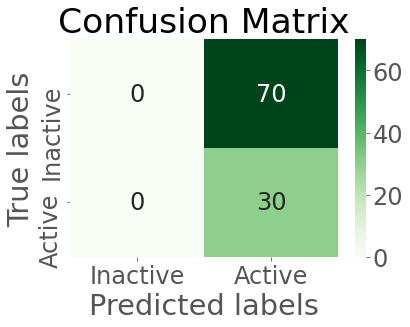

-----------> Calculating with fold 3 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 0 1 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 1 1 1 1 0 0 0 0
 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0
 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0
 1 0 0 0 0 1 0 1 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 1
 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1
 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 1 1 0 1 1 1 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0
 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 1 1 0 1 0 0 0 1 0 0 1
 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 9s - loss: 7.5567 - accuracy: 0.7050 - precision_56: 0.6667 - recall_56: 0.0168
Epoch 2/10
400/400 - 4s - loss: 7.5537 - accuracy: 0.6975 - precision_56: 0.3333 - recall_56: 0.0168
Epoch 3/10
400/400 - 3s - loss: 7.5509 - accuracy: 0.6725 - precision_56: 0.0000e+00 - recall_56: 0.0000e+00
Epoch 4/10
400/400 - 4s - loss: 7.5448 - accuracy: 0.6825 - precision_56: 0.3462 - recall_56: 0.0756
Epoch 5/10
400/400 - 4s - loss: 7.5419 - accuracy: 0.6550 - precision_56: 0.2286 - recall_56: 0.0672
Epoch 6/10
400/400 - 4s - loss: 7.5388 - accuracy: 0.6325 - precision_56: 0.1818 - recall_56: 0.0672
Epoch 7/10
400/400 - 3s - loss: 7.5317 - accuracy: 0.6750 - precision_56: 0.3590 - recall_56: 0.1176
Epoch 8/10
400/400 - 4s - loss: 7.5318 - accuracy: 0.6050 - precision_56: 0.2254 - recall_56: 0.1345
Epoch 9/10
400/400 - 3s - loss: 7.5266 - accuracy: 0.6600 - precision_56: 0.3396 - recall_56: 0.1513
Epoch 10/10
400/400 - 3s - loss: 7.5249 - accuracy: 0.5925 - p

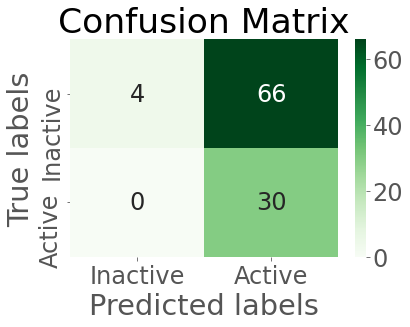

-----------> Calculating with fold 4 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 0 1 0 0 1 0 1 1 0 0 1 0 1 1 0 0 0 1 0 0 1 0 0 1 1 0 1 0 0 1 1 1 0 1 1 1
 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1 0 0 1 1 1 0
 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1
 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0 0 1 1 1 1 0 0
 1 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0
 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 0 0 0
 0 1 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 12s - loss: 7.5651 - accuracy: 0.6825 - precision_57: 0.1667 - recall_57: 0.0168
Epoch 2/10
400/400 - 3s - loss: 7.5577 - accuracy: 0.6800 - precision_57: 0.3200 - recall_57: 0.0672
Epoch 3/10
400/400 - 3s - loss: 7.5514 - accuracy: 0.6850 - precision_57: 0.4186 - recall_57: 0.1513
Epoch 4/10
400/400 - 3s - loss: 7.5485 - accuracy: 0.6525 - precision_57: 0.3214 - recall_57: 0.1513
Epoch 5/10
400/400 - 3s - loss: 7.5434 - accuracy: 0.6625 - precision_57: 0.3519 - recall_57: 0.1597
Epoch 6/10
400/400 - 3s - loss: 7.5381 - accuracy: 0.5900 - precision_57: 0.3043 - recall_57: 0.2941
Epoch 7/10
400/400 - 4s - loss: 7.5381 - accuracy: 0.5250 - precision_57: 0.2370 - recall_57: 0.2689
Epoch 8/10
400/400 - 3s - loss: 7.5328 - accuracy: 0.4925 - precision_57: 0.2766 - recall_57: 0.4370
Epoch 9/10
400/400 - 3s - loss: 7.5270 - accuracy: 0.5250 - precision_57: 0.3161 - recall_57: 0.5126
Epoch 10/10
400/400 - 3s - loss: 7.5261 - accuracy: 0.4625 - precisio

/Users/Anna/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


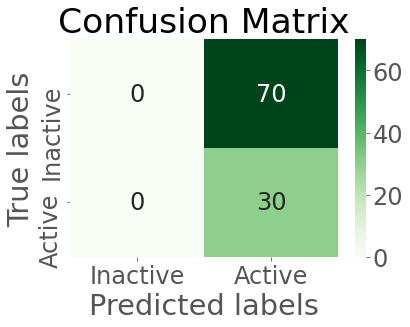

-----------> Calculating with fold 5 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 1 0 0 1 1 1 0 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 0 0 1 1 0 1 0 1 1 1 0 0 1 0
 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0
 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 1 1 0
 1 0 0 0 0 1 0 1 1 0 0 0 1 1 1 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1
 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1
 1 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 1 1 0 0 1 0 0 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 1 1 1 0 0 1 1 1 0 0 0 0 1 0 0 0
 0 0 0 0 1 1 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0] as keyword args. From version 0.25 passing these as positional argum

Train on 400 samples
Epoch 1/10
400/400 - 10s - loss: 7.5625 - accuracy: 0.6975 - precision_58: 0.0000e+00 - recall_58: 0.0000e+00
Epoch 2/10
400/400 - 4s - loss: 7.5561 - accuracy: 0.6975 - precision_58: 0.4444 - recall_58: 0.0333
Epoch 3/10
400/400 - 4s - loss: 7.5511 - accuracy: 0.6775 - precision_58: 0.2000 - recall_58: 0.0250
Epoch 4/10
400/400 - 3s - loss: 7.5447 - accuracy: 0.6875 - precision_58: 0.3684 - recall_58: 0.0583
Epoch 5/10
400/400 - 4s - loss: 7.5427 - accuracy: 0.6350 - precision_58: 0.1750 - recall_58: 0.0583
Epoch 6/10
400/400 - 4s - loss: 7.5377 - accuracy: 0.6425 - precision_58: 0.2326 - recall_58: 0.0833
Epoch 7/10
400/400 - 4s - loss: 7.5306 - accuracy: 0.6250 - precision_58: 0.2500 - recall_58: 0.1250
Epoch 8/10
400/400 - 3s - loss: 7.5284 - accuracy: 0.6625 - precision_58: 0.3846 - recall_58: 0.2083
Epoch 9/10
400/400 - 4s - loss: 7.5273 - accuracy: 0.5900 - precision_58: 0.2381 - recall_58: 0.1667
Epoch 10/10
400/400 - 5s - loss: 7.5197 - accuracy: 0.6175 - 

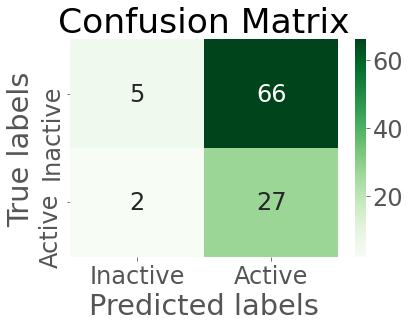

/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 1 0 0 1 1 1 0 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 0 0 1 1 0 1 0 1 1 1 0 0 1 0
 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0
 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 1 1 0
 1 0 0 0 0 1 0 1 1 0 0 0 1 1 1 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1
 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1
 1 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 1 1 0 0 1 0 0 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 1 1 1 0 0 1 1 1 0 0 0 0 1 0 0 0
 0 0 0 0 1 1 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0
 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 1 0 1 0 1 0 1 0 0 1 

Train on 500 samples
Epoch 1/10
500/500 - 8s - loss: 7.5581 - accuracy: 0.2980 - precision_59: 0.2972 - recall_59: 0.9933
Epoch 2/10
500/500 - 5s - loss: 7.5510 - accuracy: 0.3000 - precision_59: 0.2978 - recall_59: 0.9933
Epoch 3/10
500/500 - 4s - loss: 7.5436 - accuracy: 0.3080 - precision_59: 0.3010 - recall_59: 1.0000
Epoch 4/10
500/500 - 5s - loss: 7.5401 - accuracy: 0.3320 - precision_59: 0.3069 - recall_59: 0.9866
Epoch 5/10
500/500 - 4s - loss: 7.5385 - accuracy: 0.3300 - precision_59: 0.3054 - recall_59: 0.9799
Epoch 6/10
500/500 - 5s - loss: 7.5310 - accuracy: 0.3320 - precision_59: 0.3053 - recall_59: 0.9732
Epoch 7/10
500/500 - 4s - loss: 7.5258 - accuracy: 0.3440 - precision_59: 0.3059 - recall_59: 0.9463
Epoch 8/10
500/500 - 4s - loss: 7.5212 - accuracy: 0.3440 - precision_59: 0.3067 - recall_59: 0.9530
Epoch 9/10
500/500 - 4s - loss: 7.5153 - accuracy: 0.3800 - precision_59: 0.3207 - recall_59: 0.9664
Epoch 10/10
500/500 - 4s - loss: 7.5123 - accuracy: 0.3380 - precision

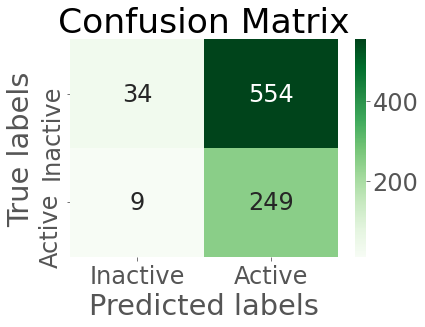

CV fold 4 of split 9 out of 10


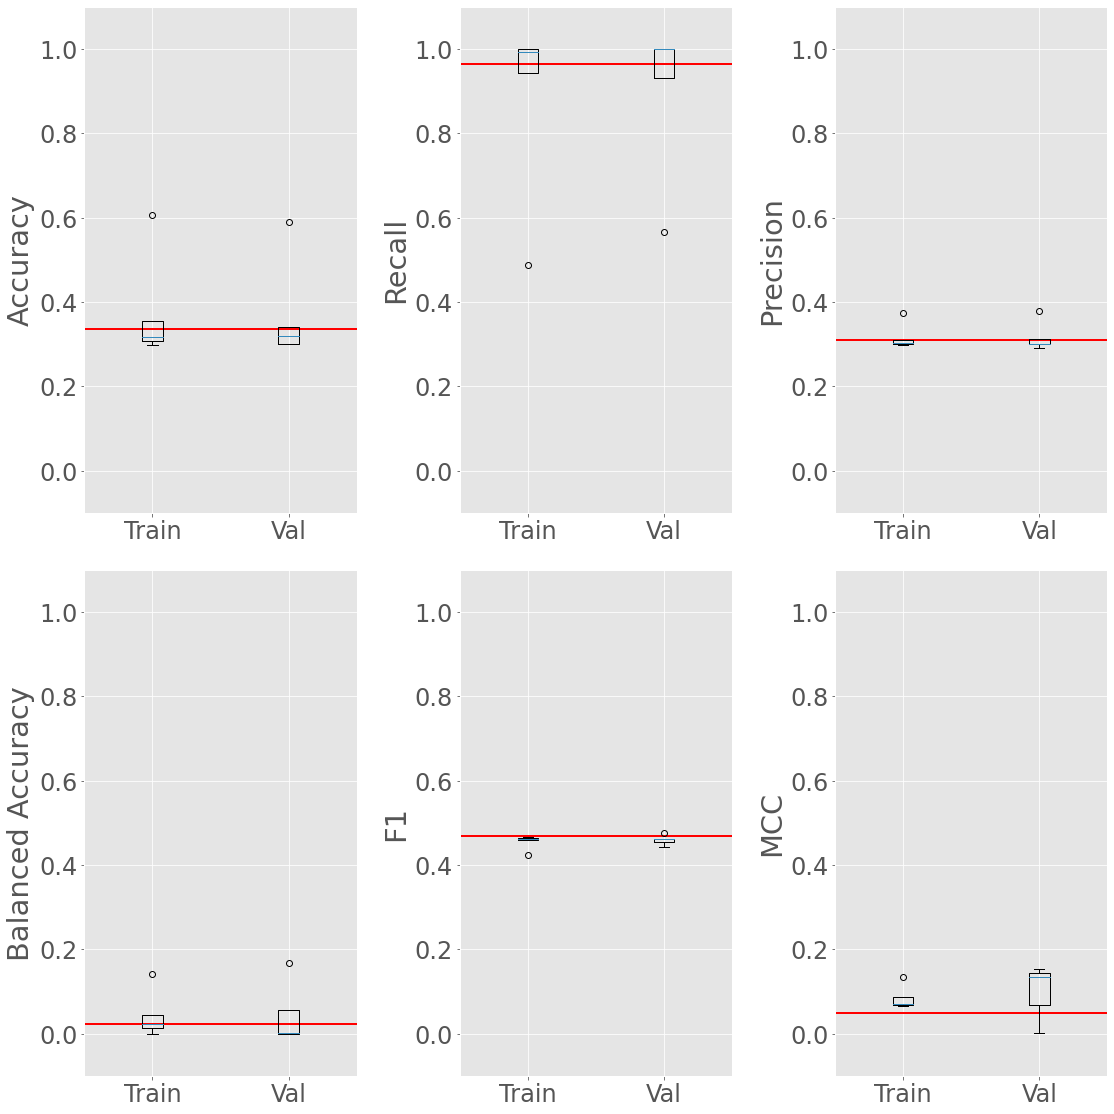

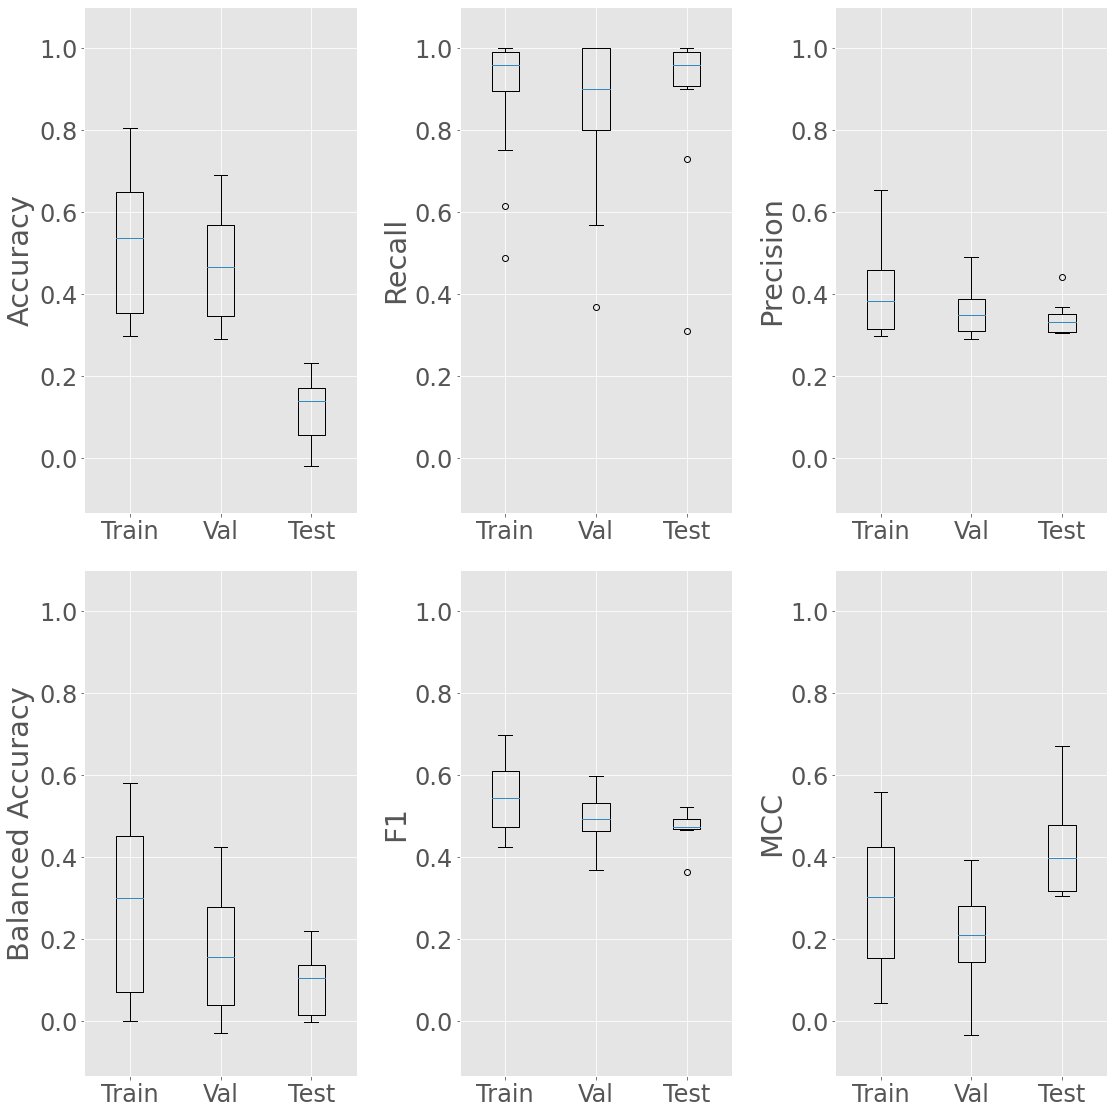

In [28]:
layers_dim = layers_dimensions.copy()

MCCs_train_split, MCCs_val_split, MCCs_test_split  = [],[],[]
accs_train_split, accs_val_split, accs_test_split= [],[],[]
recall_train_split, recall_val_split, recall_test_split = [],[],[]
precision_train_split, precision_val_split, precision_test_split = [],[],[]
F1_train_split, F1_val_split, F1_test_split = [],[],[]
balanced_acc_train_split, balanced_acc_val_split, balanced_acc_test_split = [],[],[]

for split, seed in enumerate(rand_num):
    print(f"--------------> STARTING SPLIT {split+1} <--------------")
    if use_fingerprints:
        train_val_data_fp, _, train_val_labels_fp, _ = train_test_split(features_shared, labels_2c9, train_size=dataset_size, test_size=2, stratify=labels_2c9, random_state=seed)
    if use_descriptors:
        train_val_data_des, _, train_val_labels_des, _ = train_test_split(norm_descriptors_shared, labels_2c9, train_size=dataset_size, test_size=2, stratify=labels_2c9, random_state=seed)
    if use_descriptors and use_fingerprints:
        npt.assert_array_equal(train_val_labels_fp, train_val_labels_des, err_msg='Train labels do not coincide between descriptors and fingerprints.')
        assert train_val_data_fp.shape[0] == train_val_data_des.shape[0]
       
    best_features_split_fp, best_features_split_des = [], []
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    
    MCCs_train, MCCs_val = [],[]
    accs_train, accs_val= [],[]
    recall_train, recall_val = [],[]
    precision_train, precision_val = [],[]
    F1_train, F1_val = [],[]
    balanced_acc_train, balanced_acc_val = [],[]
    
    for i, (train_index, val_index) in enumerate(skf.split(train_val_data_fp, train_val_labels_fp)):
        if use_fingerprints:
            train_data_fp, val_data_fp = train_val_data_fp[train_index], train_val_data_fp[val_index]
            train_labels_fp, val_labels_fp = train_val_labels_fp[train_index], train_val_labels_fp[val_index]
            data_fs_fp, best_fold_fp = get_best_features(train_data_fp, train_labels_fp, val_data_fp, percetile_fingerprint)
            best_features_split_fp.extend(list(best_fold_fp))
            
            assert train_data_fp.shape[1] == val_data_fp.shape[1]
            assert train_data_fp.shape[0] == train_labels_fp.shape[0]
            assert val_data_fp.shape[0] == val_labels_fp.shape[0]
            assert best_fold_fp.shape[0] == data_fs_fp['train_data_fs'].shape[1]
                       
            if not use_descriptors: # to avoid conditional statements
                train_data, val_data = data_fs_fp['train_data_fs'], data_fs_fp['val_data_fs']
                train_labels, val_labels = train_labels_fp, val_labels_fp
        
        if use_descriptors:
            train_data_des, val_data_des = train_val_data_des[train_index], train_val_data_des[val_index]
            train_labels_des, val_labels_des = train_val_labels_des[train_index], train_val_labels_des[val_index]
            data_fs_des, best_fold_des = get_best_features(train_data_des, train_labels_des, val_data_des, percetile_descriptors)
            best_features_split_des.extend(list(best_fold_des))
            
            assert train_data_des.shape[1] == val_data_des.shape[1]
            assert train_data_des.shape[0] == train_labels_des.shape[0]
            assert val_data_des.shape[0] == val_labels_des.shape[0]
            assert best_fold_des.shape[0] == data_fs_des['train_data_fs'].shape[1]
            
            if not use_fingerprints:
                train_data, val_data = data_fs_des['train_data_fs'], data_fs_des['val_data_fs']
                train_labels, val_labels = train_labels_des, val_labels_des
                
        if use_descriptors and use_fingerprints:
            npt.assert_array_equal(train_labels_fp, train_labels_des, err_msg='Train labels do not coincide between descriptors and fingerprints.')
            npt.assert_array_equal(val_labels_fp, val_labels_des, err_msg='Validation labels do not coincide between descriptors and fingerprints.')
            assert data_fs_fp['train_data_fs'].shape[0] == data_fs_des['train_data_fs'].shape[0]
            assert data_fs_fp['val_data_fs'].shape[0] == data_fs_des['val_data_fs'].shape[0]
 
            train_labels, val_labels = train_labels_des, val_labels_des
            
            train_data = np.concatenate([data_fs_fp['train_data_fs'], data_fs_des['train_data_fs']], axis=1)
            val_data = np.concatenate([data_fs_fp['val_data_fs'], data_fs_des['val_data_fs']], axis=1)
                
        print(f"-----------> Calculating with fold {i+1} <----------")
       
        if not layers_dim[0] == train_data.shape[1]:
            layers_dim.insert(0, train_data.shape[1])
            print(type(layers_dim))

        class_weights = compute_class_weight('balanced',np.unique(train_labels), train_labels)
        class_weight = {0: class_weights[0], 1: class_weights[1]}
        
        model = generate_model(layers_dim, lr, dropout, optimizer, L2)
        # si hi ha una llista de models, es podria fer for loop de model in models
        history = model.fit(train_data, train_labels, epochs=10, verbose=2, class_weight=class_weight)#, validation_data = (val_data, val_labels))
      
        pred_train = model.predict(train_data)
        dict_train = print_metrics(pred_train, train_labels)
        train_acc, train_mcc, train_recall, train_precision, train_f1, train_balanced_acc = dict_train['accuracy'], dict_train['mcc'],  dict_train['recall'],  dict_train['precision'], dict_train['f1'], dict_train['balanced_accuracy']

        pred_val = model.predict(val_data)
        print(f"---> Validation set fold {i+1}")
        dict_val = print_metrics(pred_val, val_labels)
        val_acc, val_mcc, val_recall, val_precision, val_f1, val_balanced_acc  = dict_val['accuracy'], dict_val['mcc'],  dict_val['recall'],  dict_val['precision'], dict_val['f1'], dict_val['balanced_accuracy']
        plot_confusion(pred_val, val_labels)
        
        MCCs_train.append(train_mcc), MCCs_val.append(val_mcc)
        accs_train.append(train_acc), accs_val.append(val_acc)
        recall_train.append(train_recall), recall_val.append(val_recall)
        precision_train.append(train_precision), precision_val.append(val_precision)
        F1_train.append(train_f1), F1_val.append(val_f1)
        balanced_acc_train.append(train_balanced_acc), balanced_acc_val.append(val_balanced_acc)
    
    if use_fingerprints:
        best_feat_CV_fp = find_best_features(best_features_split_fp, data_fs_fp['train_data_fs'].shape[1])
        train_val_data_fp = np.concatenate([train_data_fp, val_data_fp], axis=0)
        
        assert train_val_data_fp.shape[0] == train_data_fp.shape[0] + val_data_fp.shape[0]
        assert train_val_data_fp.shape[1] == train_data_fp.shape[1]
        
        train_val_data_fs_fp = train_val_data_fp[:,best_feat_CV_fp]
        test_data_fp = features_only_2c9[:,best_feat_CV_fp]

        if not use_descriptors:
            labels_split = np.concatenate([train_labels_fp, val_labels_fp], axis=0)
            train_val_data_fs = train_val_data_fs_fp
            test_data = test_data_fp
            
    if use_descriptors:
        best_feat_CV_des = find_best_features(best_features_split_des, data_fs_des['train_data_fs'].shape[1])
        train_val_data_des = np.concatenate([train_data_des, val_data_des], axis=0)
        
        assert train_val_data_des.shape[0] == train_data_des.shape[0] + val_data_des.shape[0]
        assert train_val_data_des.shape[1] == train_data_des.shape[1]
        
        train_val_data_fs_des = train_val_data_des[:,best_feat_CV_des]
        test_data_des = norm_descriptors_only2c9[:,best_feat_CV_des]

        if not use_fingerprints:
            labels_split = np.concatenate([train_labels_des, val_labels_des], axis=0)
            train_val_data_fs = train_val_data_fs_des
            test_data = test_data_des
            
    if use_fingerprints and use_descriptors:
        labels_split = np.concatenate([train_labels_fp, val_labels_fp], axis=0)        
        train_val_data_fs = np.concatenate([train_val_data_fs_fp, train_val_data_fs_des], axis=1)
        test_data = np.concatenate([test_data_fp, test_data_des], axis=1)
    
    class_weights = compute_class_weight('balanced',np.unique(labels_split), labels_split)
    class_weight = {0: class_weights[0], 1: class_weights[1]}
        
    model = generate_model(layers_dim, lr, dropout, optimizer, L2)
    history = model.fit(train_val_data_fs, labels_split, epochs=10, verbose=2, class_weight=class_weight)
    
    pred_test = model.predict(test_data)
    dict_test = print_metrics(pred_test, labels_testing_2c9)
    test_acc, test_mcc, test_recall, test_precision, test_f1, test_balanced_acc = dict_test['accuracy'], dict_test['mcc'],  dict_test['recall'],  dict_test['precision'], dict_test['f1'], dict_test['balanced_accuracy']
    
    print(f"----> Test set split {split+1}")
    plot_confusion(pred_test, labels_testing_2c9)
    
    print(f"CV fold {i} of split {split} out of {len(rand_num)}")
    plot_results_CV(MCCs_train, MCCs_val, accs_train, accs_val, recall_train, recall_val, precision_train, precision_val, F1_train, F1_val, balanced_acc_train, balanced_acc_val, test_acc, test_mcc, test_recall, test_precision, test_f1, test_balanced_acc)
    
    MCCs_train_split.extend(MCCs_train), MCCs_val_split.extend(MCCs_val), MCCs_test_split.append(test_mcc)
    accs_train_split.extend(accs_train), accs_val_split.extend(accs_val), accs_test_split.append(test_acc)
    recall_train_split.extend(recall_train), recall_val_split.extend(recall_val), recall_test_split.append(test_recall)
    precision_train_split.extend(precision_train), precision_val_split.extend(precision_val), precision_test_split.append(test_precision)
    F1_train_split.extend(F1_train), F1_val_split.extend(F1_val), F1_test_split.append(test_f1)
    balanced_acc_train_split.extend(balanced_acc_train), balanced_acc_val_split.extend(balanced_acc_val), balanced_acc_test_split.append(test_balanced_acc)
    
plot_results_split(MCCs_train_split, MCCs_val_split, accs_train_split, accs_val_split, recall_train_split, recall_val_split, precision_train_split, precision_val_split, F1_train_split, F1_val_split, balanced_acc_train_split, balanced_acc_val_split, MCCs_test_split, accs_test_split, recall_test_split, precision_test_split, F1_test_split, balanced_acc_test_split)


### 5.B)

In this case, we'll find the features that are useful for each split and then, select the ones that are more relevant. 
With the most relevant features, we'll do the cross validation.

#### Load useful functions

In [29]:
def get_best_features_per_split(features, labels, percetile_fingerprint=60, percetile_descriptors=60, train_size=450, val_size=50, seed=1, plot_distribution=False):
    """Splits the data and find the best features"""
    data = split_features(features, labels, train_size=train_size, val_size=val_size, seed=seed, plot_distribution=plot_distribution)
    train_data, val_data, fs = select_features(data['train_data'], data['train_labels'], data['val_data'], score_func=mutual_info_classif, percentile = percetile_fingerprint)
    best_features = get_best_features_index(fs)
    
    assert train_data.shape[1] == val_data.shape[1]
    assert train_data.shape[1] == best_features.shape[0]
    
    return {'train_data_fs':train_data, 'val_data_fs':val_data, 'train_labels':data['train_labels'], 'val_labels':data['val_labels']}, best_features


def select_feat_and_get_best_feat_per_split(use_fingerprints, use_descriptors, fp_data=None,
                                            descriptors_data=None, labels=None, percetile_fingerprint=60, 
                                            percetile_descriptors=60, train_size=450, val_size=50, seed=1, 
                                            plot_distribution=False):
    if use_fingerprints:
        data_fs_fp, best_feat_index_fp = get_best_features_per_split(fp_data, labels, percetile_fingerprint=percetile_fingerprint, percetile_descriptors=percetile_descriptors, train_size=train_size, val_size=val_size, seed=seed, plot_distribution=plot_distribution)
        if not use_descriptors:
            return data_fs_fp, None, best_feat_index_fp, None
    if use_descriptors:
        data_fs_des, best_feat_index_des = get_best_features_per_split(descriptors_data, labels, percetile_fingerprint=percetile_fingerprint, percetile_descriptors=percetile_descriptors, train_size=train_size, val_size=val_size, seed=seed, plot_distribution=plot_distribution)
        if not use_fingerprints:
            return None, data_fs_des, None, best_feat_index_des
    if use_descriptors and use_fingerprints:
        npt.assert_array_equal(data_fs_fp['train_labels'], data_fs_des['train_labels'], err_msg='Train labels do not coincide between descriptors and fingerprints.')
        npt.assert_array_equal(data_fs_fp['val_labels'], data_fs_des['val_labels'], err_msg='Validation labels do not coincide between descriptors and fingerprints.')
        assert data_fs_fp['train_data_fs'].shape[0] == data_fs_des['train_data_fs'].shape[0]
        assert data_fs_fp['val_data_fs'].shape[0] == data_fs_des['val_data_fs'].shape[0]
        
        return data_fs_fp, data_fs_des, best_feat_index_fp, best_feat_index_des

#### B1) Best features selection
- Generate 15 random numbers that are going to be used as seeds for the splitting of the train/val datasets.
    - It is important to save this random numbers, because they are going to be used for the cross validation.
- Split the train and validation set many times (15 times) to reduce the possibiity of having a wierd split.
    - Selection of the best features for each split.
- Select the best features considering the best features for each split
    - To do so, we'll use a consensus function (most repeated).

#### B2) Validation model with the best features
- Split the whole dataset with the 15 random seeds
- k-Folds CV
- Use the best features to train and test the NN

#### B3) Predicction
- Predict on the test set with the model (for each data split using the random seeds)

In [61]:
best_features_split_fp, best_features_split_des = [], []

for split, seed in enumerate(rand_num):
    print(f"--------------> STARTING SPLIT {split+1} <--------------")
    _, _, best_feat_index_fp, best_feat_index_des = select_feat_and_get_best_feat_per_split(use_fingerprints, use_descriptors, fp_data=features_shared,
                                                                    descriptors_data=norm_descriptors_shared, labels=labels_2c9, percetile_fingerprint=60, 
                                                                    percetile_descriptors=percetile_descriptors, train_size=train_size, val_size=val_size, seed=seed, 
                                                                    plot_distribution=plot_distribution)
    
    if use_fingerprints:
        best_features_split_fp.extend(list(best_feat_index_fp))
    if use_descriptors:
        best_features_split_des.extend(list(best_feat_index_des))
    

best_features_fp = find_best_features(best_features_split_fp, int(features_shared.shape[1]*percetile_fingerprint/100))
best_features_des = find_best_features(best_features_split_des, int(norm_descriptors_shared.shape[1]*percetile_descriptors/100))


--------------> STARTING SPLIT 1 <--------------
--------------> STARTING SPLIT 2 <--------------


--------------> STARTING SPLIT 1 <--------------
(250, 450) (250, 450)
-----------> Calculating with fold 1 <----------
[450, 30, 30, 30, 30, 1]


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 0 0 1 0 0 0 1 1 0 0 1 0 0 1 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0
 0 1 1 0 1 0 1 0 0 1 1 1 0 1 0 0 1 1 0 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 1 0
 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1
 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 1 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Train on 250 samples
Epoch 1/10
250/250 - 4s - loss: 0.8240 - accuracy: 0.5440 - precision_39: 0.3664 - recall_39: 0.6076
Epoch 2/10
250/250 - 0s - loss: 0.8405 - accuracy: 0.5000 - precision_39: 0.3258 - recall_39: 0.5443
Epoch 3/10
250/250 - 0s - loss: 0.8391 - accuracy: 0.5040 - precision_39: 0.3448 - recall_39: 0.6329
Epoch 4/10
250/250 - 0s - loss: 0.8368 - accuracy: 0.4560 - precision_39: 0.3161 - recall_39: 0.6203
Epoch 5/10
250/250 - 0s - loss: 0.8474 - accuracy: 0.4680 - precision_39: 0.2985 - recall_39: 0.5063
Epoch 6/10
250/250 - 0s - loss: 0.8402 - accuracy: 0.4720 - precision_39: 0.3221 - recall_39: 0.6076
Epoch 7/10
250/250 - 0s - loss: 0.8427 - accuracy: 0.5120 - precision_39: 0.3407 - recall_39: 0.5823
Epoch 8/10
250/250 - 0s - loss: 0.8339 - accuracy: 0.5480 - precision_39: 0.3768 - recall_39: 0.6582
Epoch 9/10
250/250 - 0s - loss: 0.8398 - accuracy: 0.5040 - precision_39: 0.3404 - recall_39: 0.6076
Epoch 10/10
250/250 - 0s - loss: 0.8478 - accuracy: 0.4440 - precision

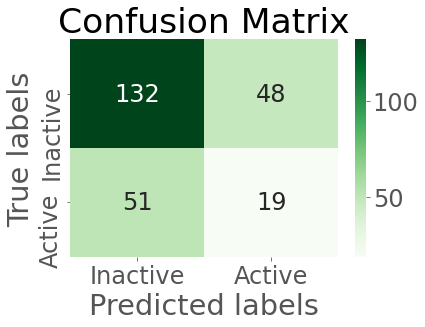

(250, 450) (250, 450)
-----------> Calculating with fold 2 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0
 0 1 0 0 1 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1
 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0
 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 0 1 0 1 0 1 0 0 0 0 1 0 1 1 0 0
 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0
 1 1 1 0 1 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Train on 250 samples
Epoch 1/10
250/250 - 5s - loss: 0.8463 - accuracy: 0.3240 - precision_40: 0.2857 - recall_40: 0.9429
Epoch 2/10
250/250 - 0s - loss: 0.8511 - accuracy: 0.3480 - precision_40: 0.2775 - recall_40: 0.8286
Epoch 3/10
250/250 - 0s - loss: 0.8428 - accuracy: 0.3440 - precision_40: 0.2844 - recall_40: 0.8857
Epoch 4/10
250/250 - 0s - loss: 0.8466 - accuracy: 0.3240 - precision_40: 0.2698 - recall_40: 0.8286
Epoch 5/10
250/250 - 0s - loss: 0.8356 - accuracy: 0.3240 - precision_40: 0.2698 - recall_40: 0.8286
Epoch 6/10
250/250 - 0s - loss: 0.8441 - accuracy: 0.3680 - precision_40: 0.3000 - recall_40: 0.9429
Epoch 7/10
250/250 - 0s - loss: 0.8425 - accuracy: 0.3560 - precision_40: 0.2802 - recall_40: 0.8286
Epoch 8/10
250/250 - 0s - loss: 0.8360 - accuracy: 0.4320 - precision_40: 0.3085 - recall_40: 0.8286
Epoch 9/10
250/250 - 0s - loss: 0.8469 - accuracy: 0.3640 - precision_40: 0.2541 - recall_40: 0.6571
Epoch 10/10
250/250 - 0s - loss: 0.8429 - accuracy: 0.4000 - precision

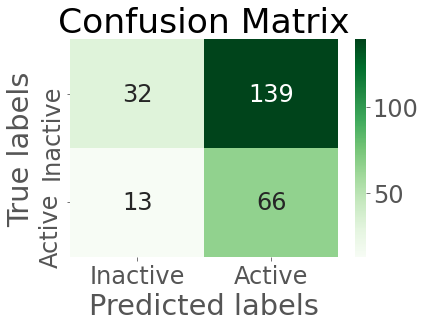

(500,) (500, 450) (846, 450)


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0
 0 1 0 0 1 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1
 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0
 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 0 1 0 1 0 1 0 0 0 0 1 0 1 1 0 0
 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0
 1 1 1 0 1 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 1
 0 0 1 0 0 1 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0 0
 1 1 1 0 1 0 0 1 1 0 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0
 1 1 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 1 1 0
 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 

Train on 500 samples
Epoch 1/10
500/500 - 4s - loss: 0.8498 - accuracy: 0.6700 - precision_41: 0.3333 - recall_41: 0.1074
Epoch 2/10
500/500 - 0s - loss: 0.8451 - accuracy: 0.6620 - precision_41: 0.2619 - recall_41: 0.0738
Epoch 3/10
500/500 - 0s - loss: 0.8420 - accuracy: 0.6680 - precision_41: 0.3509 - recall_41: 0.1342
Epoch 4/10
500/500 - 0s - loss: 0.8425 - accuracy: 0.6160 - precision_41: 0.2952 - recall_41: 0.2081
Epoch 5/10
500/500 - 0s - loss: 0.8405 - accuracy: 0.6060 - precision_41: 0.2966 - recall_41: 0.2349
Epoch 6/10
500/500 - 0s - loss: 0.8415 - accuracy: 0.5700 - precision_41: 0.2885 - recall_41: 0.3020
Epoch 7/10
500/500 - 0s - loss: 0.8421 - accuracy: 0.5380 - precision_41: 0.2929 - recall_41: 0.3893
Epoch 8/10
500/500 - 0s - loss: 0.8401 - accuracy: 0.5620 - precision_41: 0.3011 - recall_41: 0.3557
Epoch 9/10
500/500 - 0s - loss: 0.8405 - accuracy: 0.5460 - precision_41: 0.2947 - recall_41: 0.3758
Epoch 10/10
500/500 - 0s - loss: 0.8404 - accuracy: 0.5240 - precision

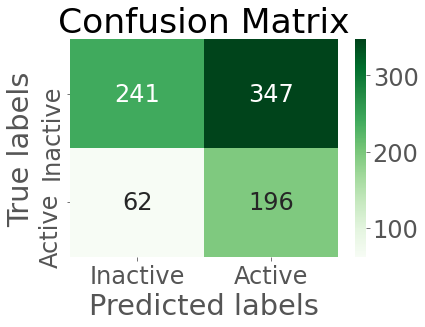

CV fold 1 of split 0 out of 2


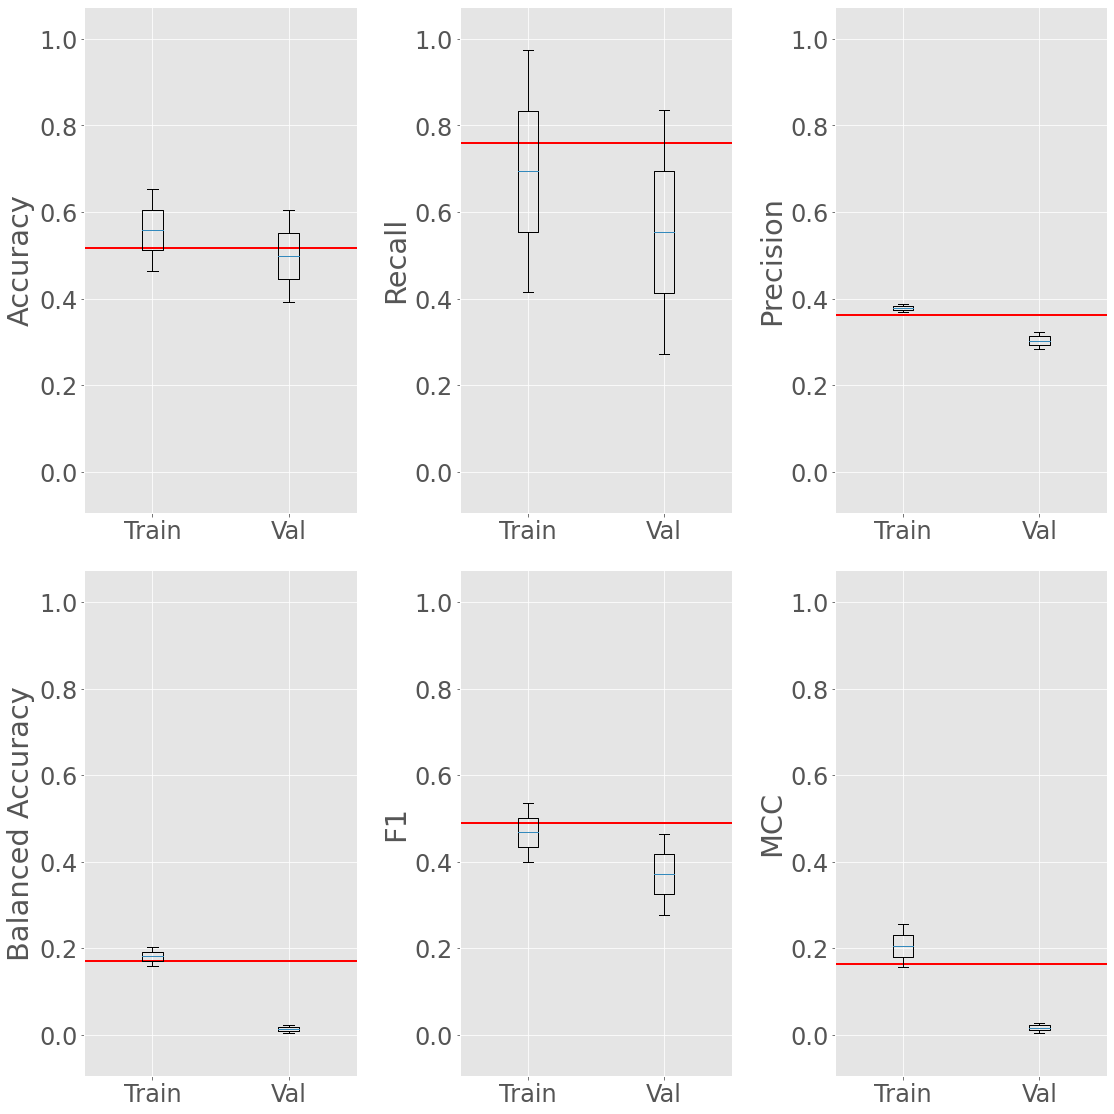

--------------> STARTING SPLIT 2 <--------------
(250, 450) (250, 450)
-----------> Calculating with fold 1 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 1 1 1 1 1 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0 1 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0
 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 0 1 1 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Train on 250 samples
Epoch 1/10
250/250 - 6s - loss: 0.8373 - accuracy: 0.3640 - precision_42: 0.2927 - recall_42: 0.8108
Epoch 2/10
250/250 - 0s - loss: 0.8406 - accuracy: 0.3880 - precision_42: 0.3092 - recall_42: 0.8649
Epoch 3/10
250/250 - 0s - loss: 0.8395 - accuracy: 0.3240 - precision_42: 0.2870 - recall_42: 0.8649
Epoch 4/10
250/250 - 0s - loss: 0.8308 - accuracy: 0.4360 - precision_42: 0.3317 - recall_42: 0.8919
Epoch 5/10
250/250 - 0s - loss: 0.8330 - accuracy: 0.3680 - precision_42: 0.3091 - recall_42: 0.9189
Epoch 6/10
250/250 - 0s - loss: 0.8341 - accuracy: 0.3640 - precision_42: 0.3005 - recall_42: 0.8649
Epoch 7/10
250/250 - 0s - loss: 0.8329 - accuracy: 0.3560 - precision_42: 0.2977 - recall_42: 0.8649
Epoch 8/10
250/250 - 0s - loss: 0.8337 - accuracy: 0.3800 - precision_42: 0.3116 - recall_42: 0.9054
Epoch 9/10
250/250 - 0s - loss: 0.8313 - accuracy: 0.3680 - precision_42: 0.3108 - recall_42: 0.9324
Epoch 10/10
250/250 - 0s - loss: 0.8358 - accuracy: 0.3480 - precision

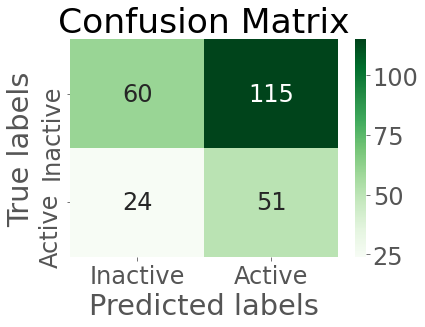

(250, 450) (250, 450)
-----------> Calculating with fold 2 <----------


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0
 0 0 0 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0
 0 0 0 0 0 0 1 0 1 1 1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 1 0
 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1
 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 1 0 1 1
 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 1 0 0 0 1 0 1 0
 0 0 1 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Train on 250 samples
Epoch 1/10
250/250 - 4s - loss: 0.8323 - accuracy: 0.4920 - precision_43: 0.3395 - recall_43: 0.7333
Epoch 2/10
250/250 - 0s - loss: 0.8484 - accuracy: 0.4360 - precision_43: 0.2708 - recall_43: 0.5200
Epoch 3/10
250/250 - 0s - loss: 0.8403 - accuracy: 0.4320 - precision_43: 0.2721 - recall_43: 0.5333
Epoch 4/10
250/250 - 0s - loss: 0.8251 - accuracy: 0.5560 - precision_43: 0.3636 - recall_43: 0.6400
Epoch 5/10
250/250 - 0s - loss: 0.8393 - accuracy: 0.5000 - precision_43: 0.3134 - recall_43: 0.5600
Epoch 6/10
250/250 - 0s - loss: 0.8435 - accuracy: 0.4520 - precision_43: 0.3013 - recall_43: 0.6267
Epoch 7/10
250/250 - 0s - loss: 0.8354 - accuracy: 0.4720 - precision_43: 0.3353 - recall_43: 0.7733
Epoch 8/10
250/250 - 0s - loss: 0.8283 - accuracy: 0.5320 - precision_43: 0.3600 - recall_43: 0.7200
Epoch 9/10
250/250 - 0s - loss: 0.8290 - accuracy: 0.5160 - precision_43: 0.3506 - recall_43: 0.7200
Epoch 10/10
250/250 - 0s - loss: 0.8327 - accuracy: 0.5040 - precision

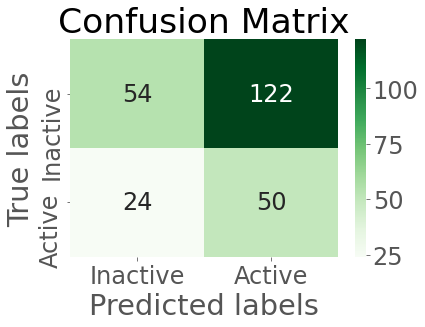

(500,) (500, 450) (846, 450)


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0
 0 0 0 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0
 0 0 0 0 0 0 1 0 1 1 1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 1 0
 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1
 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 1 0 1 1
 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 1 0 0 0 1 0 1 0
 0 0 1 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 1 1 0 1 0 0 0 1 0 1 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0
 1 0 1 1 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1
 0 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 

Train on 500 samples
Epoch 1/10
500/500 - 3s - loss: 0.8386 - accuracy: 0.4540 - precision_44: 0.2933 - recall_44: 0.5906
Epoch 2/10
500/500 - 0s - loss: 0.8406 - accuracy: 0.4720 - precision_44: 0.3127 - recall_44: 0.6443
Epoch 3/10
500/500 - 0s - loss: 0.8311 - accuracy: 0.5140 - precision_44: 0.3390 - recall_44: 0.6644
Epoch 4/10
500/500 - 0s - loss: 0.8374 - accuracy: 0.4640 - precision_44: 0.3062 - recall_44: 0.6309
Epoch 5/10
500/500 - 0s - loss: 0.8310 - accuracy: 0.4840 - precision_44: 0.3177 - recall_44: 0.6376
Epoch 6/10
500/500 - 0s - loss: 0.8350 - accuracy: 0.4520 - precision_44: 0.3156 - recall_44: 0.7181
Epoch 7/10
500/500 - 0s - loss: 0.8400 - accuracy: 0.4800 - precision_44: 0.3260 - recall_44: 0.6980
Epoch 8/10
500/500 - 0s - loss: 0.8296 - accuracy: 0.4720 - precision_44: 0.3273 - recall_44: 0.7315
Epoch 9/10
500/500 - 0s - loss: 0.8287 - accuracy: 0.4460 - precision_44: 0.3129 - recall_44: 0.7181
Epoch 10/10
500/500 - 0s - loss: 0.8257 - accuracy: 0.4780 - precision

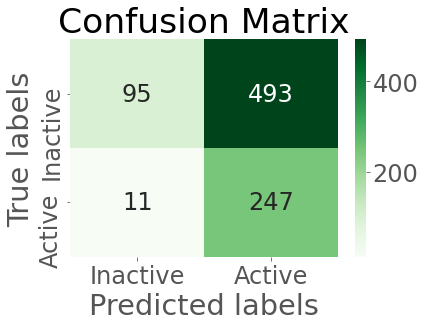

CV fold 1 of split 1 out of 2


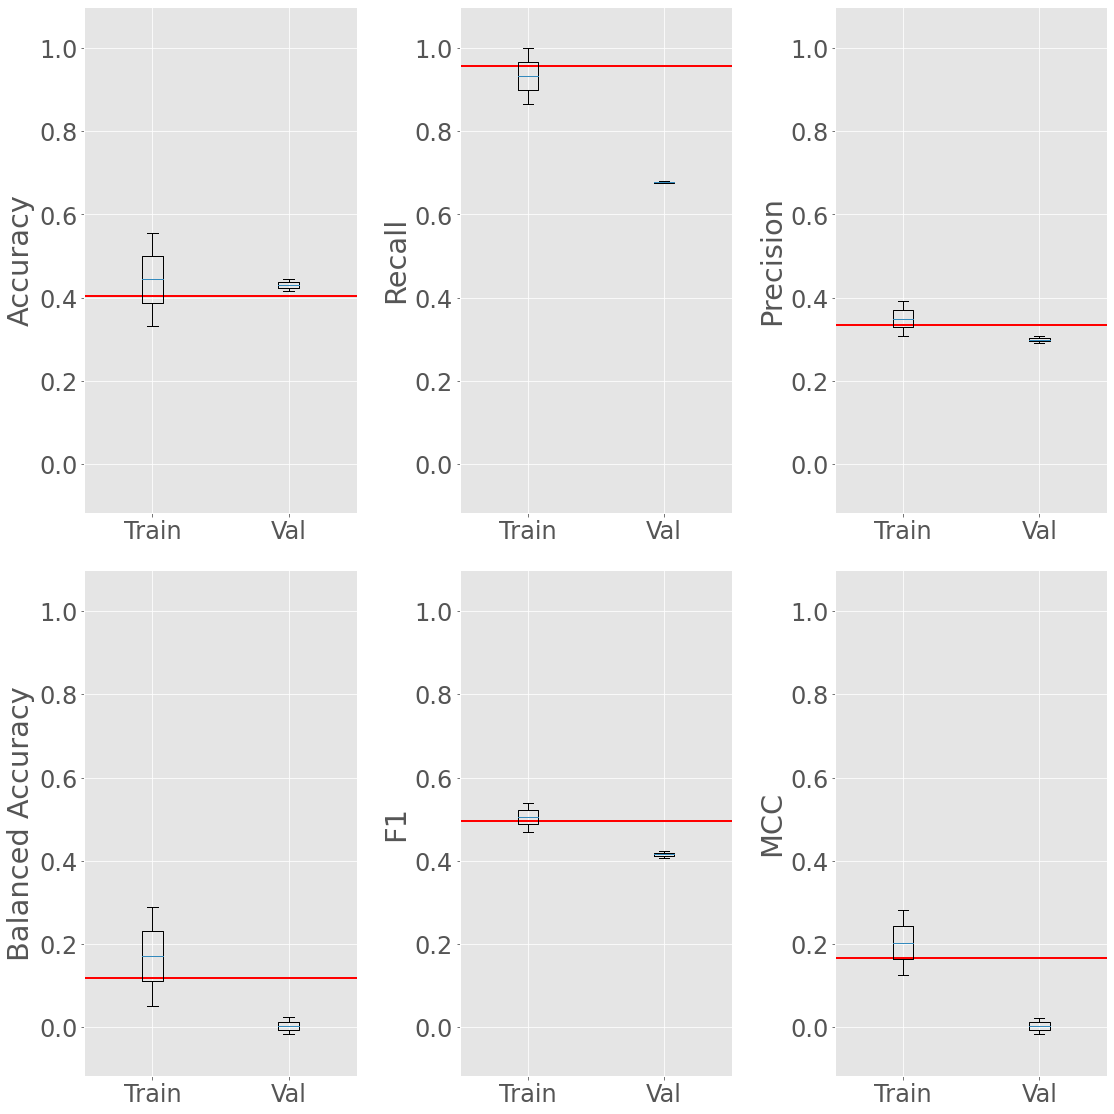

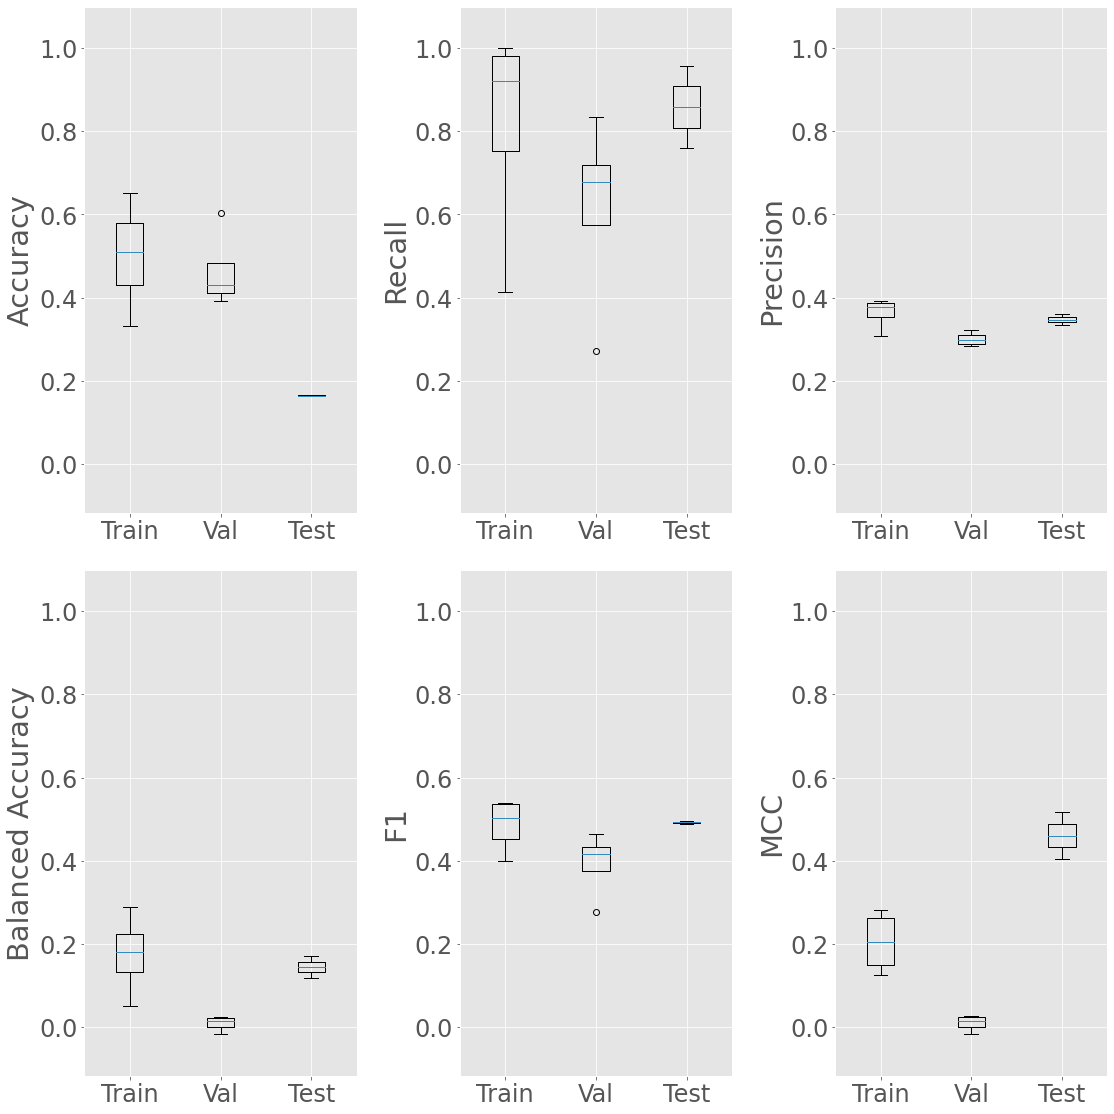

In [60]:
layers_dim = layers_dimensions.copy()

MCCs_train_split, MCCs_val_split, MCCs_test_split  = [],[],[]
accs_train_split, accs_val_split, accs_test_split= [],[],[]
recall_train_split, recall_val_split, recall_test_split = [],[],[]
precision_train_split, precision_val_split, precision_test_split = [],[],[]
F1_train_split, F1_val_split, F1_test_split = [],[],[]
balanced_acc_train_split, balanced_acc_val_split, balanced_acc_test_split = [],[],[]

for split, seed in enumerate(rand_num):
    print(f"--------------> STARTING SPLIT {split+1} <--------------")
    if use_fingerprints:
        train_val_data_fp, _, train_val_labels_fp, _ = train_test_split(features_shared, labels_2c9, train_size=dataset_size, test_size=2, stratify=labels_2c9, random_state=seed)
    if use_descriptors:
        train_val_data_des, _, train_val_labels_des, _ = train_test_split(norm_descriptors_shared, labels_2c9, train_size=dataset_size, test_size=2, stratify=labels_2c9, random_state=seed)
    if use_descriptors and use_fingerprints:
        npt.assert_array_equal(train_val_labels_fp, train_val_labels_des, err_msg='Train labels do not coincide between descriptors and fingerprints.')
        assert train_val_data_fp.shape[0] == train_val_data_des.shape[0]
       
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    
    MCCs_train, MCCs_val = [],[]
    accs_train, accs_val= [],[]
    recall_train, recall_val = [],[]
    precision_train, precision_val = [],[]
    F1_train, F1_val = [],[]
    balanced_acc_train, balanced_acc_val = [],[]
    
    for i, (train_index, val_index) in enumerate(skf.split(train_val_data_fp, train_val_labels_fp)):
        if use_fingerprints:
            train_data_fp, val_data_fp = train_val_data_fp[train_index], train_val_data_fp[val_index]
            train_data_fs_fp, val_data_fs_fp = train_data_fp[:,best_features_fp], val_data_fp[:,best_features_fp]
            train_labels_fp, val_labels_fp = train_val_labels_fp[train_index], train_val_labels_fp[val_index]
            
            assert train_data_fs_fp.shape[1] == val_data_fs_fp.shape[1]
            assert train_data_fs_fp.shape[0] == train_labels_fp.shape[0]
            assert val_data_fs_fp.shape[0] == val_labels_fp.shape[0]
                       
            if not use_descriptors: # to avoid conditional statements
                train_data, val_data = train_data_fs_fp, val_data_fs_fp
                train_labels, val_labels = train_labels_fp, val_labels_fp
        
        if use_descriptors:
            train_data_des, val_data_des = train_val_data_des[train_index], train_val_data_des[val_index]
            train_data_fs_des, val_data_fs_des = train_data_des[:,best_features_des], val_data_fp[:,best_features_des]
            train_labels_des, val_labels_des = train_val_labels_des[train_index], train_val_labels_des[val_index]
            
            assert train_data_fs_des.shape[1] == val_data_fs_des.shape[1]
            assert train_data_fs_des.shape[0] == train_labels_des.shape[0]
            assert val_data_fs_des.shape[0] == val_labels_des.shape[0]
            
            if not use_fingerprints:
                train_data, val_data = train_data_fs_des, val_data_fs_des
                train_labels, val_labels = train_labels_des, val_labels_des

        if use_descriptors and use_fingerprints:
            npt.assert_array_equal(train_labels_fp, train_labels_des, err_msg='Train labels do not coincide between descriptors and fingerprints.')
            npt.assert_array_equal(val_labels_fp, val_labels_des, err_msg='Validation labels do not coincide between descriptors and fingerprints.')
            assert train_data_fs_fp.shape[0] == train_data_fs_des.shape[0]
            assert val_data_fs_fp.shape[0] == val_data_fs_des.shape[0]
 
            train_labels, val_labels = train_labels_des, val_labels_des
            
            train_data = np.concatenate([train_data_fs_fp, train_data_fs_des], axis=1)
            val_data = np.concatenate([val_data_fs_fp, val_data_fs_des], axis=1)
            print(type(train_data))
            
        print(f"-----------> Calculating with fold {i+1} <----------")

        if not layers_dim[0] == train_data.shape[1]:
            layers_dim.insert(0, train_data.shape[1])
            print(layers_dim)

        class_weights = compute_class_weight('balanced',np.unique(train_labels), train_labels)
        class_weight = {0: class_weights[0], 1: class_weights[1]}
        
        model = generate_model(layers_dim, lr, dropout, optimizer, L2)
        # si hi ha una llista de models, es podria fer for loop de model in models
        history = model.fit(train_data, train_labels, epochs=10, verbose=2, class_weight=class_weight)#, validation_data = (val_data, val_labels))
      
        pred_train = model.predict(train_data)
        dict_train = print_metrics(pred_train, train_labels)
        train_acc, train_mcc, train_recall, train_precision, train_f1, train_balanced_acc = dict_train['accuracy'], dict_train['mcc'],  dict_train['recall'],  dict_train['precision'], dict_train['f1'], dict_train['balanced_accuracy']

        pred_val = model.predict(val_data)
        print(f"---> Validation set fold {i+1}")
        dict_val = print_metrics(pred_val, val_labels)
        val_acc, val_mcc, val_recall, val_precision, val_f1, val_balanced_acc  = dict_val['accuracy'], dict_val['mcc'],  dict_val['recall'],  dict_val['precision'], dict_val['f1'], dict_val['balanced_accuracy']
        plot_confusion(pred_val, val_labels)
        
        MCCs_train.append(train_mcc), MCCs_val.append(val_mcc)
        accs_train.append(train_acc), accs_val.append(val_acc)
        recall_train.append(train_recall), recall_val.append(val_recall)
        precision_train.append(train_precision), precision_val.append(val_precision)
        F1_train.append(train_f1), F1_val.append(val_f1)
        balanced_acc_train.append(train_balanced_acc), balanced_acc_val.append(val_balanced_acc)
    
    if use_fingerprints:
        train_val_data_fp = np.concatenate([train_data_fp, val_data_fp], axis=0)
        
        assert train_val_data_fp.shape[0] == train_data_fp.shape[0] + val_data_fp.shape[0]
        assert train_val_data_fp.shape[1] == train_data_fp.shape[1]
        
        train_val_data_fs_fp = train_val_data_fp[:,best_features_fp]
        test_data_fp = features_only_2c9[:,best_features_fp]

        if not use_descriptors:
            labels_split = np.concatenate([train_labels_fp, val_labels_fp], axis=0)
            train_val_data_fs = train_val_data_fs_fp
            test_data = test_data_fp
            
    if use_descriptors:
        train_val_data_des = np.concatenate([train_data_des, val_data_des], axis=0)
        
        assert train_val_data_des.shape[0] == train_data_des.shape[0] + val_data_des.shape[0]
        assert train_val_data_des.shape[1] == train_data_des.shape[1]
        
        train_val_data_fs_des = train_val_data_des[:,best_features_des]
        test_data_des = norm_descriptors_only2c9[:,best_features_des]

        if not use_fingerprints:
            labels_split = np.concatenate([train_labels_des, val_labels_des], axis=0)
            train_val_data_fs = train_val_data_fs_des
            test_data = test_data_des
            print(labels_split.shape, train_val_data_fs.shape, test_data.shape)
            
    if use_fingerprints and use_descriptors:
        labels_split = np.concatenate([train_labels_fp, val_labels_fp], axis=0)        
        train_val_data_fs = np.concatenate([train_val_data_fs_fp, train_val_data_fs_des], axis=1)
        test_data = np.concatenate([test_data_fp, test_data_des], axis=1)
        
        
    class_weights = compute_class_weight('balanced',np.unique(labels_split), labels_split)
    class_weight = {0: class_weights[0], 1: class_weights[1]}
        
    model = generate_model(layers_dim, lr, dropout, optimizer, L2)
    history = model.fit(train_val_data_fs, labels_split, epochs=10, verbose=2, class_weight=class_weight)
    
    pred_test = model.predict(test_data)
    dict_test = print_metrics(pred_test, labels_testing_2c9)
    test_acc, test_mcc, test_recall, test_precision, test_f1, test_balanced_acc = dict_test['accuracy'], dict_test['mcc'],  dict_test['recall'],  dict_test['precision'], dict_test['f1'], dict_test['balanced_accuracy']
    
    print(f"----> Test set split {split+1}")
    plot_confusion(pred_test, labels_testing_2c9)
    
    print(f"CV fold {i} of split {split} out of {len(rand_num)}")
    plot_results_CV(MCCs_train, MCCs_val, accs_train, accs_val, recall_train, recall_val, precision_train, precision_val, F1_train, F1_val, balanced_acc_train, balanced_acc_val, test_acc, test_mcc, test_recall, test_precision, test_f1, test_balanced_acc)
    
    MCCs_train_split.extend(MCCs_train), MCCs_val_split.extend(MCCs_val), MCCs_test_split.append(test_mcc)
    accs_train_split.extend(accs_train), accs_val_split.extend(accs_val), accs_test_split.append(test_acc)
    recall_train_split.extend(recall_train), recall_val_split.extend(recall_val), recall_test_split.append(test_recall)
    precision_train_split.extend(precision_train), precision_val_split.extend(precision_val), precision_test_split.append(test_precision)
    F1_train_split.extend(F1_train), F1_val_split.extend(F1_val), F1_test_split.append(test_f1)
    balanced_acc_train_split.extend(balanced_acc_train), balanced_acc_val_split.extend(balanced_acc_val), balanced_acc_test_split.append(test_balanced_acc)
    
plot_results_split(MCCs_train_split, MCCs_val_split, accs_train_split, accs_val_split, recall_train_split, recall_val_split, precision_train_split, precision_val_split, F1_train_split, F1_val_split, balanced_acc_train_split, balanced_acc_val_split, MCCs_test_split, accs_test_split, recall_test_split, precision_test_split, F1_test_split, balanced_acc_test_split)

